# Noise Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
from guess_range import *
from batina_guess_number import *

## Visualize HW Behavior

In [2]:
def compute_corr(secret_hw, guess_range, known_inputs, guess_val_size=1000):
    low, high = guess_range
    guess_val = np.arange(low, high, (high - low) / (guess_val_size - 1e-127))
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

In [196]:
guess_range=(0.0, 1e0)
# the number of guess values in the guess range
guess_val_size=1000
# generate the known inputs which is used to test the guess values
input_range = 0
known_inputs = np.random.uniform(-10 ** input_range, 10 ** input_range, 1000)

secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = 0.21264
print('secret_number =', secret_number)

secret_number = 0.21264


In [199]:
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
correlations = compute_corr(secret_hw, guess_range, known_inputs, guess_val_size)
correlations_1 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size*10))
correlations_2 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size/10))
correlations.sort_values(ascending=False).iloc[:10]

0.850    0.366828
0.851    0.339600
0.213    0.326230
0.425    0.321640
0.852    0.287692
0.211    0.270563
0.212    0.262821
0.214    0.248973
0.853    0.239221
0.844    0.236901
dtype: float64

0.3668281217944652

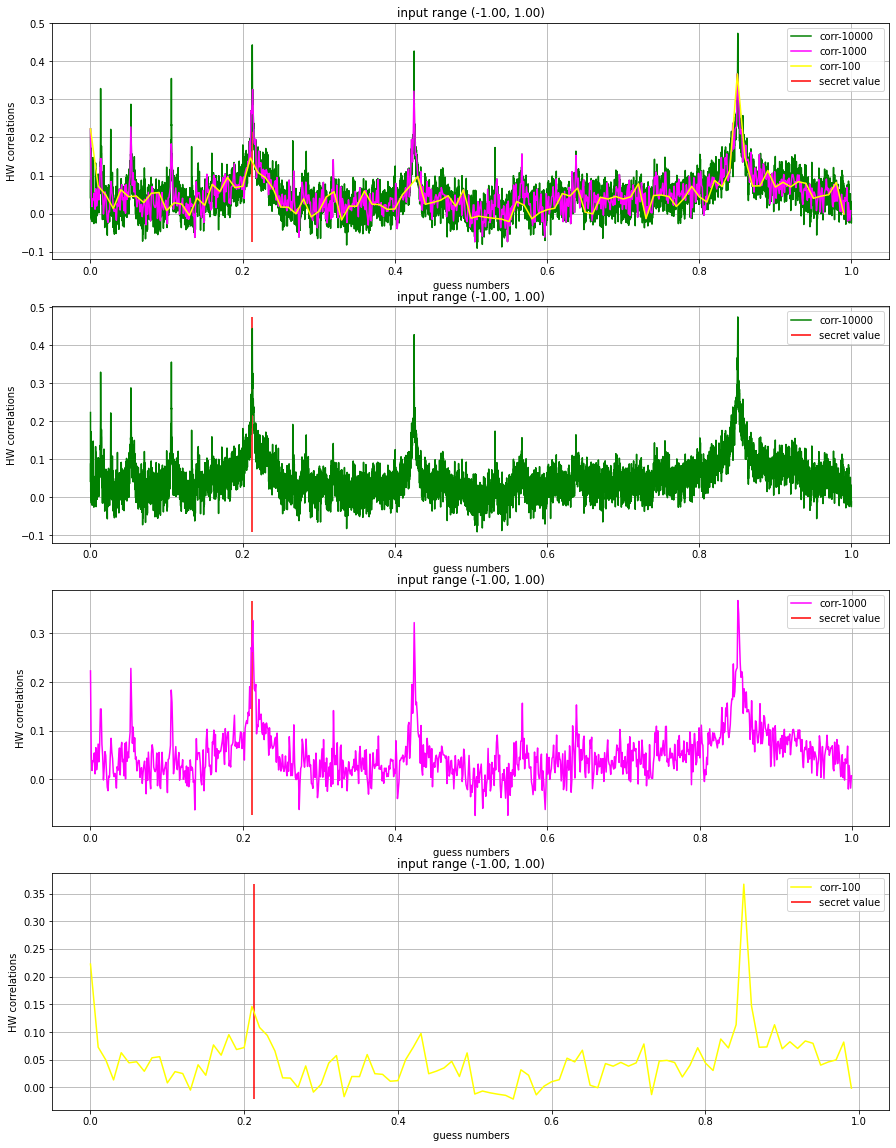

In [198]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
correlations_1.plot(ax=ax[0], label='corr-%s' % correlations_1.shape[0], color='green')
correlations.plot(ax=ax[0], label='corr-%s' % correlations.shape[0], color='magenta')
correlations_2.plot(ax=ax[0], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[0].vlines(secret_number, correlations.min(), correlations.max(), color='red', label='secret value')

correlations_1.plot(ax=ax[1], label='corr-%s' % correlations_1.shape[0], color='green')
ax[1].vlines(secret_number, correlations_1.min(), correlations_1.max(), color='red', label='secret value')

correlations.plot(ax=ax[2], label='corr-%s' % correlations.shape[0], color='magenta')
ax[2].vlines(secret_number, correlations.min(), correlations.max(), color='red', label='secret value')

correlations_2.plot(ax=ax[3], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[3].vlines(secret_number, correlations_2.min(), correlations_2.max(), color='red', label='secret value')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('guess numbers')
    a.set_ylabel('HW correlations')
    a.set_title('input range (%.02f, %.02f)' % (-10 ** input_range, 10 ** input_range))
    
plt.show()

## Correlation of mantissa

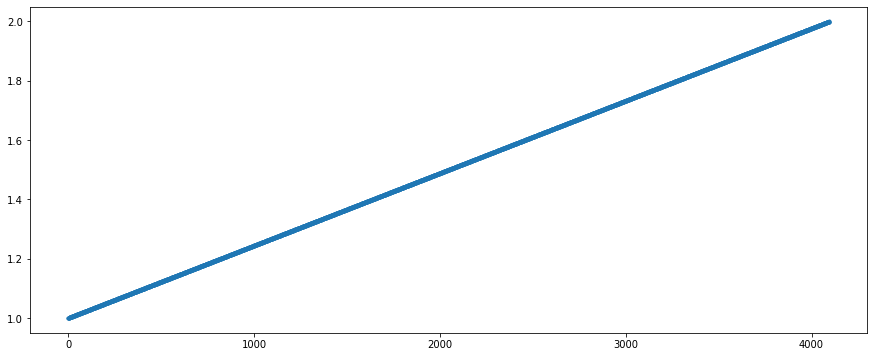

In [153]:
mantissa_nbits = 12
guess_numbers = build_guess_values(value_type='mantissa', mantissa_nbits=mantissa_nbits, guess_range=guess_range)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(15,6), marker='.')

In [7]:
mantissa_processing_func = lambda x: bin(float_to_int(x) & 0x7fffff).count('1')

In [8]:
mantisa_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers, processing_func=mantissa_processing_func)

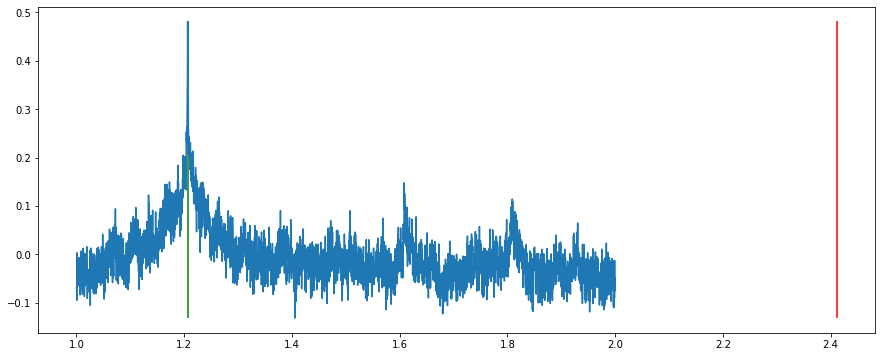

In [9]:
ax = mantisa_corr.sort_index().plot(figsize=(15,6))
ax.vlines(mantisa_corr.idxmax(), mantisa_corr.min(), mantisa_corr.max(), color='green')
ax.vlines(secret_number, mantisa_corr.min(), mantisa_corr.max(), color='red')

In [10]:
mantisa_corr.sort_values(ascending=False).iloc[:10]

1.206299    0.481165
1.206543    0.422913
1.206055    0.387552
1.206787    0.352210
1.205811    0.349734
1.207520    0.332488
1.207275    0.331160
1.207031    0.321486
1.205566    0.294644
1.205322    0.282138
dtype: float64

## Correlation exponent

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/home/tvk/programming/others/DPACv4/batina_guess_number.py:32: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]


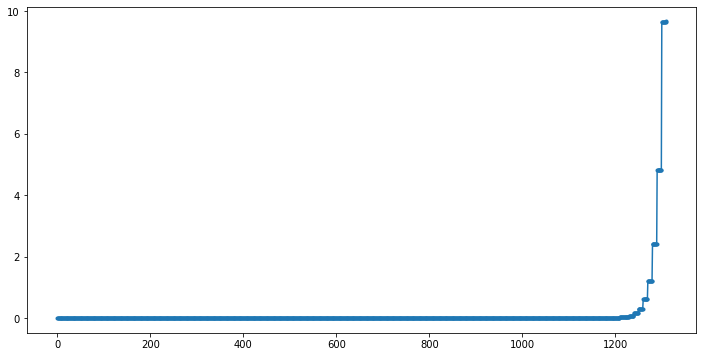

In [11]:
guess_numbers = build_guess_values(value_type='exponent', numbers=mantisa_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(12,6), marker='.')

In [12]:
mantisa_exp_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers, processing_func=None)

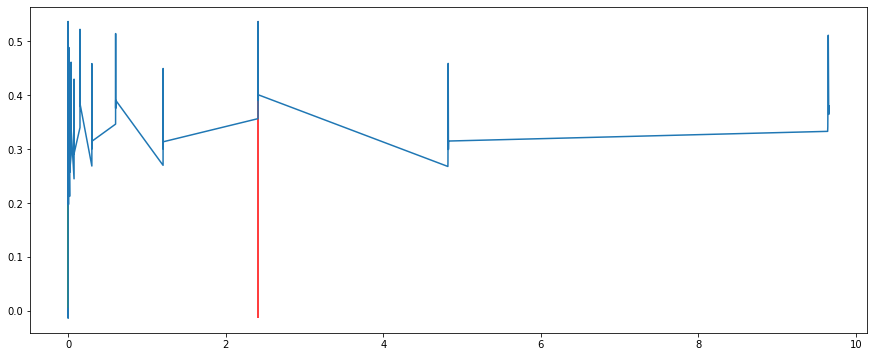

In [13]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6))
ax.vlines(mantisa_exp_corr.idxmax(), mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='green')
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red')

In [14]:
mantisa_exp_corr.sort_values(ascending=False).iloc[:10]

5.617267e-10    0.537138
1.995654e-24    0.537138
3.681332e-05    0.537138
3.045126e-29    0.537138
2.412598e+00    0.537138
8.571269e-15    0.537138
1.307872e-19    0.537138
4.646494e-34    0.537138
1.815037e-36    0.536700
3.348152e-17    0.536700
dtype: float64

## Correlation sign

array([5.61726665e-10, 1.99565401e-24, 3.68133187e-05, 3.04512635e-29,
       2.41259766e+00, 8.57126869e-15, 1.30787181e-19, 4.64649407e-34,
       1.81503675e-36, 3.34815183e-17])

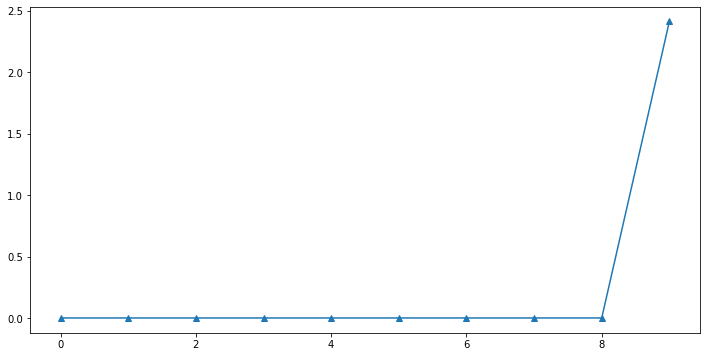

In [15]:
guess_numbers = build_guess_values(value_type='sign', numbers=mantisa_exp_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(12,6), marker='^')
guess_numbers

In [16]:
full_number_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers, processing_func=None)

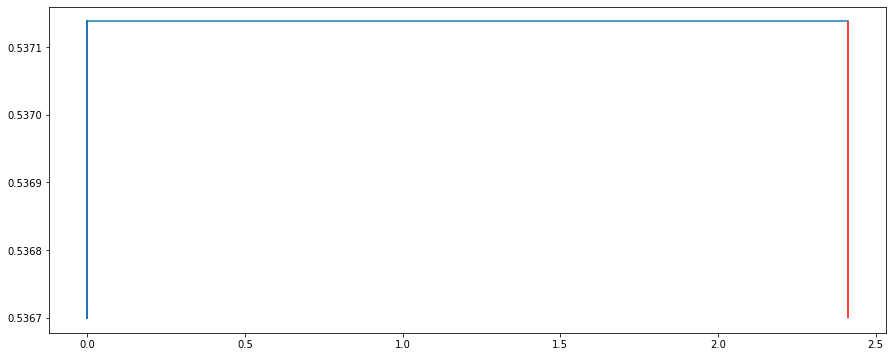

In [17]:
ax = full_number_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red')

In [18]:
full_number_corr.sort_values(ascending=False).iloc[:10]

4.646494e-34    0.537138
1.307872e-19    0.537138
8.571269e-15    0.537138
2.412598e+00    0.537138
3.045126e-29    0.537138
3.681332e-05    0.537138
1.995654e-24    0.537138
5.617267e-10    0.537138
3.348152e-17    0.536700
1.815037e-36    0.536700
dtype: float64

## Recover a secret number

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/home/tvk/programming/others/DPACv4/batina_guess_number.py:32: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]


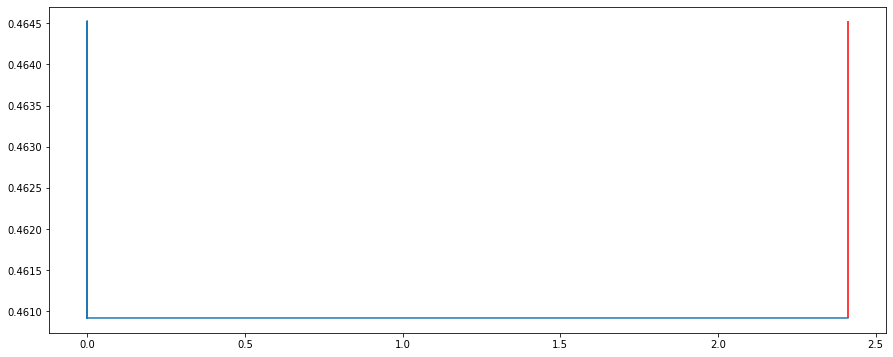

In [19]:
full_number_corr = batina_recover_weight(weight_hw=secret_hw, known_inputs=known_inputs, guess_range=guess_range)
ax = full_number_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red')

In [20]:
full_number_corr.sort_values(ascending=False).iloc[:10]

7.793946e-27    0.464521
1.437729e-07    0.464521
1.814669e-36    0.464521
3.347474e-17    0.464521
3.680587e-05    0.460920
4.645554e-34    0.460920
2.412109e+00    0.460920
5.616130e-10    0.460920
1.995250e-24    0.460920
1.307607e-19    0.460920
dtype: float64

## Analyze with noise - one number

In [21]:
def resize_known_inputs(known_inputs, new_len):
    """
    resize the known input to the new_len
    :param known_inputs: known inputs 
    :param new_len: new size of the know_inputs
    :return: the known
    """
    old_len = len(known_inputs)
    vf = np.vectorize(lambda i: known_inputs[int(i*old_len/new_len)])
    return vf(np.arange(0, new_len))

In [22]:
def add_noise_to_signal(signal, snr, freq):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :param freq: frequency of noise 
    :return: signal with noise
    """
    sig_max = signal.max()
    sig_min = signal.min()
    return pd.Series(signal).apply(lambda x: x  +
                                   np.average(np.random.normal(0.0, (sig_max-sig_min)/snr, freq)))

In [23]:
# the noise frequency is 50 times higher than HW signal frequency. Here we also increase
# the sizes of the computation with 
no_noise_secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)

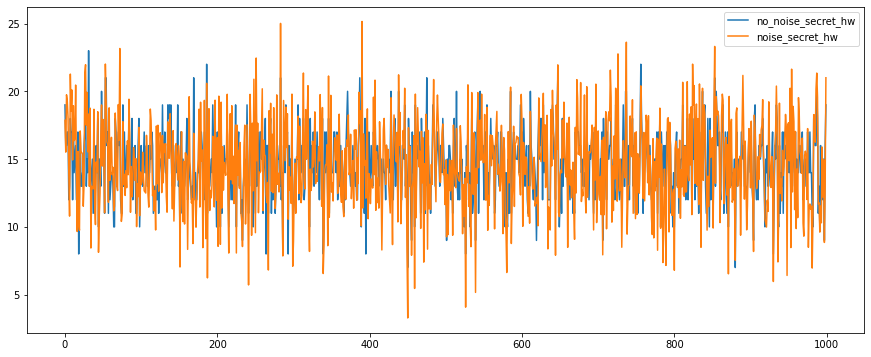

In [24]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_hw = add_noise_to_signal(signal=no_noise_secret_hw, snr=signal_to_noise_ratio, freq=200)
ax = pd.DataFrame([no_noise_secret_hw, noise_secret_hw], index=['no_noise_secret_hw', 'noise_secret_hw']).T.plot(figsize=(15,6))
ax.legend()

In [25]:
noise_correlations = compute_corr(noise_secret_hw, guess_range, known_inputs, guess_val_size)
print('secret_number =', secret_number)
noise_correlations.sort_values(ascending=False).iloc[:10]

secret_number = 2.41264


9.65    0.393454
9.66    0.244833
9.67    0.216583
2.41    0.214973
4.83    0.208997
9.58    0.208673
9.64    0.202340
9.63    0.196914
2.42    0.190015
2.44    0.184154
dtype: float64

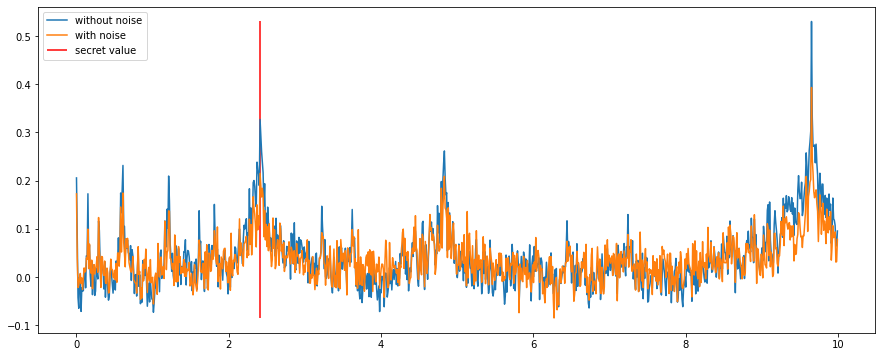

In [26]:
ax = correlations.plot(figsize=(15, 6), label='without noise')
noise_correlations.plot(ax=ax, label='with noise')
ax.vlines(secret_number, 
          min(noise_correlations.min(), correlations.min()),
          max(noise_correlations.max(), correlations.max()), 
          color='red', label='secret value')
ax.legend()

## Analyze with noise - multiple numbers

In [27]:
guess_range = (0.0, 5.0)
known_input_set = generate_known_inputs(exps=(-2,3), nsize=3000)
precision = 1e-6
n_secret_numbers = 2000
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (2000,)


In [28]:
secret_numbers_hws = {}
for idx in known_input_set.index:
    secret_numbers_hws[idx] = pd.DataFrame(
        columns=secret_numbers, 
        data=np.vectorize(hamming_weight)(np.asarray(known_input_set.loc[idx]).reshape(-1, 1) * secret_numbers))

In [29]:
secret_numbers_hws[0]

,0.736013,0.096015,0.072706,0.321501,0.609321,0.496104,0.435962,1.849823,3.822063,3.227851,...,0.905744,1.195211,0.319210,4.918234,3.677481,0.885456,2.387422,4.678435,4.607547,0.206653
0,19,17,17,16,15,16,15,20,13,11,...,20,13,13,12,12,16,16,15,11,16
1,21,18,14,20,15,16,12,15,19,21,...,19,15,20,14,20,15,19,21,16,14
2,20,16,14,15,18,18,18,17,21,21,...,19,20,20,17,20,17,24,12,10,16
3,17,18,14,18,13,16,20,14,13,16,...,18,15,17,20,18,19,13,18,14,17
4,18,16,17,14,16,19,17,19,20,21,...,18,16,13,12,18,19,21,17,11,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,15,21,18,14,15,20,18,19,13,11,...,20,19,17,15,13,15,15,9,15,20
496,15,19,15,24,20,15,18,19,16,13,...,16,21,19,14,12,17,23,14,12,17
497,15,15,18,13,22,16,15,18,11,11,...,19,21,13,14,11,17,17,14,13,15
498,18,16,17,19,24,17,20,19,12,14,...,18,18,20,11,16,18,21,14,13,17


In [30]:
SECRET_VALUE='secret value'
df_index = [INPUT_ID, LOW_VALUE, HIGH_VALUE, CORRELATION, SECRET_VALUE]

In [31]:
%%time
# start guessing... - without noise first
results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        results = pd.concat([results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[0.736013] -2 0.736013 0.736014 0.998659'
'[0.736013] -1 0.736013 0.736014 0.997238'
'[0.736013] 00 0.736013 0.736014 0.998849'
'[0.736013] 01 0.736013 0.736014 0.998412'
'[0.736013] 02 2.944053 2.944053 0.953739'
'[0.736013] 03 0.736013 0.736014 0.999269'
'[0.096015] -2 1.536239 1.536239 0.976583'
'[0.096015] -1 1.536239 1.536239 0.986542'
'[0.096015] 00 1.536239 1.536239 0.993632'
'[0.096015] 01 1.536239 1.536239 0.849618'
'[0.096015] 02 0.096015 0.096015 0.999905'
'[0.096015] 03 1.536239 1.536239 0.955045'
'[0.072706] -2 1.163292 1.163293 0.976247'
'[0.072706] -1 1.163292 1.163293 0.993077'
'[0.072706] 00 1.163292 1.163293 0.992754'
'[0.072706] 01 1.163292 1.163293 0.795644'
'[0.072706] 02 0.072706 0.072706 0.982466'
'[0.072706] 03 1.163292 1.163293 0.947451'
'[0.321501] -2 1.286005 1.286005 0.933034'
'[0.321501] -1 1.286005 1.286005 0.951523'
'[0.321501] 00 1.286005 1.286005 0.979151'
'[0.321501] 01 0.321501 0.321501 0.999587'
'[0.321501] 02 0.321501 0.321501 0.995373'
'[0.321501]

'[0.154201] 03 4.934425 4.934426 0.933440'
'[4.007424] -2 4.007424 4.007425 1.000000'
'[4.007424] -1 4.007424 4.007425 1.000000'
'[4.007424] 00 4.007424 4.007425 1.000000'
'[4.007424] 01 4.007424 4.007425 1.000000'
'[4.007424] 02 4.007424 4.007425 1.000000'
'[4.007424] 03 4.007424 4.007425 1.000000'
'[3.258666] -2 3.258667 3.258668 0.828056'
'[3.258666] -1 3.258667 3.258668 0.828352'
'[3.258666] 00 3.258667 3.258668 0.926084'
'[3.258666] 01 3.258667 3.258668 0.808209'
'[3.258666] 02 3.258667 3.258668 0.774254'
'[3.258666] 03 3.258667 3.258668 0.824817'
'[2.095098] -2 2.095098 2.095098 0.999668'
'[2.095098] -1 2.095098 2.095098 0.999400'
'[2.095098] 00 2.095098 2.095098 0.999891'
'[2.095098] 01 2.095098 2.095098 0.999628'
'[2.095098] 02 4.190196 4.190197 0.954847'
'[2.095098] 03 4.190196 4.190197 0.931012'
'[0.191074] -2 3.057184 3.057184 0.986492'
'[0.191074] -1 3.057184 3.057184 0.980440'
'[0.191074] 00 3.057184 3.057184 0.809012'
'[0.191074] 01 3.057184 3.057184 0.882671'
'[0.191074]

'[0.925782] 02 0.925781 0.925782 0.999550'
'[0.925782] 03 0.925781 0.925782 0.999038'
'[1.179895] -2 1.179894 1.179895 0.999456'
'[1.179895] -1 1.179894 1.179895 0.999317'
'[1.179895] 00 1.179894 1.179895 0.998427'
'[1.179895] 01 1.179894 1.179895 0.999447'
'[1.179895] 02 4.719577 4.719578 0.963946'
'[1.179895] 03 1.179894 1.179895 0.999446'
'[2.975157] -2 2.975157 2.975157 0.999830'
'[2.975157] -1 2.975157 2.975157 1.000000'
'[2.975157] 00 2.975157 2.975157 1.000000'
'[2.975157] 01 2.975157 2.975157 0.999453'
'[2.975157] 02 2.975157 2.975157 0.999689'
'[2.975157] 03 2.975157 2.975157 0.999836'
'[3.731974] -2 3.731973 3.731974 0.999652'
'[3.731974] -1 3.731973 3.731974 0.999693'
'[3.731974] 00 3.731973 3.731974 1.000000'
'[3.731974] 01 3.731973 3.731974 1.000000'
'[3.731974] 02 3.731973 3.731974 0.999841'
'[3.731974] 03 3.731973 3.731974 1.000000'
'[2.911806] -2 2.911806 2.911806 1.000000'
'[2.911806] -1 2.911806 2.911806 1.000000'
'[2.911806] 00 2.911806 2.911806 0.999067'
'[2.911806]

'[3.324424] 01 3.324424 3.324425 0.999882'
'[3.324424] 02 3.324424 3.324425 0.998786'
'[3.324424] 03 3.324424 3.324425 0.999842'
'[0.336162] -2 4.670166 4.670167 0.240774'
'[0.336162] -1 1.344649 1.344650 0.955213'
'[0.336162] 00 1.344649 1.344650 0.979886'
'[0.336162] 01 0.336162 0.336162 0.997457'
'[0.336162] 02 0.336162 0.336162 0.992954'
'[0.336162] 03 1.344649 1.344650 0.927878'
'[2.409324] -2 2.409323 2.409324 1.000000'
'[2.409324] -1 2.409323 2.409324 0.999836'
'[2.409324] 00 2.409323 2.409324 1.000000'
'[2.409324] 01 2.409323 2.409324 0.999698'
'[2.409324] 02 2.409323 2.409324 0.999839'
'[2.409324] 03 2.409323 2.409324 1.000000'
'[2.714310] -2 2.714310 2.714310 0.999659'
'[2.714310] -1 2.714310 2.714310 1.000000'
'[2.714310] 00 2.714310 2.714310 0.999630'
'[2.714310] 01 2.714310 2.714310 0.999710'
'[2.714310] 02 2.714310 2.714310 0.999509'
'[2.714310] 03 2.714310 2.714310 0.999836'
'[1.078610] -2 1.078610 1.078610 1.000000'
'[1.078610] -1 4.314440 4.314441 0.978426'
'[1.078610]

'[0.448988] 00 1.795952 1.795953 0.980856'
'[0.448988] 01 0.448988 0.448989 0.999085'
'[0.448988] 02 1.795952 1.795953 0.948674'
'[0.448988] 03 0.448988 0.448989 0.994559'
'[3.701884] -2 3.701884 3.701885 0.999631'
'[3.701884] -1 3.701884 3.701885 0.999486'
'[3.701884] 00 3.701884 3.701885 0.999858'
'[3.701884] 01 3.701884 3.701885 0.999867'
'[3.701884] 02 3.701884 3.701885 1.000000'
'[3.701884] 03 0.925471 0.925471 0.929288'
'[1.246994] -2 1.250352 1.250353 0.470027'
'[1.246994] -1 4.987977 4.987977 0.981318'
'[1.246994] 00 1.246994 1.246995 0.998570'
'[1.246994] 01 1.250417 1.250418 0.586088'
'[1.246994] 02 4.987977 4.987977 0.965205'
'[1.246994] 03 1.253805 1.253806 0.424798'
'[3.421598] -2 3.421597 3.421598 1.000000'
'[3.421598] -1 3.421597 3.421598 0.999412'
'[3.421598] 00 3.421597 3.421598 1.000000'
'[3.421598] 01 3.421597 3.421598 0.999646'
'[3.421598] 02 3.421597 3.421598 0.999824'
'[3.421598] 03 3.421597 3.421598 0.999845'
'[0.347418] -2 2.779341 2.779342 0.930827'
'[0.347418]

'[3.218377] -1 3.218377 3.218377 0.999837'
'[3.218377] 00 3.218377 3.218377 1.000000'
'[3.218377] 01 3.218377 3.218377 1.000000'
'[3.218377] 02 3.218377 3.218377 1.000000'
'[3.218377] 03 3.218377 3.218377 0.999825'
'[3.714081] -2 3.714081 3.714082 1.000000'
'[3.714081] -1 3.714081 3.714082 0.999829'
'[3.714081] 00 3.714081 3.714082 0.999934'
'[3.714081] 01 3.714081 3.714082 1.000000'
'[3.714081] 02 3.714081 3.714082 1.000000'
'[3.714081] 03 3.714081 3.714082 0.999658'
'[1.304395] -2 1.304395 1.304395 0.999864'
'[1.304395] -1 2.608790 2.608790 0.921607'
'[1.304395] 00 1.304395 1.304395 1.000000'
'[1.304395] 01 1.304395 1.304395 1.000000'
'[1.304395] 02 1.304395 1.304395 1.000000'
'[1.304395] 03 1.304395 1.304395 0.999513'
'[1.116694] -2 1.116693 1.116694 0.999085'
'[1.116694] -1 1.116693 1.116694 0.998174'
'[1.116694] 00 2.233387 2.233387 0.780652'
'[1.116694] 01 1.116693 1.116694 0.998839'
'[1.116694] 02 1.116693 1.116694 0.993097'
'[1.116694] 03 1.116693 1.116694 0.999535'
'[1.493223]

'[4.070886] -2 4.070886 4.070886 0.999464'
'[4.070886] -1 4.070886 4.070886 1.000000'
'[4.070886] 00 4.070886 4.070886 0.999779'
'[4.070886] 01 4.070886 4.070886 1.000000'
'[4.070886] 02 4.070886 4.070886 1.000000'
'[4.070886] 03 4.070886 4.070886 0.999672'
'[0.947583] -2 3.790330 3.790330 0.940332'
'[0.947583] -1 3.790330 3.790330 0.976128'
'[0.947583] 00 1.895165 1.895165 0.970971'
'[0.947583] 01 0.947582 0.947583 0.999244'
'[0.947583] 02 3.790330 3.790330 0.962577'
'[0.947583] 03 0.947582 0.947583 0.999201'
'[0.489875] -2 3.919001 3.919002 0.941558'
'[0.489875] -1 3.919001 3.919002 0.932006'
'[0.489875] 00 1.959500 1.959501 0.982267'
'[0.489875] 01 0.489875 0.489876 0.999195'
'[0.489875] 02 0.489875 0.489876 0.999118'
'[0.489875] 03 1.959500 1.959501 0.944595'
'[3.774710] -2 3.774710 3.774710 0.999505'
'[3.774710] -1 3.774710 3.774710 0.999159'
'[3.774710] 00 3.774710 3.774710 0.999926'
'[3.774710] 01 3.774710 3.774710 1.000000'
'[3.774710] 02 3.774710 3.774710 0.999683'
'[3.774710]

'[0.417031] 03 3.336245 3.336245 0.937053'
'[0.267274] -2 4.276379 4.276380 0.987075'
'[0.267274] -1 4.276379 4.276380 0.984664'
'[0.267274] 00 4.276379 4.276380 0.745638'
'[0.267274] 01 0.267273 0.267274 0.996427'
'[0.267274] 02 4.276379 4.276380 0.915373'
'[0.267274] 03 4.276379 4.276380 0.987008'
'[1.316268] -2 1.316268 1.316269 0.999857'
'[1.316268] -1 1.316268 1.316269 0.998685'
'[1.316268] 00 1.316268 1.316269 0.998847'
'[1.316268] 01 1.316268 1.316269 0.998960'
'[1.316268] 02 2.632537 2.632537 0.948771'
'[1.316268] 03 1.316268 1.316269 0.998002'
'[4.924823] -2 4.924822 4.924823 0.999845'
'[4.924823] -1 4.924822 4.924823 1.000000'
'[4.924823] 00 4.924822 4.924823 0.999843'
'[4.924823] 01 4.924822 4.924823 1.000000'
'[4.924823] 02 4.924822 4.924823 0.999838'
'[4.924823] 03 4.924822 4.924823 1.000000'
'[0.051237] -2 3.279170 3.279171 0.952101'
'[0.051237] -1 0.819792 0.819793 0.991533'
'[0.051237] 00 3.279170 3.279171 0.709315'
'[0.051237] 01 3.279170 3.279171 0.894404'
'[0.051237]

'[4.133836] 02 4.133835 4.133836 1.000000'
'[4.133836] 03 4.133835 4.133836 1.000000'
'[0.366695] -2 2.933563 2.933564 0.929678'
'[0.366695] -1 1.466781 1.466782 0.956456'
'[0.366695] 00 1.466781 1.466782 0.978711'
'[0.366695] 01 0.366695 0.366696 0.998991'
'[0.366695] 02 0.366695 0.366696 0.996684'
'[0.366695] 03 2.933563 2.933564 0.928903'
'[2.879861] -2 2.879860 2.879861 0.999848'
'[2.879861] -1 2.879860 2.879861 0.999636'
'[2.879861] 00 2.879860 2.879861 0.999925'
'[2.879861] 01 2.879860 2.879861 0.999459'
'[2.879861] 02 2.879860 2.879861 0.999849'
'[2.879861] 03 2.879860 2.879861 0.999845'
'[0.825320] -2 0.825319 0.825320 0.999567'
'[0.825320] -1 0.825319 0.825320 0.999521'
'[0.825320] 00 0.825319 0.825320 0.999673'
'[0.825320] 01 0.825319 0.825320 0.999727'
'[0.825320] 02 0.825319 0.825320 0.994269'
'[0.825320] 03 0.825319 0.825320 0.999722'
'[0.450074] -2 0.450073 0.450074 1.000000'
'[0.450074] -1 0.450073 0.450074 0.998995'
'[0.450074] 00 0.450073 0.450074 0.999659'
'[0.450074]

'[0.436521] 01 0.436521 0.436522 0.998619'
'[0.436521] 02 1.746085 1.746086 0.951563'
'[0.436521] 03 0.436521 0.436522 0.999854'
'[0.751115] -2 0.751115 0.751116 0.997343'
'[0.751115] -1 1.502230 1.502231 0.929064'
'[0.751115] 00 0.751115 0.751116 0.997577'
'[0.751115] 01 0.751115 0.751116 0.999220'
'[0.751115] 02 0.751115 0.751116 0.997271'
'[0.751115] 03 0.751115 0.751116 0.998555'
'[0.378732] -2 3.029854 3.029855 0.934169'
'[0.378732] -1 1.514927 1.514928 0.955775'
'[0.378732] 00 1.514927 1.514928 0.979780'
'[0.378732] 01 0.378731 0.378732 0.999333'
'[0.378732] 02 0.378731 0.378732 0.999870'
'[0.378732] 03 0.378731 0.378732 0.998353'
'[4.636644] -2 4.636644 4.636644 0.999838'
'[4.636644] -1 4.636644 4.636644 0.999809'
'[4.636644] 00 4.636644 4.636644 1.000000'
'[4.636644] 01 4.636644 4.636644 1.000000'
'[4.636644] 02 4.636644 4.636644 1.000000'
'[4.636644] 03 4.636644 4.636644 1.000000'
'[0.203909] -2 3.262547 3.262548 0.985109'
'[0.203909] -1 3.262548 3.262548 0.981639'
'[0.203909]

'[2.021230] 00 2.021230 2.021230 0.997196'
'[2.021230] 01 2.021230 2.021230 1.000000'
'[2.021230] 02 2.021230 2.021230 0.999476'
'[2.021230] 03 2.021230 2.021230 0.999502'
'[0.055214] -2 0.883424 0.883424 0.977461'
'[0.055214] -1 3.533697 3.533697 0.975313'
'[0.055214] 00 0.883424 0.883424 0.989718'
'[0.055214] 01 3.533697 3.533697 0.899517'
'[0.055214] 02 0.055214 0.055214 0.987229'
'[0.055214] 03 3.533697 3.533697 0.912770'
'[0.834893] -2 3.339571 3.339571 0.949891'
'[0.834893] -1 1.669785 1.669786 0.918230'
'[0.834893] 00 1.669785 1.669786 0.968347'
'[0.834893] 01 0.834892 0.834893 0.999827'
'[0.834893] 02 3.339571 3.339571 0.960843'
'[0.834893] 03 3.339571 3.339571 0.923109'
'[0.458534] -2 3.668270 3.668271 0.934163'
'[0.458534] -1 1.834135 1.834136 0.961026'
'[0.458534] 00 1.834135 1.834136 0.981196'
'[0.458534] 01 0.458534 0.458534 0.997425'
'[0.458534] 02 3.668270 3.668271 0.899294'
'[0.458534] 03 3.668270 3.668271 0.936920'
'[4.655859] -2 4.655858 4.655859 0.999232'
'[4.655859]

'[1.377941] -1 1.377940 1.377941 0.999696'
'[1.377941] 00 1.377940 1.377941 0.999377'
'[1.377941] 01 1.377940 1.377941 0.999759'
'[1.377941] 02 1.377940 1.377941 0.999023'
'[1.377941] 03 1.377940 1.377941 0.997000'
'[0.388267] -2 3.106140 3.106140 0.938703'
'[0.388267] -1 0.388267 0.388268 0.995746'
'[0.388267] 00 1.553070 1.553071 0.979220'
'[0.388267] 01 0.388267 0.388268 0.998528'
'[0.388267] 02 0.388267 0.388268 0.997819'
'[0.388267] 03 0.388267 0.388268 0.998716'
'[0.171539] -2 0.000000 0.000001 0.253858'
'[0.171539] -1 2.744616 2.744617 0.981695'
'[0.171539] 00 2.744616 2.744617 0.825559'
'[0.171539] 01 2.744616 2.744617 0.886131'
'[0.171539] 02 0.171538 0.171539 0.999887'
'[0.171539] 03 2.744616 2.744617 0.982874'
'[0.218588] -2 0.874352 0.874353 0.965182'
'[0.218588] -1 3.497411 3.497412 0.983022'
'[0.218588] 00 3.497411 3.497412 0.770336'
'[0.218588] 01 0.218588 0.218589 0.999836'
'[0.218588] 02 0.218588 0.218589 0.999858'
'[0.218588] 03 3.497411 3.497412 0.983790'
'[0.686327]

'[1.305218] -2 1.305218 1.305218 0.999241'
'[1.305218] -1 1.305218 1.305218 0.994468'
'[1.305218] 00 1.305218 1.305218 0.999377'
'[1.305218] 01 1.305218 1.305218 0.999566'
'[1.305218] 02 2.610436 2.610437 0.948630'
'[1.305218] 03 1.305218 1.305218 0.996974'
'[1.502790] -2 1.502790 1.502790 0.998554'
'[1.502790] -1 1.502790 1.502790 0.999679'
'[1.502790] 00 1.502790 1.502790 0.999683'
'[1.502790] 01 1.502790 1.502790 0.999298'
'[1.502790] 02 1.502790 1.502790 0.999838'
'[1.502790] 03 1.502790 1.502790 0.999840'
'[0.462294] -2 0.462293 0.462294 0.997770'
'[0.462294] -1 0.462293 0.462294 0.999243'
'[0.462294] 00 0.462293 0.462294 0.993481'
'[0.462294] 01 0.462293 0.462294 0.996683'
'[0.462294] 02 0.462293 0.462294 0.998082'
'[0.462294] 03 0.462293 0.462294 0.998211'
'[1.481658] -2 1.481657 1.481658 1.000000'
'[1.481658] -1 1.481657 1.481658 0.999837'
'[1.481658] 00 1.481657 1.481658 1.000000'
'[1.481658] 01 1.481657 1.481658 0.999678'
'[1.481658] 02 2.963315 2.963315 0.954546'
'[1.481658]

'[3.144834] 03 3.144834 3.144835 1.000000'
'[0.783325] -2 0.391662 0.391663 0.961981'
'[0.783325] -1 3.133299 3.133299 0.971110'
'[0.783325] 00 0.783324 0.783325 0.999336'
'[0.783325] 01 0.783324 0.783325 0.999139'
'[0.783325] 02 0.783324 0.783325 0.998768'
'[0.783325] 03 0.783324 0.783325 0.999730'
'[4.042933] -2 4.042969 4.042970 0.637567'
'[4.042933] -1 4.042933 4.042934 1.000000'
'[4.042933] 00 4.042933 4.042934 1.000000'
'[4.042933] 01 4.042976 4.042976 0.742020'
'[4.042933] 02 4.042969 4.042969 0.599106'
'[4.042933] 03 4.042970 4.042971 0.633777'
'[0.238337] -2 3.813399 3.813400 0.986624'
'[0.238337] -1 3.813399 3.813400 0.982907'
'[0.238337] 00 3.813399 3.813400 0.772288'
'[0.238337] 01 0.238337 0.238338 0.992564'
'[0.238337] 02 0.238337 0.238338 0.996319'
'[0.238337] 03 3.813399 3.813400 0.984149'
'[0.321948] -2 1.287793 1.287794 0.927247'
'[0.321948] -1 1.287793 1.287794 0.950602'
'[0.321948] 00 1.287793 1.287794 0.975018'
'[0.321948] 01 0.321948 0.321949 0.999674'
'[0.321948]

'[1.671319] 02 1.671319 1.671320 1.000000'
'[1.671319] 03 1.671319 1.671320 1.000000'
'[2.064477] -2 2.064477 2.064478 0.999839'
'[2.064477] -1 2.064477 2.064478 0.999706'
'[2.064477] 00 2.064477 2.064478 0.999765'
'[2.064477] 01 2.064477 2.064478 1.000000'
'[2.064477] 02 2.064477 2.064478 0.999654'
'[2.064477] 03 2.064477 2.064478 0.999729'
'[2.627248] -2 2.627248 2.627248 0.999675'
'[2.627248] -1 2.627248 2.627248 0.999686'
'[2.627248] 00 2.627248 2.627248 1.000000'
'[2.627248] 01 2.627248 2.627248 1.000000'
'[2.627248] 02 2.627248 2.627248 0.999852'
'[2.627248] 03 2.627248 2.627248 1.000000'
'[2.435291] -2 2.435291 2.435291 0.999689'
'[2.435291] -1 2.435291 2.435291 0.999830'
'[2.435291] 00 2.435291 2.435291 0.999918'
'[2.435291] 01 2.435291 2.435291 0.999059'
'[2.435291] 02 2.435291 2.435291 0.999844'
'[2.435291] 03 2.435291 2.435291 0.999264'
'[0.404352] -2 3.234818 3.234819 0.932650'
'[0.404352] -1 1.617409 1.617410 0.957908'
'[0.404352] 00 0.404352 0.404353 0.996283'
'[0.404352]

'[0.692297] 01 0.692297 0.692297 0.999810'
'[0.692297] 02 0.692297 0.692297 0.998611'
'[0.692297] 03 0.692297 0.692297 0.998650'
'[2.279170] -2 2.279170 2.279170 1.000000'
'[2.279170] -1 2.279170 2.279170 1.000000'
'[2.279170] 00 2.279170 2.279170 1.000000'
'[2.279170] 01 2.279170 2.279170 1.000000'
'[2.279170] 02 4.558340 4.558340 0.963989'
'[2.279170] 03 2.279170 2.279170 1.000000'
'[0.630897] -2 2.523586 2.523587 0.941777'
'[0.630897] -1 2.523586 2.523587 0.969273'
'[0.630897] 00 2.523586 2.523587 0.800696'
'[0.630897] 01 0.630896 0.630897 0.996986'
'[0.630897] 02 2.523586 2.523587 0.955486'
'[0.630897] 03 2.523586 2.523587 0.930297'
'[1.237306] -2 1.237306 1.237307 0.999862'
'[1.237306] -1 1.237306 1.237307 1.000000'
'[1.237306] 00 1.237306 1.237307 1.000000'
'[1.237306] 01 1.237306 1.237307 1.000000'
'[1.237306] 02 1.237306 1.237307 1.000000'
'[1.237306] 03 1.237306 1.237307 1.000000'
'[1.640897] -2 1.640897 1.640897 1.000000'
'[1.640897] -1 1.640897 1.640897 1.000000'
'[1.640897]

'[0.076325] 00 1.221197 1.221197 0.993974'
'[0.076325] 01 4.884788 4.884788 0.919803'
'[0.076325] 02 0.076324 0.076325 0.995685'
'[0.076325] 03 4.884788 4.884788 0.937346'
'[0.032018] -2 0.512288 0.512288 0.968242'
'[0.032018] -1 0.512288 0.512288 0.986668'
'[0.032018] 00 0.512288 0.512288 0.982519'
'[0.032018] 01 0.032018 0.032018 0.992291'
'[0.032018] 02 0.032018 0.032018 0.997206'
'[0.032018] 03 0.032018 0.032018 0.993266'
'[1.726454] -2 1.726453 1.726454 0.999850'
'[1.726454] -1 1.726453 1.726454 0.999711'
'[1.726454] 00 1.726453 1.726454 0.998937'
'[1.726454] 01 1.726453 1.726454 0.999009'
'[1.726454] 02 1.726453 1.726454 0.999676'
'[1.726454] 03 1.726453 1.726454 1.000000'
'[0.877120] -2 0.877119 0.877120 1.000000'
'[0.877120] -1 0.877119 0.877120 0.999666'
'[0.877120] 00 1.754239 1.754240 0.966632'
'[0.877120] 01 0.877119 0.877120 0.999910'
'[0.877120] 02 3.508479 3.508480 0.961244'
'[0.877120] 03 0.877119 0.877120 1.000000'
'[0.060922] -2 0.974754 0.974755 0.975708'
'[0.060922]

'[0.268443] -1 4.295094 4.295095 0.983476'
'[0.268443] 00 4.295094 4.295095 0.756440'
'[0.268443] 01 0.268443 0.268444 0.999286'
'[0.268443] 02 4.295094 4.295095 0.914399'
'[0.268443] 03 0.268443 0.268444 0.995137'
'[0.028143] -2 0.028142 0.028143 0.984187'
'[0.028143] -1 0.028142 0.028143 0.974564'
'[0.028143] 00 0.028142 0.028143 0.983271'
'[0.028143] 01 0.001758 0.001759 0.792492'
'[0.028143] 02 0.028142 0.028143 0.991965'
'[0.028143] 03 0.028142 0.028143 0.983600'
'[0.918445] -2 3.673781 3.673781 0.938926'
'[0.918445] -1 3.673781 3.673781 0.973590'
'[0.918445] 00 0.918445 0.918446 1.000000'
'[0.918445] 01 0.918445 0.918446 0.999539'
'[0.918445] 02 0.918445 0.918446 1.000000'
'[0.918445] 03 3.673781 3.673781 0.918868'
'[0.731831] -2 2.927325 2.927325 0.943403'
'[0.731831] -1 2.927325 2.927325 0.967430'
'[0.731831] 00 0.731831 0.731832 0.999835'
'[0.731831] 01 0.731831 0.731832 0.999815'
'[0.731831] 02 0.731831 0.731832 1.000000'
'[0.731831] 03 0.731831 0.731832 1.000000'
'[1.815499]

'[4.621315] -2 4.621315 4.621316 1.000000'
'[4.621315] -1 4.621315 4.621316 1.000000'
'[4.621315] 00 4.621315 4.621316 0.999922'
'[4.621315] 01 4.621315 4.621316 0.999598'
'[4.621315] 02 4.621315 4.621316 1.000000'
'[4.621315] 03 4.621315 4.621316 1.000000'
'[2.888308] -2 2.888308 2.888308 0.999834'
'[2.888308] -1 2.888308 2.888308 1.000000'
'[2.888308] 00 2.888308 2.888308 1.000000'
'[2.888308] 01 2.888308 2.888308 0.998371'
'[2.888308] 02 2.888308 2.888308 0.999323'
'[2.888308] 03 2.888308 2.888308 0.999317'
'[1.820683] -2 1.820682 1.820683 0.999846'
'[1.820683] -1 1.820682 1.820683 0.999224'
'[1.820683] 00 1.820682 1.820683 0.999007'
'[1.820683] 01 1.820682 1.820683 0.999288'
'[1.820683] 02 1.820682 1.820683 0.999683'
'[1.820683] 03 1.820682 1.820683 1.000000'
'[0.420879] -2 0.841759 0.841759 0.943864'
'[0.420879] -1 1.683518 1.683518 0.959626'
'[0.420879] 00 1.683518 1.683518 0.981236'
'[0.420879] 01 0.420879 0.420880 0.998385'
'[0.420879] 02 0.420879 0.420880 0.997584'
'[0.420879]

'[0.543896] 03 0.543895 0.543896 0.996808'
'[4.010361] -2 4.010361 4.010361 0.999853'
'[4.010361] -1 4.010361 4.010361 1.000000'
'[4.010361] 00 4.010361 4.010361 0.999926'
'[4.010361] 01 4.010361 4.010361 1.000000'
'[4.010361] 02 4.010361 4.010361 1.000000'
'[4.010361] 03 4.010361 4.010361 0.999833'
'[0.514869] -2 2.059476 2.059477 0.935962'
'[0.514869] -1 2.059476 2.059477 0.957117'
'[0.514869] 00 2.059476 2.059477 0.913526'
'[0.514869] 01 0.514869 0.514870 0.999189'
'[0.514869] 02 4.118953 4.118953 0.889557'
'[0.514869] 03 4.118953 4.118953 0.943115'
'[0.001032] -2 4.228684 4.228685 0.988808'
'[0.001032] -1 4.228684 4.228685 0.935238'
'[0.001032] 00 1.057171 1.057171 0.972692'
'[0.001032] 01 0.264292 0.264293 0.906759'
'[0.001032] 02 4.228684 4.228685 0.994405'
'[0.001032] 03 4.228684 4.228685 0.989852'
'[2.061134] -2 2.061134 2.061135 0.998551'
'[2.061134] -1 2.061134 2.061135 0.999847'
'[2.061134] 00 2.061134 2.061135 0.999782'
'[2.061134] 01 2.061134 2.061135 1.000000'
'[2.061134]

'[0.586463] 02 4.691707 4.691708 0.901424'
'[0.586463] 03 2.345853 2.345854 0.937451'
'[0.172869] -2 2.765899 2.765899 0.984060'
'[0.172869] -1 2.765899 2.765899 0.982290'
'[0.172869] 00 2.765899 2.765899 0.814493'
'[0.172869] 01 2.765899 2.765899 0.873930'
'[0.172869] 02 0.172868 0.172869 0.995281'
'[0.172869] 03 2.765899 2.765899 0.980395'
'[0.803312] -2 3.213249 3.213250 0.950658'
'[0.803312] -1 3.213249 3.213250 0.971775'
'[0.803312] 00 3.213249 3.213250 0.700956'
'[0.803312] 01 0.803312 0.803313 0.999902'
'[0.803312] 02 3.213249 3.213250 0.960588'
'[0.803312] 03 3.213249 3.213250 0.922337'
'[0.835205] -2 3.340821 3.340822 0.945169'
'[0.835205] -1 0.003262 0.003263 0.781190'
'[0.835205] 00 0.835205 0.835206 0.999843'
'[0.835205] 01 0.835205 0.835206 0.999122'
'[0.835205] 02 0.835205 0.835206 0.999826'
'[0.835205] 03 3.340821 3.340822 0.925071'
'[0.435131] -2 0.435131 0.435132 0.999672'
'[0.435131] -1 1.740525 1.740525 0.958207'
'[0.435131] 00 1.740525 1.740525 0.982273'
'[0.435131]

'[2.091898] 01 2.091898 2.091898 0.999480'
'[2.091898] 02 2.091898 2.091898 0.999835'
'[2.091898] 03 2.091898 2.091898 0.999556'
'[0.147434] -2 2.358936 2.358937 0.980658'
'[0.147434] -1 2.358936 2.358937 0.980114'
'[0.147434] 00 2.358936 2.358937 0.865374'
'[0.147434] 01 2.358936 2.358937 0.861469'
'[0.147434] 02 0.147433 0.147434 0.995937'
'[0.147434] 03 2.358936 2.358937 0.970342'
'[0.724733] -2 0.724733 0.724733 0.998605'
'[0.724733] -1 0.724733 0.724733 0.992771'
'[0.724733] 00 0.724733 0.724733 0.996970'
'[0.724733] 01 0.724733 0.724733 0.998814'
'[0.724733] 02 0.724733 0.724733 0.998539'
'[0.724733] 03 0.724733 0.724733 0.997733'
'[4.541294] -2 4.541294 4.541295 1.000000'
'[4.541294] -1 4.541294 4.541295 1.000000'
'[4.541294] 00 4.541294 4.541295 1.000000'
'[4.541294] 01 4.541294 4.541295 1.000000'
'[4.541294] 02 4.541294 4.541295 0.999838'
'[4.541294] 03 4.541294 4.541295 1.000000'
'[2.842197] -2 2.842197 2.842197 0.999827'
'[2.842197] -1 2.842197 2.842197 0.999691'
'[2.842197]

'[4.968390] 00 4.968389 4.968390 0.999918'
'[4.968390] 01 4.968389 4.968390 1.000000'
'[4.968390] 02 4.968389 4.968390 1.000000'
'[4.968390] 03 4.968389 4.968390 1.000000'
'[3.281948] -2 3.281947 3.281948 0.998424'
'[3.281948] -1 3.281947 3.281948 1.000000'
'[3.281948] 00 3.281947 3.281948 0.999928'
'[3.281948] 01 3.281947 3.281948 1.000000'
'[3.281948] 02 3.281947 3.281948 1.000000'
'[3.281948] 03 3.281947 3.281948 0.999698'
'[0.044182] -2 2.827623 2.827623 0.937187'
'[0.044182] -1 2.827623 2.827623 0.976156'
'[0.044182] 00 2.827623 2.827623 0.716247'
'[0.044182] 01 2.827623 2.827623 0.869802'
'[0.044182] 02 0.044181 0.044182 0.986921'
'[0.044182] 03 2.827623 2.827623 0.904243'
'[4.066628] -2 4.066628 4.066629 1.000000'
'[4.066628] -1 4.066628 4.066629 0.999841'
'[4.066628] 00 4.066628 4.066629 0.999929'
'[4.066628] 01 4.066628 4.066629 0.999853'
'[4.066628] 02 4.066628 4.066629 0.999661'
'[4.066628] 03 4.066628 4.066629 1.000000'
'[0.342372] -2 2.738972 2.738973 0.929199'
'[0.342372]

'[0.190362] -1 3.045788 3.045788 0.983182'
'[0.190362] 00 3.045788 3.045788 0.805418'
'[0.190362] 01 3.045788 3.045788 0.877841'
'[0.190362] 02 0.190362 0.190362 0.995987'
'[0.190362] 03 0.190362 0.190362 0.991860'
'[2.098643] -2 2.098643 2.098643 0.998145'
'[2.098643] -1 0.131165 0.131165 0.982752'
'[2.098643] 00 2.098643 2.098643 0.999780'
'[2.098643] 01 2.098643 2.098643 0.999463'
'[2.098643] 02 2.098643 2.098643 0.999121'
'[2.098643] 03 2.098643 2.098643 0.998015'
'[0.171804] -2 0.171803 0.171804 0.979868'
'[0.171804] -1 2.748857 2.748857 0.981388'
'[0.171804] 00 2.748857 2.748857 0.814240'
'[0.171804] 01 2.748857 2.748857 0.879465'
'[0.171804] 02 0.171803 0.171804 0.987054'
'[0.171804] 03 0.171803 0.171804 0.989361'
'[1.017049] -2 1.017048 1.017049 0.999468'
'[1.017049] -1 4.068195 4.068196 0.977164'
'[1.017049] 00 2.034097 2.034098 0.922667'
'[1.017049] 01 1.017048 1.017049 0.999412'
'[1.017049] 02 4.068195 4.068196 0.961016'
'[1.017049] 03 1.017048 1.017049 0.999180'
'[3.411714]

'[2.550288] -2 2.550288 2.550288 0.999296'
'[2.550288] -1 2.550288 2.550288 1.000000'
'[2.550288] 00 2.550288 2.550288 0.999932'
'[2.550288] 01 2.550288 2.550288 0.999567'
'[2.550288] 02 2.550288 2.550288 0.999506'
'[2.550288] 03 2.550288 2.550288 0.999667'
'[0.053941] -2 0.863058 0.863059 0.980525'
'[0.053941] -1 0.863058 0.863059 0.989892'
'[0.053941] 00 0.863058 0.863059 0.988656'
'[0.053941] 01 3.452234 3.452234 0.899954'
'[0.053941] 02 0.053941 0.053942 0.988152'
'[0.053941] 03 0.863058 0.863059 0.933626'
'[1.104415] -2 1.104415 1.104416 1.000000'
'[1.104415] -1 1.104415 1.104416 1.000000'
'[1.104415] 00 2.208830 2.208831 0.784097'
'[1.104415] 01 1.104415 1.104416 0.999898'
'[1.104415] 02 4.417661 4.417661 0.961869'
'[1.104415] 03 4.417661 4.417661 0.937495'
'[0.709088] -2 2.836352 2.836353 0.941358'
'[0.709088] -1 2.836352 2.836353 0.971050'
'[0.709088] 00 2.836352 2.836353 0.729618'
'[0.709088] 01 0.709088 0.709088 0.999511'
'[0.709088] 02 2.836352 2.836353 0.949228'
'[0.709088]

'[2.539962] 03 2.539962 2.539963 1.000000'
'[0.260733] -2 4.171721 4.171722 0.986825'
'[0.260733] -1 4.171721 4.171722 0.983455'
'[0.260733] 00 4.171721 4.171722 0.749291'
'[0.260733] 01 0.260732 0.260733 0.995938'
'[0.260733] 02 0.260732 0.260733 0.997544'
'[0.260733] 03 4.171721 4.171722 0.986338'
'[0.372161] -2 0.372161 0.372161 0.997227'
'[0.372161] -1 1.488643 1.488644 0.958733'
'[0.372161] 00 1.488643 1.488644 0.980567'
'[0.372161] 01 0.372161 0.372161 0.999068'
'[0.372161] 02 1.488643 1.488644 0.940964'
'[0.372161] 03 2.977287 2.977287 0.920103'
'[0.052349] -2 0.837588 0.837588 0.983053'
'[0.052349] -1 0.837588 0.837588 0.990028'
'[0.052349] 00 0.837588 0.837588 0.986799'
'[0.052349] 01 3.350351 3.350351 0.885736'
'[0.052349] 02 0.052349 0.052350 0.982842'
'[0.052349] 03 0.837588 0.837588 0.923512'
'[0.370555] -2 2.964436 2.964437 0.933478'
'[0.370555] -1 2.964436 2.964437 0.922162'
'[0.370555] 00 1.482218 1.482219 0.979205'
'[0.370555] 01 0.370554 0.370555 0.999123'
'[0.370555]

'[0.292651] 02 4.682413 4.682414 0.914408'
'[0.292651] 03 4.682413 4.682414 0.985478'
'[0.690207] -2 2.760828 2.760829 0.947196'
'[0.690207] -1 2.760828 2.760829 0.967903'
'[0.690207] 00 2.760828 2.760829 0.676776'
'[0.690207] 01 0.690207 0.690207 0.998687'
'[0.690207] 02 2.760828 2.760829 0.956065'
'[0.690207] 03 0.690207 0.690207 0.997706'
'[2.322831] -2 2.322831 2.322832 0.998522'
'[2.322831] -1 2.322831 2.322832 1.000000'
'[2.322831] 00 2.322831 2.322832 0.999832'
'[2.322831] 01 2.322831 2.322832 0.999733'
'[2.322831] 02 0.000000 0.000001 0.225549'
'[2.322831] 03 2.322831 2.322832 0.999516'
'[0.634626] -2 2.538506 2.538506 0.947713'
'[0.634626] -1 2.538506 2.538506 0.965766'
'[0.634626] 00 2.538506 2.538506 0.791692'
'[0.634626] 01 0.634626 0.634627 0.999497'
'[0.634626] 02 2.538506 2.538506 0.950212'
'[0.634626] 03 2.538506 2.538506 0.937661'
'[0.122873] -2 1.965963 1.965964 0.979927'
'[0.122873] -1 1.965963 1.965964 0.982655'
'[0.122873] 00 1.965963 1.965964 0.996173'
'[0.122873]

'[0.446726] 01 0.446725 0.446726 0.998427'
'[0.446726] 02 1.786903 1.786903 0.944841'
'[0.446726] 03 3.573806 3.573806 0.932422'
'[0.365688] -2 0.365688 0.365688 0.997856'
'[0.365688] -1 1.462751 1.462752 0.956233'
'[0.365688] 00 1.462751 1.462752 0.979056'
'[0.365688] 01 0.365688 0.365688 0.999309'
'[0.365688] 02 1.462751 1.462752 0.942070'
'[0.365688] 03 2.925502 2.925503 0.932965'
'[0.177459] -2 2.839341 2.839342 0.982821'
'[0.177459] -1 2.839341 2.839342 0.984281'
'[0.177459] 00 2.839341 2.839342 0.817869'
'[0.177459] 01 2.839341 2.839342 0.868830'
'[0.177459] 02 0.177459 0.177459 0.999884'
'[0.177459] 03 2.839341 2.839342 0.983358'
'[0.429841] -2 0.429840 0.429841 0.998095'
'[0.429841] -1 0.429840 0.429841 0.997529'
'[0.429841] 00 1.719362 1.719363 0.981935'
'[0.429841] 01 0.429840 0.429841 0.999011'
'[0.429841] 02 3.438725 3.438725 0.890071'
'[0.429841] 03 3.438725 3.438725 0.936962'
'[0.281227] -2 4.499632 4.499632 0.987093'
'[0.281227] -1 4.499632 4.499632 0.986485'
'[0.281227]

'[0.130816] 00 2.093055 2.093055 0.930133'
'[0.130816] 01 4.186109 4.186110 0.844455'
'[0.130816] 02 0.130816 0.130816 0.993162'
'[0.130816] 03 0.130816 0.130816 0.987014'
'[4.074739] -2 4.074739 4.074740 0.999834'
'[4.074739] -1 4.074739 4.074740 0.999657'
'[4.074739] 00 4.074739 4.074740 0.999711'
'[4.074739] 01 4.074739 4.074740 0.999594'
'[4.074739] 02 4.074739 4.074740 0.999696'
'[4.074739] 03 4.074739 4.074740 0.999323'
'[0.601204] -2 4.809628 4.809629 0.935660'
'[0.601204] -1 4.809628 4.809629 0.936837'
'[0.601204] 00 2.404814 2.404814 0.812577'
'[0.601204] 01 0.601203 0.601204 0.999909'
'[0.601204] 02 2.404814 2.404814 0.949995'
'[0.601204] 03 0.601203 0.601204 0.999299'
'[0.843959] -2 3.375837 3.375837 0.951053'
'[0.843959] -1 3.375837 3.375837 0.975062'
'[0.843959] 00 0.843959 0.843959 0.997257'
'[0.843959] 01 0.843959 0.843959 0.999905'
'[0.843959] 02 0.843959 0.843959 1.000000'
'[0.843959] 03 3.375837 3.375837 0.928012'
'[1.449193] -2 1.449193 1.449193 0.999548'
'[1.449193]

'[0.528556] -1 2.114222 2.114223 0.963884'
'[0.528556] 00 2.114222 2.114223 0.891752'
'[0.528556] 01 0.528556 0.528556 0.998578'
'[0.528556] 02 2.114222 2.114223 0.938422'
'[0.528556] 03 2.114222 2.114223 0.947805'
'[3.838189] -2 3.838188 3.838189 1.000000'
'[3.838189] -1 3.838188 3.838189 1.000000'
'[3.838189] 00 3.838188 3.838189 1.000000'
'[3.838189] 01 3.838188 3.838189 1.000000'
'[3.838189] 02 3.838188 3.838189 1.000000'
'[3.838189] 03 3.838188 3.838189 1.000000'
'[0.914836] -2 3.659343 3.659343 0.932239'
'[0.914836] -1 3.659343 3.659343 0.971268'
'[0.914836] 00 1.829671 1.829672 0.967861'
'[0.914836] 01 0.914835 0.914836 0.999512'
'[0.914836] 02 3.659343 3.659343 0.960105'
'[0.914836] 03 0.914835 0.914836 0.999707'
'[0.104177] -2 1.666828 1.666829 0.978085'
'[0.104177] -1 1.666828 1.666829 0.983677'
'[0.104177] 00 1.666828 1.666829 0.994586'
'[0.104177] 01 3.333657 3.333658 0.866602'
'[0.104177] 02 0.104176 0.104177 0.999337'
'[0.104177] 03 3.333657 3.333658 0.898411'
'[1.253370]

'[3.438367] -2 3.438367 3.438367 1.000000'
'[3.438367] -1 3.438367 3.438367 0.997436'
'[3.438367] 00 3.438367 3.438367 0.999426'
'[3.438367] 01 3.438367 3.438367 1.000000'
'[3.438367] 02 3.438367 3.438367 0.999832'
'[3.438367] 03 3.438367 3.438367 0.999682'
'[4.481927] -2 4.481927 4.481927 0.999705'
'[4.481927] -1 4.481927 4.481927 0.999668'
'[4.481927] 00 4.481927 4.481927 0.999926'
'[4.481927] 01 4.481927 4.481927 1.000000'
'[4.481927] 02 4.481927 4.481927 1.000000'
'[4.481927] 03 4.481927 4.481927 1.000000'
'[0.249329] -2 3.989271 3.989272 0.986183'
'[0.249329] -1 3.989271 3.989272 0.982915'
'[0.249329] 00 3.989271 3.989272 0.739497'
'[0.249329] 01 0.249329 0.249330 0.999843'
'[0.249329] 02 0.249329 0.249330 0.996381'
'[0.249329] 03 3.989271 3.989272 0.985884'
'[1.125062] -2 1.125062 1.125063 1.000000'
'[1.125062] -1 1.125062 1.125063 1.000000'
'[1.125062] 00 1.125062 1.125063 0.999833'
'[1.125062] 01 1.125062 1.125063 1.000000'
'[1.125062] 02 1.125062 1.125063 0.999445'
'[1.125062]

'[0.501245] 03 4.009958 4.009959 0.943921'
'[1.605813] -2 3.211625 3.211626 0.873980'
'[1.605813] -1 3.211625 3.211626 0.915850'
'[1.605813] 00 1.605812 1.605813 0.999074'
'[1.605813] 01 1.605812 1.605813 0.999255'
'[1.605813] 02 3.211625 3.211626 0.954863'
'[1.605813] 03 1.605812 1.605813 0.998737'
'[0.203119] -2 0.812477 0.812477 0.974268'
'[0.203119] -1 3.249909 3.249910 0.981047'
'[0.203119] 00 3.249909 3.249910 0.800005'
'[0.203119] 01 3.249909 3.249910 0.880212'
'[0.203119] 02 3.249909 3.249910 0.892634'
'[0.203119] 03 3.249909 3.249910 0.981619'
'[0.185838] -2 2.973402 2.973403 0.982867'
'[0.185838] -1 2.973402 2.973403 0.981256'
'[0.185838] 00 2.973402 2.973403 0.760371'
'[0.185838] 01 0.185837 0.185838 0.984916'
'[0.185838] 02 0.185837 0.185838 0.993167'
'[0.185838] 03 2.973402 2.973403 0.983150'
'[0.458372] -2 0.458371 0.458372 0.998035'
'[0.458372] -1 1.833486 1.833487 0.959687'
'[0.458372] 00 1.833486 1.833487 0.981547'
'[0.458372] 01 0.458371 0.458372 0.999288'
'[0.458372]

'[0.586990] 02 0.586990 0.586990 0.997110'
'[0.586990] 03 0.586990 0.586990 0.998582'
'[0.378895] -2 0.757791 0.757791 0.964373'
'[0.378895] -1 1.515582 1.515582 0.956962'
'[0.378895] 00 1.515582 1.515582 0.981285'
'[0.378895] 01 0.378895 0.378896 0.998190'
'[0.378895] 02 0.378895 0.378896 0.999114'
'[0.378895] 03 1.515582 1.515582 0.933157'
'[3.550301] -2 3.550301 3.550302 0.997607'
'[3.550301] -1 3.550301 3.550302 0.999822'
'[3.550301] 00 3.550301 3.550302 0.999924'
'[3.550301] 01 3.550301 3.550302 1.000000'
'[3.550301] 02 3.550301 3.550302 0.999824'
'[3.550301] 03 3.550301 3.550302 0.999830'
'[0.619300] -2 0.619299 0.619300 0.997836'
'[0.619300] -1 0.619299 0.619300 0.999839'
'[0.619300] 00 0.619299 0.619300 0.998030'
'[0.619300] 01 0.619299 0.619300 0.999904'
'[0.619300] 02 0.619299 0.619300 0.998921'
'[0.619300] 03 0.619299 0.619300 0.999608'
'[0.738651] -2 0.738651 0.738652 0.999851'
'[0.738651] -1 0.738651 0.738652 0.999201'
'[0.738651] 00 2.954605 2.954606 0.678603'
'[0.738651]

'[0.105470] 01 3.375025 3.375026 0.868276'
'[0.105470] 02 1.687512 1.687513 0.827760'
'[0.105470] 03 1.687512 1.687513 0.952697'
'[2.817291] -2 2.817290 2.817291 1.000000'
'[2.817291] -1 2.817290 2.817291 0.999841'
'[2.817291] 00 2.817290 2.817291 1.000000'
'[2.817291] 01 2.817290 2.817291 0.998919'
'[2.817291] 02 2.817290 2.817291 0.999613'
'[2.817291] 03 2.817290 2.817291 0.999844'
'[0.175608] -2 2.809721 2.809721 0.983876'
'[0.175608] -1 0.175607 0.175608 0.993858'
'[0.175608] 00 2.809721 2.809721 0.818044'
'[0.175608] 01 0.175607 0.175608 0.993001'
'[0.175608] 02 0.175607 0.175608 0.993712'
'[0.175608] 03 2.809721 2.809721 0.980311'
'[1.490240] -2 1.490240 1.490240 0.999842'
'[1.490240] -1 0.093139 0.093140 0.969252'
'[1.490240] 00 1.490240 1.490240 0.999829'
'[1.490240] 01 1.490240 1.490240 0.999528'
'[1.490240] 02 2.980479 2.980480 0.958127'
'[1.490240] 03 1.490240 1.490240 0.999206'
'[0.637388] -2 0.637388 0.637388 0.998126'
'[0.637388] -1 0.637388 0.637388 0.999512'
'[0.637388]

'[2.022033] 00 2.022033 2.022034 0.999857'
'[2.022033] 01 2.022033 2.022034 1.000000'
'[2.022033] 02 2.022033 2.022034 0.999823'
'[2.022033] 03 2.022033 2.022034 1.000000'
'[1.465470] -2 1.465470 1.465471 0.999164'
'[1.465470] -1 1.465470 1.465471 0.998912'
'[1.465470] 00 1.465470 1.465471 0.999470'
'[1.465470] 01 1.465470 1.465471 0.999232'
'[1.465470] 02 1.465470 1.465471 0.998465'
'[1.465470] 03 2.930940 2.930941 0.906351'
'[0.484722] -2 1.938888 1.938888 0.931376'
'[0.484722] -1 1.938888 1.938888 0.956373'
'[0.484722] 00 1.938888 1.938888 0.981171'
'[0.484722] 01 0.484722 0.484722 0.998871'
'[0.484722] 02 0.484722 0.484722 0.996865'
'[0.484722] 03 1.938888 1.938888 0.945708'
'[0.312348] -2 0.312514 0.312514 0.464252'
'[0.312348] -1 0.312509 0.312510 0.463846'
'[0.312348] 00 0.312585 0.312585 0.459662'
'[0.312348] 01 0.312518 0.312519 0.763474'
'[0.312348] 02 0.312684 0.312684 0.523931'
'[0.312348] 03 0.312510 0.312510 0.443635'
'[0.763200] -2 0.763200 0.763201 0.998670'
'[0.763200]

'[0.252273] -1 4.036371 4.036372 0.985087'
'[0.252273] 00 4.036371 4.036372 0.766963'
'[0.252273] 01 0.252273 0.252274 0.999123'
'[0.252273] 02 4.036371 4.036372 0.908248'
'[0.252273] 03 4.036371 4.036372 0.982996'
'[3.541961] -2 3.541961 3.541961 0.999648'
'[3.541961] -1 3.541961 3.541961 0.999659'
'[3.541961] 00 3.541961 3.541961 1.000000'
'[3.541961] 01 3.541961 3.541961 0.999882'
'[3.541961] 02 3.541961 3.541961 1.000000'
'[3.541961] 03 3.541961 3.541961 1.000000'
'[4.566276] -2 4.566275 4.566276 1.000000'
'[4.566276] -1 4.566275 4.566276 0.999472'
'[4.566276] 00 4.566275 4.566276 0.999773'
'[4.566276] 01 4.566275 4.566276 0.999722'
'[4.566276] 02 4.566275 4.566276 0.999633'
'[4.566276] 03 4.566275 4.566276 0.999656'
'[0.020241] -2 2.590790 2.590790 0.909377'
'[0.020241] -1 1.295395 1.295395 0.974202'
'[0.020241] 00 4.935356 4.935357 0.351598'
'[0.020241] 01 0.323849 0.323849 0.800551'
'[0.020241] 02 2.590790 2.590790 0.939873'
'[0.020241] 03 2.590790 2.590790 0.794926'
'[0.211849]

'[2.612945] -2 2.612945 2.612946 0.999841'
'[2.612945] -1 2.612945 2.612946 1.000000'
'[2.612945] 00 2.612945 2.612946 1.000000'
'[2.612945] 01 2.612945 2.612946 1.000000'
'[2.612945] 02 2.612945 2.612946 0.999836'
'[2.612945] 03 2.612945 2.612946 1.000000'
'[0.091889] -2 1.470226 1.470227 0.979225'
'[0.091889] -1 1.470226 1.470227 0.986361'
'[0.091889] 00 1.470226 1.470227 0.993819'
'[0.091889] 01 0.022972 0.022973 0.896530'
'[0.091889] 02 0.091889 0.091890 0.996471'
'[0.091889] 03 1.470226 1.470227 0.954461'
'[3.388800] -2 3.388799 3.388800 0.999845'
'[3.388800] -1 3.388799 3.388800 1.000000'
'[3.388800] 00 3.388799 3.388800 0.999855'
'[3.388800] 01 3.388799 3.388800 0.999740'
'[3.388800] 02 3.388799 3.388800 0.998311'
'[3.388800] 03 3.388799 3.388800 1.000000'
'[0.726265] -2 0.726265 0.726265 0.998733'
'[0.726265] -1 0.726265 0.726265 0.995094'
'[0.726265] 00 0.726265 0.726265 0.997925'
'[0.726265] 01 0.726265 0.726265 0.998742'
'[0.726265] 02 0.726265 0.726265 0.998777'
'[0.726265]

'[0.445015] 03 3.560119 3.560119 0.933344'
'[1.223068] -2 1.223068 1.223069 0.999401'
'[1.223068] -1 1.223068 1.223069 0.999521'
'[1.223068] 00 2.446136 2.446137 0.700609'
'[1.223068] 01 1.223068 1.223069 0.996586'
'[1.223068] 02 1.223068 1.223069 0.999088'
'[1.223068] 03 1.223068 1.223069 0.999412'
'[1.094370] -2 4.377480 4.377480 0.933774'
'[1.094370] -1 4.377480 4.377480 0.978848'
'[1.094370] 00 1.094370 1.094370 1.000000'
'[1.094370] 01 1.094370 1.094370 1.000000'
'[1.094370] 02 4.377480 4.377480 0.960739'
'[1.094370] 03 4.377480 4.377480 0.933643'
'[0.191193] -2 0.764773 0.764773 0.979993'
'[0.191193] -1 3.059092 3.059093 0.981667'
'[0.191193] 00 3.059092 3.059093 0.782990'
'[0.191193] 01 3.059092 3.059093 0.889535'
'[0.191193] 02 0.191193 0.191194 0.997581'
'[0.191193] 03 3.059092 3.059093 0.981819'
'[0.666783] -2 0.666782 0.666783 0.997508'
'[0.666783] -1 0.666782 0.666783 0.996724'
'[0.666783] 00 2.667130 2.667131 0.755644'
'[0.666783] 01 0.666782 0.666783 0.999484'
'[0.666783]

'[1.130314] 02 4.521254 4.521254 0.965181'
'[1.130314] 03 4.521254 4.521254 0.928146'
'[4.528132] -2 4.528131 4.528132 1.000000'
'[4.528132] -1 4.528131 4.528132 1.000000'
'[4.528132] 00 4.528131 4.528132 1.000000'
'[4.528132] 01 4.528131 4.528132 1.000000'
'[4.528132] 02 4.528131 4.528132 0.999834'
'[4.528132] 03 4.528131 4.528132 1.000000'
'[2.856375] -2 2.856375 2.856376 0.999707'
'[2.856375] -1 2.856375 2.856376 0.999669'
'[2.856375] 00 2.856375 2.856376 0.999724'
'[2.856375] 01 2.856375 2.856376 0.999856'
'[2.856375] 02 2.856375 2.856376 1.000000'
'[2.856375] 03 2.856375 2.856376 0.999826'
'[3.635635] -2 3.635635 3.635635 1.000000'
'[3.635635] -1 3.635635 3.635635 0.999848'
'[3.635635] 00 3.635635 3.635635 1.000000'
'[3.635635] 01 3.635635 3.635635 1.000000'
'[3.635635] 02 3.635635 3.635635 1.000000'
'[3.635635] 03 3.635635 3.635635 0.999407'
'[1.194347] -2 1.194347 1.194348 0.999877'
'[1.194347] -1 4.777389 4.777389 0.979757'
'[1.194347] 00 1.194347 1.194348 0.999538'
'[1.194347]

'[1.011168] 01 1.011168 1.011168 0.999414'
'[1.011168] 02 0.000000 0.000001 0.305165'
'[1.011168] 03 1.011168 1.011168 0.999703'
'[0.340996] -2 0.340996 0.340996 0.994427'
'[0.340996] -1 1.363984 1.363984 0.947534'
'[0.340996] 00 0.340996 0.340996 0.985399'
'[0.340996] 01 0.340996 0.340996 0.998570'
'[0.340996] 02 1.363984 1.363984 0.939477'
'[0.340996] 03 1.363984 1.363984 0.935048'
'[1.658051] -2 1.658050 1.658051 1.000000'
'[1.658051] -1 1.658050 1.658051 0.999339'
'[1.658051] 00 1.658050 1.658051 0.999701'
'[1.658051] 01 1.658050 1.658051 1.000000'
'[1.658051] 02 1.658050 1.658051 0.998813'
'[1.658051] 03 1.658050 1.658051 1.000000'
'[2.389532] -2 2.389531 2.389532 0.999084'
'[2.389532] -1 2.389531 2.389532 0.999831'
'[2.389532] 00 2.389531 2.389532 0.999917'
'[2.389532] 01 2.389531 2.389532 0.999870'
'[2.389532] 02 2.389531 2.389532 0.999668'
'[2.389532] 03 2.389531 2.389532 0.999686'
'[0.290909] -2 4.654541 4.654542 0.822231'
'[0.290909] -1 0.000000 0.000001 0.282631'
'[0.290909]

'[0.070312] 00 1.124988 1.124989 0.992762'
'[0.070312] 01 4.499953 4.499953 0.914990'
'[0.070312] 02 0.070311 0.070312 0.979914'
'[0.070312] 03 1.124988 1.124989 0.953920'
'[3.551171] -2 3.551171 3.551171 0.999835'
'[3.551171] -1 3.551171 3.551171 0.999396'
'[3.551171] 00 3.551171 3.551171 1.000000'
'[3.551171] 01 3.551171 3.551171 1.000000'
'[3.551171] 02 3.551171 3.551171 1.000000'
'[3.551171] 03 3.551171 3.551171 1.000000'
'[1.461223] -2 1.461222 1.461223 1.000000'
'[1.461223] -1 1.461222 1.461223 1.000000'
'[1.461223] 00 1.461222 1.461223 1.000000'
'[1.461223] 01 1.461222 1.461223 1.000000'
'[1.461223] 02 1.461222 1.461223 1.000000'
'[1.461223] 03 1.461222 1.461223 1.000000'
'[0.847976] -2 0.847976 0.847976 0.999066'
'[0.847976] -1 3.391904 3.391904 0.974221'
'[0.847976] 00 0.052998 0.052999 0.947194'
'[0.847976] 01 0.847976 0.847976 0.999895'
'[0.847976] 02 0.847976 0.847976 0.997952'
'[0.847976] 03 3.391904 3.391904 0.934808'
'[0.094347] -2 1.509545 1.509545 0.974755'
'[0.094347]

'[2.915549] -1 2.915549 2.915550 0.999845'
'[2.915549] 00 2.915549 2.915550 0.999859'
'[2.915549] 01 2.915549 2.915550 0.999579'
'[2.915549] 02 2.915549 2.915550 0.999367'
'[2.915549] 03 2.915549 2.915550 0.999842'
'[1.958361] -2 3.916723 3.916723 0.898319'
'[1.958361] -1 1.958361 1.958362 0.999672'
'[1.958361] 00 1.958361 1.958362 0.999853'
'[1.958361] 01 1.958361 1.958362 1.000000'
'[1.958361] 02 3.916723 3.916723 0.962224'
'[1.958361] 03 1.958361 1.958362 0.999826'
'[0.176435] -2 2.822965 2.822966 0.983806'
'[0.176435] -1 2.822965 2.822966 0.982867'
'[0.176435] 00 2.822965 2.822966 0.819442'
'[0.176435] 01 0.176435 0.176436 0.979786'
'[0.176435] 02 0.176435 0.176436 0.984163'
'[0.176435] 03 0.000000 0.000001 0.320084'
'[0.107583] -2 1.721324 1.721325 0.977369'
'[0.107583] -1 1.721324 1.721325 0.984837'
'[0.107583] 00 1.721324 1.721325 0.994535'
'[0.107583] 01 0.026895 0.026896 0.959765'
'[0.107583] 02 0.107582 0.107583 0.992076'
'[0.107583] 03 1.721324 1.721325 0.951026'
'[0.793742]

'[0.218560] -2 0.874240 0.874241 0.960633'
'[0.218560] -1 3.496963 3.496964 0.983774'
'[0.218560] 00 3.496963 3.496964 0.796687'
'[0.218560] 01 0.218560 0.218561 0.994709'
'[0.218560] 02 0.218560 0.218561 0.989989'
'[0.218560] 03 3.496963 3.496964 0.982851'
'[2.228276] -2 2.228276 2.228276 1.000000'
'[2.228276] -1 2.228276 2.228276 0.999818'
'[2.228276] 00 2.228276 2.228276 0.999904'
'[2.228276] 01 2.228276 2.228276 0.999760'
'[2.228276] 02 4.456551 4.456552 0.959504'
'[2.228276] 03 2.228276 2.228276 0.999860'
'[1.177535] -2 1.177535 1.177536 0.999280'
'[1.177535] -1 1.177535 1.177536 0.997103'
'[1.177535] 00 1.177535 1.177536 0.999353'
'[1.177535] 01 1.177535 1.177536 0.999336'
'[1.177535] 02 4.710141 4.710142 0.964803'
'[1.177535] 03 1.177535 1.177536 0.999581'
'[0.485953] -2 3.887624 3.887625 0.931176'
'[0.485953] -1 3.887624 3.887625 0.933826'
'[0.485953] 00 1.943812 1.943812 0.978297'
'[0.485953] 01 0.485952 0.485953 0.999117'
'[0.485953] 02 3.887624 3.887625 0.893243'
'[0.485953]

'[0.236247] 03 3.779946 3.779947 0.984693'
'[2.976435] -2 2.976435 2.976435 1.000000'
'[2.976435] -1 2.976435 2.976435 1.000000'
'[2.976435] 00 2.976435 2.976435 0.999721'
'[2.976435] 01 2.976435 2.976435 1.000000'
'[2.976435] 02 2.976435 2.976435 1.000000'
'[2.976435] 03 2.976435 2.976435 0.999393'
'[3.830490] -2 3.830490 3.830491 0.969685'
'[3.830490] -1 3.830490 3.830491 0.978315'
'[3.830490] 00 3.830490 3.830491 0.981534'
'[3.830490] 01 3.830490 3.830491 0.979331'
'[3.830490] 02 3.830490 3.830491 0.984936'
'[3.830490] 03 3.830490 3.830491 0.971729'
'[1.968792] -2 3.937583 3.937584 0.890021'
'[1.968792] -1 3.937583 3.937584 0.922254'
'[1.968792] 00 1.968791 1.968792 0.997332'
'[1.968792] 01 1.968791 1.968792 0.999623'
'[1.968792] 02 3.937583 3.937584 0.964207'
'[1.968792] 03 3.937583 3.937584 0.926788'
'[0.176087] -2 2.817396 2.817397 0.982400'
'[0.176087] -1 2.817396 2.817397 0.982511'
'[0.176087] 00 2.817396 2.817397 0.784881'
'[0.176087] 01 0.176087 0.176088 0.988669'
'[0.176087]

'[4.131918] 02 4.131917 4.131918 1.000000'
'[4.131918] 03 4.131917 4.131918 1.000000'
'[0.498196] -2 3.985565 3.985565 0.931858'
'[0.498196] -1 1.992782 1.992783 0.956784'
'[0.498196] 00 1.992782 1.992783 0.982430'
'[0.498196] 01 0.498195 0.498196 0.999772'
'[0.498196] 02 3.985565 3.985565 0.886890'
'[0.498196] 03 0.498195 0.498196 0.999676'
'[4.901175] -2 4.901175 4.901175 1.000000'
'[4.901175] -1 4.901175 4.901175 1.000000'
'[4.901175] 00 4.901175 4.901175 0.999916'
'[4.901175] 01 4.901175 4.901175 0.999876'
'[4.901175] 02 4.901175 4.901175 1.000000'
'[4.901175] 03 4.901175 4.901175 1.000000'
'[0.550659] -2 0.550658 0.550659 0.999094'
'[0.550659] -1 0.550658 0.550659 0.998675'
'[0.550659] 00 0.034416 0.034416 0.968998'
'[0.550659] 01 0.550658 0.550659 0.999918'
'[0.550659] 02 0.034416 0.034416 0.765998'
'[0.550659] 03 0.550658 0.550659 0.999457'
'[0.352747] -2 0.352747 0.352747 0.999276'
'[0.352747] -1 1.410988 1.410989 0.953044'
'[0.352747] 00 1.410988 1.410989 0.979801'
'[0.352747]

'[1.002012] 01 1.002011 1.002012 0.997901'
'[1.002012] 02 4.008046 4.008046 0.963015'
'[1.002012] 03 1.002011 1.002012 0.998874'
'[1.135572] -2 1.135572 1.135573 0.999550'
'[1.135572] -1 1.135572 1.135573 0.996149'
'[1.135572] 00 1.135572 1.135573 0.999133'
'[1.135572] 01 1.135572 1.135573 0.998447'
'[1.135572] 02 4.542289 4.542289 0.966966'
'[1.135572] 03 1.135572 1.135573 0.994663'
'[2.153133] -2 2.153133 2.153133 0.999677'
'[2.153133] -1 2.153133 2.153133 0.999846'
'[2.153133] 00 2.153133 2.153133 0.999800'
'[2.153133] 01 2.153133 2.153133 0.999862'
'[2.153133] 02 2.153133 2.153133 0.999844'
'[2.153133] 03 2.153133 2.153133 1.000000'
'[1.228916] -2 1.228915 1.228916 0.998493'
'[1.228916] -1 4.915664 4.915664 0.981519'
'[1.228916] 00 1.228915 1.228916 0.998941'
'[1.228916] 01 1.228915 1.228916 0.999781'
'[1.228916] 02 4.915664 4.915664 0.963755'
'[1.228916] 03 4.915664 4.915664 0.930874'
'[4.894604] -2 4.894604 4.894605 0.999847'
'[4.894604] -1 4.894604 4.894605 1.000000'
'[4.894604]

'[2.323406] 00 2.323405 2.323406 0.999835'
'[2.323406] 01 2.323405 2.323406 0.999867'
'[2.323406] 02 2.323405 2.323406 0.999825'
'[2.323406] 03 2.323405 2.323406 0.999850'
'[1.321690] -2 1.321689 1.321690 1.000000'
'[1.321690] -1 1.321689 1.321690 1.000000'
'[1.321690] 00 1.321689 1.321690 0.999825'
'[1.321690] 01 1.321689 1.321690 1.000000'
'[1.321690] 02 1.321689 1.321690 1.000000'
'[1.321690] 03 1.321689 1.321690 0.999843'
'[1.391646] -2 1.391645 1.391646 0.999859'
'[1.391646] -1 1.391645 1.391646 0.999495'
'[1.391646] 00 1.391645 1.391646 0.999823'
'[1.391646] 01 1.391645 1.391646 1.000000'
'[1.391646] 02 1.391645 1.391646 1.000000'
'[1.391646] 03 1.391645 1.391646 1.000000'
'[2.206467] -2 4.412934 4.412934 0.922317'
'[2.206467] -1 4.412934 4.412934 0.931573'
'[2.206467] 00 2.206467 2.206467 0.999644'
'[2.206467] 01 2.206467 2.206467 0.999474'
'[2.206467] 02 4.412934 4.412934 0.961825'
'[2.206467] 03 4.412934 4.412934 0.930173'
'[0.080389] -2 1.286221 1.286222 0.978978'
'[0.080389]

'[0.024190] -1 0.387039 0.387040 0.983566'
'[0.024190] 00 0.387039 0.387040 0.980696'
'[0.024190] 01 0.024190 0.024191 0.948747'
'[0.024190] 02 0.024190 0.024191 0.977849'
'[0.024190] 03 0.024190 0.024191 0.961839'
'[2.014563] -2 2.014563 2.014564 1.000000'
'[2.014563] -1 2.014563 2.014564 1.000000'
'[2.014563] 00 2.014563 2.014564 1.000000'
'[2.014563] 01 2.014563 2.014564 0.999874'
'[2.014563] 02 2.014563 2.014564 1.000000'
'[2.014563] 03 2.014563 2.014564 1.000000'
'[1.642831] -2 1.642831 1.642832 0.999839'
'[1.642831] -1 1.642831 1.642832 0.998634'
'[1.642831] 00 1.642831 1.642832 1.000000'
'[1.642831] 01 1.642831 1.642832 1.000000'
'[1.642831] 02 3.285662 3.285663 0.951962'
'[1.642831] 03 3.285662 3.285663 0.905611'
'[0.251263] -2 4.020203 4.020203 0.986943'
'[0.251263] -1 4.020203 4.020203 0.984156'
'[0.251263] 00 1.005051 1.005051 0.978135'
'[0.251263] 01 0.251262 0.251263 0.999673'
'[0.251263] 02 0.251262 0.251263 0.999857'
'[0.251263] 03 4.020203 4.020203 0.986762'
'[0.208346]

'[2.870972] -2 2.870972 2.870972 1.000000'
'[2.870972] -1 2.870972 2.870972 1.000000'
'[2.870972] 00 2.870972 2.870972 1.000000'
'[2.870972] 01 2.870972 2.870972 0.999875'
'[2.870972] 02 2.870972 2.870972 1.000000'
'[2.870972] 03 2.870972 2.870972 1.000000'
'[4.325332] -2 4.325331 4.325332 0.999839'
'[4.325332] -1 4.325331 4.325332 1.000000'
'[4.325332] 00 4.325331 4.325332 1.000000'
'[4.325332] 01 4.325331 4.325332 0.999872'
'[4.325332] 02 4.325331 4.325332 1.000000'
'[4.325332] 03 4.325331 4.325332 1.000000'
'[1.145542] -2 1.145542 1.145542 0.999853'
'[1.145542] -1 4.582168 4.582169 0.978874'
'[1.145542] 00 1.145542 1.145542 1.000000'
'[1.145542] 01 1.145542 1.145542 0.999877'
'[1.145542] 02 4.582168 4.582169 0.964079'
'[1.145542] 03 4.582168 4.582169 0.935912'
'[1.257648] -2 1.257648 1.257648 0.998849'
'[1.257648] -1 2.515296 2.515296 0.930868'
'[1.257648] 00 0.002456 0.002457 0.791726'
'[1.257648] 01 1.257648 1.257648 0.999335'
'[1.257648] 02 1.257648 1.257648 0.999847'
'[1.257648]

'[1.392592] 03 1.392591 1.392592 0.998942'
'[4.821046] -2 4.821045 4.821046 1.000000'
'[4.821046] -1 4.821045 4.821046 1.000000'
'[4.821046] 00 4.821045 4.821046 1.000000'
'[4.821046] 01 4.821045 4.821046 1.000000'
'[4.821046] 02 4.821045 4.821046 1.000000'
'[4.821046] 03 4.821045 4.821046 1.000000'
'[0.113083] -2 1.809328 1.809329 0.981124'
'[0.113083] -1 1.809328 1.809329 0.986594'
'[0.113083] 00 1.809328 1.809329 0.994811'
'[0.113083] 01 0.000000 0.000001 0.281573'
'[0.113083] 02 0.113083 0.113083 0.975566'
'[0.113083] 03 1.809328 1.809329 0.958487'
'[0.322271] -2 1.289084 1.289085 0.934696'
'[0.322271] -1 1.289084 1.289085 0.956425'
'[0.322271] 00 1.289084 1.289085 0.976901'
'[0.322271] 01 0.322271 0.322272 0.999863'
'[0.322271] 02 0.322271 0.322272 0.999022'
'[0.322271] 03 2.578168 2.578169 0.925920'
'[3.987392] -2 3.987392 3.987393 1.000000'
'[3.987392] -1 3.987392 3.987393 1.000000'
'[3.987392] 00 3.987392 3.987393 0.999921'
'[3.987392] 01 3.987392 3.987393 1.000000'
'[3.987392]

'[1.033204] 02 4.132817 4.132818 0.963487'
'[1.033204] 03 1.033204 1.033205 0.999278'
'[1.062243] -2 1.062243 1.062244 0.999605'
'[1.062243] -1 1.062243 1.062244 0.999830'
'[1.062243] 00 1.062243 1.062244 0.999281'
'[1.062243] 01 1.062243 1.062244 1.000000'
'[1.062243] 02 1.062243 1.062244 0.999710'
'[1.062243] 03 1.062243 1.062244 0.999849'
'[2.577675] -2 2.577675 2.577676 0.999852'
'[2.577675] -1 2.577675 2.577676 0.999832'
'[2.577675] 00 2.577675 2.577676 1.000000'
'[2.577675] 01 2.577675 2.577676 1.000000'
'[2.577675] 02 2.577675 2.577676 1.000000'
'[2.577675] 03 2.577675 2.577676 1.000000'
'[0.094645] -2 1.514325 1.514325 0.972864'
'[0.094645] -1 1.514325 1.514325 0.987759'
'[0.094645] 00 1.514325 1.514325 0.991819'
'[0.094645] 01 1.514325 1.514325 0.844914'
'[0.094645] 02 0.094645 0.094646 0.997815'
'[0.094645] 03 1.514325 1.514325 0.956185'
'[0.078224] -2 1.251591 1.251591 0.976669'
'[0.078224] -1 1.251591 1.251591 0.993728'
'[0.078224] 00 1.251591 1.251591 0.994092'
'[0.078224]

'[4.652719] 01 4.652719 4.652719 0.999860'
'[4.652719] 02 4.652719 4.652719 0.999842'
'[4.652719] 03 4.652719 4.652719 0.999833'
'[3.507077] -2 3.507080 3.507081 0.735991'
'[3.507077] -1 3.507077 3.507077 0.999832'
'[3.507077] 00 3.507077 3.507077 1.000000'
'[3.507077] 01 3.507077 3.507077 1.000000'
'[3.507077] 02 3.507077 3.507077 0.999659'
'[3.507077] 03 3.507077 3.507077 1.000000'
'[1.132320] -2 1.132320 1.132321 0.997766'
'[1.132320] -1 4.529281 4.529281 0.982093'
'[1.132320] 00 1.132320 1.132321 0.997485'
'[1.132320] 01 1.132320 1.132321 0.999515'
'[1.132320] 02 4.529281 4.529281 0.963615'
'[1.132320] 03 4.529281 4.529281 0.928532'
'[0.182064] -2 2.913020 2.913020 0.981195'
'[0.182064] -1 2.913020 2.913020 0.981622'
'[0.182064] 00 2.913020 2.913020 0.808360'
'[0.182064] 01 2.913020 2.913020 0.866081'
'[0.182064] 02 2.913020 2.913020 0.870939'
'[0.182064] 03 2.913020 2.913020 0.979545'
'[0.252187] -2 4.034986 4.034987 0.987232'
'[0.252187] -1 4.034986 4.034987 0.984123'
'[0.252187]

'[0.257954] 00 4.127258 4.127259 0.749297'
'[0.257954] 01 0.257953 0.257954 0.996835'
'[0.257954] 02 4.127258 4.127259 0.913214'
'[0.257954] 03 4.127258 4.127259 0.985438'
'[0.358623] -2 0.358622 0.358623 0.991422'
'[0.358623] -1 1.434490 1.434491 0.958736'
'[0.358623] 00 0.358622 0.358623 0.994595'
'[0.358623] 01 0.358622 0.358623 0.999455'
'[0.358623] 02 0.358622 0.358623 0.994907'
'[0.358623] 03 0.358622 0.358623 0.994257'
'[0.633710] -2 0.633709 0.633710 0.998562'
'[0.633710] -1 2.534840 2.534840 0.968899'
'[0.633710] 00 2.534840 2.534840 0.753237'
'[0.633710] 01 0.633709 0.633710 0.999487'
'[0.633710] 02 0.633709 0.633710 0.996754'
'[0.633710] 03 0.633709 0.633710 0.998812'
'[0.385683] -2 0.771366 0.771367 0.968196'
'[0.385683] -1 3.085465 3.085466 0.922167'
'[0.385683] 00 1.542733 1.542733 0.978220'
'[0.385683] 01 0.385683 0.385684 0.999926'
'[0.385683] 02 1.542733 1.542733 0.936136'
'[0.385683] 03 3.085465 3.085466 0.923202'
'[0.516969] -2 4.135752 4.135752 0.927201'
'[0.516969]

'[4.921296] -1 4.921296 4.921296 1.000000'
'[4.921296] 00 4.921296 4.921296 1.000000'
'[4.921296] 01 4.921296 4.921296 0.999724'
'[4.921296] 02 4.921296 4.921296 1.000000'
'[4.921296] 03 4.921296 4.921296 1.000000'
'[1.418782] -2 2.837565 2.837566 0.846982'
'[1.418782] -1 2.837565 2.837566 0.925317'
'[1.418782] 00 2.837565 2.837566 0.616541'
'[1.418782] 01 1.418782 1.418783 0.999790'
'[1.418782] 02 2.837565 2.837566 0.949706'
'[1.418782] 03 2.837565 2.837566 0.906475'
'[2.650727] -2 2.650726 2.650727 1.000000'
'[2.650727] -1 2.650726 2.650727 1.000000'
'[2.650727] 00 2.650726 2.650727 0.999863'
'[2.650727] 01 2.650726 2.650727 0.999860'
'[2.650727] 02 2.650726 2.650727 0.999682'
'[2.650727] 03 2.650726 2.650727 0.999341'
'[0.441097] -2 1.764390 1.764390 0.931745'
'[0.441097] -1 1.764390 1.764390 0.956833'
'[0.441097] 00 1.764390 1.764390 0.978243'
'[0.441097] 01 0.441097 0.441098 0.998285'
'[0.441097] 02 0.441097 0.441098 0.996128'
'[0.441097] 03 1.764390 1.764390 0.936270'
'[0.370602]

'[2.102665] -2 2.102664 2.102665 0.998217'
'[2.102665] -1 4.205329 4.205329 0.926163'
'[2.102665] 00 2.102664 2.102665 0.999907'
'[2.102665] 01 2.102664 2.102665 0.999725'
'[2.102665] 02 2.102664 2.102665 0.999312'
'[2.102665] 03 2.102664 2.102665 0.999849'
'[1.459476] -2 1.459476 1.459476 1.000000'
'[1.459476] -1 1.459476 1.459476 0.999566'
'[1.459476] 00 1.459476 1.459476 0.999825'
'[1.459476] 01 1.459476 1.459476 0.998916'
'[1.459476] 02 1.459476 1.459476 0.999697'
'[1.459476] 03 1.459476 1.459476 0.998980'
'[0.488779] -2 3.910234 3.910235 0.923438'
'[0.488779] -1 3.910234 3.910235 0.936203'
'[0.488779] 00 1.955117 1.955118 0.980561'
'[0.488779] 01 0.488779 0.488780 1.000000'
'[0.488779] 02 0.488779 0.488780 0.993183'
'[0.488779] 03 0.488779 0.488780 0.999840'
'[0.720090] -2 2.880360 2.880360 0.935752'
'[0.720090] -1 2.880360 2.880360 0.968516'
'[0.720090] 00 2.880360 2.880360 0.711469'
'[0.720090] 01 0.720090 0.720090 0.999704'
'[0.720090] 02 2.880360 2.880360 0.955928'
'[0.720090]

'[0.056272] 03 0.056272 0.056272 0.965463'
'[0.149404] -2 2.390459 2.390460 0.982549'
'[0.149404] -1 2.390459 2.390460 0.981953'
'[0.149404] 00 2.390459 2.390460 0.860329'
'[0.149404] 01 2.390459 2.390460 0.869077'
'[0.149404] 02 0.149403 0.149404 0.992021'
'[0.149404] 03 2.390459 2.390460 0.972997'
'[3.491253] -2 3.491252 3.491253 0.999848'
'[3.491253] -1 3.491252 3.491253 0.999820'
'[3.491253] 00 3.491252 3.491253 1.000000'
'[3.491253] 01 3.491252 3.491253 0.999458'
'[3.491253] 02 3.491252 3.491253 1.000000'
'[3.491253] 03 3.491252 3.491253 0.999841'
'[0.210120] -2 3.361914 3.361914 0.986806'
'[0.210120] -1 3.361914 3.361914 0.981695'
'[0.210120] 00 3.361914 3.361914 0.772357'
'[0.210120] 01 0.210119 0.210120 0.995022'
'[0.210120] 02 3.361914 3.361914 0.880103'
'[0.210120] 03 3.361914 3.361914 0.983793'
'[1.803993] -2 1.803993 1.803994 0.999055'
'[1.803993] -1 0.112749 0.112750 0.970404'
'[1.803993] 00 1.803993 1.803994 0.999547'
'[1.803993] 01 1.803993 1.803994 0.998131'
'[1.803993]

'[0.242142] 02 3.874274 3.874274 0.915528'
'[0.242142] 03 3.874274 3.874274 0.984554'
'[1.566739] -2 1.566739 1.566740 0.999857'
'[1.566739] -1 1.566739 1.566740 0.999547'
'[1.566739] 00 1.566739 1.566740 0.999326'
'[1.566739] 01 1.566739 1.566740 0.999531'
'[1.566739] 02 1.566739 1.566740 0.999690'
'[1.566739] 03 1.566739 1.566740 0.998920'
'[0.133767] -2 2.140265 2.140265 0.980198'
'[0.133767] -1 2.140265 2.140265 0.982151'
'[0.133767] 00 2.140265 2.140265 0.916923'
'[0.133767] 01 4.280530 4.280530 0.850814'
'[0.133767] 02 0.133767 0.133767 0.993935'
'[0.133767] 03 2.140265 2.140265 0.965864'
'[0.485661] -2 3.885287 3.885288 0.932490'
'[0.485661] -1 3.885287 3.885288 0.943708'
'[0.485661] 00 0.485660 0.485661 0.997259'
'[0.485661] 01 0.485660 0.485661 0.999355'
'[0.485661] 02 1.942644 1.942644 0.934063'
'[0.485661] 03 0.485660 0.485661 0.996690'
'[0.121417] -2 1.942677 1.942677 0.968299'
'[0.121417] -1 3.885354 3.885354 0.880065'
'[0.121417] 00 1.942677 1.942677 0.995069'
'[0.121417]

'[0.818450] 01 0.818450 0.818450 0.997591'
'[0.818450] 02 3.273801 3.273802 0.959956'
'[0.818450] 03 3.273801 3.273802 0.924947'
'[4.680237] -2 4.680236 4.680237 1.000000'
'[4.680237] -1 4.680236 4.680237 0.999692'
'[4.680237] 00 4.680236 4.680237 0.999925'
'[4.680237] 01 4.680236 4.680237 0.999845'
'[4.680237] 02 4.680236 4.680237 1.000000'
'[4.680237] 03 4.680236 4.680237 0.999831'
'[1.299136] -2 1.299136 1.299136 0.998985'
'[1.299136] -1 0.081196 0.081196 0.977598'
'[1.299136] 00 1.299136 1.299136 0.998034'
'[1.299136] 01 1.299136 1.299136 0.999062'
'[1.299136] 02 1.299136 1.299136 0.998646'
'[1.299136] 03 1.299136 1.299136 0.998179'
'[4.946300] -2 4.946300 4.946300 0.999832'
'[4.946300] -1 4.946300 4.946300 1.000000'
'[4.946300] 00 4.946300 4.946300 0.999585'
'[4.946300] 01 4.946300 4.946300 1.000000'
'[4.946300] 02 4.946300 4.946300 0.999674'
'[4.946300] 03 4.946300 4.946300 1.000000'
'[0.033726] -2 0.539619 0.539619 0.972394'
'[0.033726] -1 2.158477 2.158477 0.974471'
'[0.033726]

'[0.011825] 00 3.027259 3.027259 0.884353'
'[0.011825] 01 3.027259 3.027259 0.916885'
'[0.011825] 02 3.027259 3.027259 0.995239'
'[0.011825] 03 0.011825 0.011826 0.921553'
'[4.833164] -2 4.833164 4.833164 1.000000'
'[4.833164] -1 4.833164 4.833164 1.000000'
'[4.833164] 00 4.833164 4.833164 1.000000'
'[4.833164] 01 4.833164 4.833164 1.000000'
'[4.833164] 02 4.833164 4.833164 0.999825'
'[4.833164] 03 4.833164 4.833164 1.000000'
'[1.492375] -2 1.492375 1.492376 0.999404'
'[1.492375] -1 1.492375 1.492376 0.999854'
'[1.492375] 00 1.492375 1.492376 0.997217'
'[1.492375] 01 1.492375 1.492376 0.999895'
'[1.492375] 02 2.984750 2.984751 0.953940'
'[1.492375] 03 1.492375 1.492376 0.999832'
'[4.475076] -2 4.475076 4.475076 0.999855'
'[4.475076] -1 4.475076 4.475076 1.000000'
'[4.475076] 00 4.475076 4.475076 1.000000'
'[4.475076] 01 4.475076 4.475076 1.000000'
'[4.475076] 02 4.475076 4.475076 0.999642'
'[4.475076] 03 4.475076 4.475076 0.999821'
'[3.021831] -2 3.021831 3.021832 0.999835'
'[3.021831]

'[3.611786] -1 3.611786 3.611786 0.999850'
'[3.611786] 00 3.611786 3.611786 0.999719'
'[3.611786] 01 3.611786 3.611786 1.000000'
'[3.611786] 02 3.611786 3.611786 0.999329'
'[3.611786] 03 3.611786 3.611786 1.000000'
'[0.174036] -2 2.784578 2.784579 0.980087'
'[0.174036] -1 2.784578 2.784579 0.981261'
'[0.174036] 00 2.784578 2.784579 0.817639'
'[0.174036] 01 2.784578 2.784579 0.887446'
'[0.174036] 02 0.174036 0.174037 0.996432'
'[0.174036] 03 2.784578 2.784579 0.982728'
'[0.074971] -2 1.199532 1.199533 0.979024'
'[0.074971] -1 0.074971 0.074971 0.993518'
'[0.074971] 00 0.074971 0.074971 0.999812'
'[0.074971] 01 0.004686 0.004686 0.884988'
'[0.074971] 02 0.074971 0.074971 0.999908'
'[0.074971] 03 0.074971 0.074971 0.999435'
'[4.863537] -2 4.863536 4.863537 0.999839'
'[4.863537] -1 4.863536 4.863537 0.999108'
'[4.863537] 00 4.863536 4.863537 0.999924'
'[4.863537] 01 4.863536 4.863537 1.000000'
'[4.863537] 02 4.863536 4.863537 0.999851'
'[4.863537] 03 4.863536 4.863537 0.999849'
'[0.260838]

'[4.667089] -2 4.667088 4.667089 1.000000'
'[4.667089] -1 4.667088 4.667089 1.000000'
'[4.667089] 00 4.667088 4.667089 1.000000'
'[4.667089] 01 4.667088 4.667089 0.999864'
'[4.667089] 02 4.667088 4.667089 0.999837'
'[4.667089] 03 4.667088 4.667089 0.999831'
'[0.325435] -2 0.325434 0.325435 0.992745'
'[0.325435] -1 1.301738 1.301739 0.952040'
'[0.325435] 00 0.020339 0.020340 0.885692'
'[0.325435] 01 0.325434 0.325435 0.995631'
'[0.325435] 02 0.325434 0.325435 0.998943'
'[0.325435] 03 2.603476 2.603477 0.921613'
'[2.720832] -2 2.720832 2.720832 1.000000'
'[2.720832] -1 2.720832 2.720832 0.999836'
'[2.720832] 00 2.720832 2.720832 1.000000'
'[2.720832] 01 2.720832 2.720832 0.998310'
'[2.720832] 02 2.720832 2.720832 0.999185'
'[2.720832] 03 2.720832 2.720832 1.000000'
'[1.206575] -2 4.826300 4.826301 0.929962'
'[1.206575] -1 4.826300 4.826301 0.979048'
'[1.206575] 00 1.206575 1.206576 1.000000'
'[1.206575] 01 1.206575 1.206576 0.999791'
'[1.206575] 02 4.826300 4.826301 0.965033'
'[1.206575]

'[4.102442] 03 4.102441 4.102442 1.000000'
'[4.259198] -2 4.259197 4.259198 0.999847'
'[4.259198] -1 4.259197 4.259198 0.999641'
'[4.259198] 00 4.259197 4.259198 1.000000'
'[4.259198] 01 4.259197 4.259198 1.000000'
'[4.259198] 02 4.259197 4.259198 0.999849'
'[4.259198] 03 4.259197 4.259198 0.999854'
'[1.619391] -2 1.619390 1.619391 0.999417'
'[1.619391] -1 1.619390 1.619391 1.000000'
'[1.619391] 00 1.619390 1.619391 0.999668'
'[1.619391] 01 1.619390 1.619391 1.000000'
'[1.619391] 02 3.238781 3.238782 0.951670'
'[1.619391] 03 3.238781 3.238782 0.911073'
'[3.833375] -2 3.833375 3.833376 0.999567'
'[3.833375] -1 3.833375 3.833376 0.999847'
'[3.833375] 00 3.833375 3.833376 0.999860'
'[3.833375] 01 3.833375 3.833376 0.999870'
'[3.833375] 02 3.833375 3.833376 0.999839'
'[3.833375] 03 3.833375 3.833376 0.999838'
'[4.090045] -2 4.090045 4.090046 0.999849'
'[4.090045] -1 4.090045 4.090046 0.999511'
'[4.090045] 00 4.090045 4.090046 1.000000'
'[4.090045] 01 4.090045 4.090046 1.000000'
'[4.090045]

'[0.084022] 02 0.084022 0.084022 0.986280'
'[0.084022] 03 1.344354 1.344354 0.949757'
'[3.578982] -2 3.578982 3.578982 0.999375'
'[3.578982] -1 3.578982 3.578982 0.999837'
'[3.578982] 00 3.578982 3.578982 0.999929'
'[3.578982] 01 3.578982 3.578982 1.000000'
'[3.578982] 02 3.578982 3.578982 0.999841'
'[3.578982] 03 3.578982 3.578982 0.999656'
'[0.851891] -2 0.851891 0.851892 0.998522'
'[0.851891] -1 3.407565 3.407565 0.975369'
'[0.851891] 00 0.851891 0.851892 0.997699'
'[0.851891] 01 0.851891 0.851892 0.998285'
'[0.851891] 02 0.851891 0.851892 0.999697'
'[0.851891] 03 0.851891 0.851892 0.999853'
'[0.127600] -2 4.083204 4.083205 0.925948'
'[0.127600] -1 2.041602 2.041603 0.982829'
'[0.127600] 00 2.041602 2.041603 0.954805'
'[0.127600] 01 4.083204 4.083205 0.853887'
'[0.127600] 02 0.127600 0.127600 0.995971'
'[0.127600] 03 2.041602 2.041603 0.958922'
'[4.304014] -2 1.076003 1.076004 0.940638'
'[4.304014] -1 4.304013 4.304014 1.000000'
'[4.304014] 00 4.304013 4.304014 1.000000'
'[4.304014]

In [32]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_numbers_hws = {}
for k in secret_numbers_hws.keys():
    noise_secret_numbers_hws[k] = secret_numbers_hws[k].apply(lambda hw: add_noise_to_signal(signal=hw, snr=signal_to_noise_ratio, freq=200), axis=0)
noise_secret_numbers_hws[0]    

,0.736013,0.096015,0.072706,0.321501,0.609321,0.496104,0.435962,1.849823,3.822063,3.227851,...,0.905744,1.195211,0.319210,4.918234,3.677481,0.885456,2.387422,4.678435,4.607547,0.206653
0,20.102361,14.853626,17.171752,17.196364,15.867915,14.610410,15.131837,19.965113,13.978839,15.030022,...,20.591271,12.824956,16.226847,12.955828,14.993132,12.602247,12.305767,14.852574,8.644557,13.633188
1,22.439667,19.753847,13.350745,21.244932,15.951001,15.882572,11.013749,11.164644,22.242516,20.791790,...,18.470205,16.696685,24.316127,17.153277,19.758119,15.354177,21.585599,14.112228,16.908243,14.424124
2,20.709941,15.174229,14.235471,14.410775,23.707926,15.793602,18.862683,14.336330,18.166510,18.148050,...,17.319420,19.855806,19.610762,20.180293,21.210555,18.808674,24.176752,12.132841,5.650093,16.594492
3,16.939802,16.920649,14.960254,17.717180,13.509797,15.639396,18.233742,12.986046,8.751645,18.909786,...,15.791732,13.010620,14.704827,20.670989,16.893295,20.419779,14.977101,21.094348,12.330401,15.856495
4,24.199768,16.687349,17.733188,14.615815,12.546217,19.878320,16.535586,21.162361,20.787616,26.021647,...,19.790795,16.050755,12.470592,14.250140,19.360896,15.914546,18.927958,14.014996,9.786975,20.661656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,14.917042,21.436801,12.986824,12.603899,14.253852,21.739750,16.232014,19.395988,14.224777,11.220853,...,22.140644,18.688862,13.178952,17.199410,11.204622,14.311821,14.997049,10.333774,9.857325,24.370502
496,14.176760,16.451637,13.302426,23.428835,19.943800,12.040208,18.614988,19.491872,17.254203,15.040832,...,17.524429,21.419100,16.827257,14.703458,12.084891,17.014253,26.022080,9.877903,11.387473,17.621314
497,14.470919,16.686964,18.726553,14.539937,19.659292,14.527797,12.385904,18.108102,12.017834,8.626270,...,18.566325,21.381834,13.379217,14.989981,16.828301,14.245353,13.515246,11.328680,14.819161,15.374758
498,17.872544,16.473568,14.260426,17.698962,22.840125,20.634763,19.896682,18.176141,11.444032,13.294585,...,18.249365,17.954877,18.783100,9.090744,15.181286,19.871353,23.831093,13.327979,12.046575,17.129292


In [33]:
%%time
# start guessing... - with noise
noise_results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(noise_secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        noise_results = pd.concat([noise_results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[0.736013] -2 0.736013 0.736014 0.728055'
'[0.736013] -1 0.736013 0.736014 0.768854'
'[0.736013] 00 0.736013 0.736014 0.715312'
'[0.736013] 01 0.736013 0.736014 0.749536'
'[0.736013] 02 2.944053 2.944053 0.738631'
'[0.736013] 03 0.736013 0.736014 0.800620'
'[0.096015] -2 1.536239 1.536239 0.790141'
'[0.096015] -1 1.536239 1.536239 0.785684'
'[0.096015] 00 1.536239 1.536239 0.761694'
'[0.096015] 01 1.536239 1.536239 0.674768'
'[0.096015] 02 0.096015 0.096015 0.808688'
'[0.096015] 03 0.096015 0.096015 0.748793'
'[0.072706] -2 4.653169 4.653170 0.677915'
'[0.072706] -1 1.163292 1.163293 0.747473'
'[0.072706] 00 1.163292 1.163293 0.724485'
'[0.072706] 01 4.653169 4.653170 0.728001'
'[0.072706] 02 0.072706 0.072706 0.735386'
'[0.072706] 03 1.163292 1.163293 0.741383'
'[0.321501] -2 1.286005 1.286005 0.732055'
'[0.321501] -1 1.286005 1.286005 0.757694'
'[0.321501] 00 1.286005 1.286005 0.788118'
'[0.321501] 01 0.321501 0.321501 0.774390'
'[0.321501] 02 0.321501 0.321501 0.772852'
'[0.321501]

'[0.154201] 03 4.934425 4.934426 0.681767'
'[4.007424] -2 4.007424 4.007425 0.749042'
'[4.007424] -1 4.007424 4.007425 0.756744'
'[4.007424] 00 4.007424 4.007425 0.781387'
'[4.007424] 01 4.007424 4.007425 0.784830'
'[4.007424] 02 4.007424 4.007425 0.789058'
'[4.007424] 03 4.007424 4.007425 0.660964'
'[3.258666] -2 3.258667 3.258668 0.643907'
'[3.258666] -1 3.258667 3.258668 0.675924'
'[3.258666] 00 3.258667 3.258668 0.752684'
'[3.258666] 01 3.258667 3.258668 0.625874'
'[3.258666] 02 3.258667 3.258668 0.620812'
'[3.258666] 03 3.258667 3.258668 0.634588'
'[2.095098] -2 2.095098 2.095098 0.627090'
'[2.095098] -1 2.095098 2.095098 0.740056'
'[2.095098] 00 2.095098 2.095098 0.772291'
'[2.095098] 01 2.095098 2.095098 0.822670'
'[2.095098] 02 4.190196 4.190197 0.705868'
'[2.095098] 03 4.190196 4.190197 0.700726'
'[0.191074] -2 3.057184 3.057184 0.756561'
'[0.191074] -1 3.057184 3.057184 0.780181'
'[0.191074] 00 3.057184 3.057184 0.657743'
'[0.191074] 01 3.057184 3.057184 0.672234'
'[0.191074]

'[0.925782] 02 0.925781 0.925782 0.748209'
'[0.925782] 03 0.925781 0.925782 0.781109'
'[1.179895] -2 1.179894 1.179895 0.798911'
'[1.179895] -1 1.179894 1.179895 0.788611'
'[1.179895] 00 1.179894 1.179895 0.730759'
'[1.179895] 01 1.179894 1.179895 0.786097'
'[1.179895] 02 4.719577 4.719578 0.679776'
'[1.179895] 03 1.179894 1.179895 0.758788'
'[2.975157] -2 2.975157 2.975157 0.782932'
'[2.975157] -1 2.975157 2.975157 0.739004'
'[2.975157] 00 2.975157 2.975157 0.799321'
'[2.975157] 01 2.975157 2.975157 0.735344'
'[2.975157] 02 2.975157 2.975157 0.709933'
'[2.975157] 03 2.975157 2.975157 0.749930'
'[3.731974] -2 3.731973 3.731974 0.786394'
'[3.731974] -1 3.731973 3.731974 0.782118'
'[3.731974] 00 3.731973 3.731974 0.773480'
'[3.731974] 01 3.731973 3.731974 0.758276'
'[3.731974] 02 3.731973 3.731974 0.785047'
'[3.731974] 03 3.731973 3.731974 0.754148'
'[2.911806] -2 2.911806 2.911806 0.774293'
'[2.911806] -1 2.911806 2.911806 0.720885'
'[2.911806] 00 2.911806 2.911806 0.832933'
'[2.911806]

'[3.324424] 01 3.324424 3.324425 0.802705'
'[3.324424] 02 3.324424 3.324425 0.749164'
'[3.324424] 03 3.324424 3.324425 0.754640'
'[0.336162] -2 4.576451 4.576451 0.205913'
'[0.336162] -1 0.336162 0.336162 0.770504'
'[0.336162] 00 1.344649 1.344650 0.723439'
'[0.336162] 01 0.336162 0.336162 0.821851'
'[0.336162] 02 0.336162 0.336162 0.730119'
'[0.336162] 03 2.689298 2.689299 0.732244'
'[2.409324] -2 2.409323 2.409324 0.776469'
'[2.409324] -1 2.409323 2.409324 0.733513'
'[2.409324] 00 2.409323 2.409324 0.783430'
'[2.409324] 01 2.409323 2.409324 0.779837'
'[2.409324] 02 2.409323 2.409324 0.824864'
'[2.409324] 03 2.409323 2.409324 0.730875'
'[2.714310] -2 2.714310 2.714310 0.784017'
'[2.714310] -1 2.714310 2.714310 0.791692'
'[2.714310] 00 2.714310 2.714310 0.828687'
'[2.714310] 01 2.714310 2.714310 0.811909'
'[2.714310] 02 2.714310 2.714310 0.787651'
'[2.714310] 03 2.714310 2.714310 0.836322'
'[1.078610] -2 1.078610 1.078610 0.759645'
'[1.078610] -1 4.314440 4.314441 0.793671'
'[1.078610]

'[0.448988] 00 1.795952 1.795953 0.715547'
'[0.448988] 01 0.448988 0.448989 0.852750'
'[0.448988] 02 1.795952 1.795953 0.705216'
'[0.448988] 03 0.448988 0.448989 0.787030'
'[3.701884] -2 3.701884 3.701885 0.758659'
'[3.701884] -1 4.899974 4.899975 0.287040'
'[3.701884] 00 3.701884 3.701885 0.835232'
'[3.701884] 01 3.701884 3.701885 0.739528'
'[3.701884] 02 3.701884 3.701885 0.766021'
'[3.701884] 03 3.701884 3.701885 0.728337'
'[1.246994] -2 1.250119 1.250119 0.381700'
'[1.246994] -1 4.987977 4.987977 0.763571'
'[1.246994] 00 2.493988 2.493989 0.525472'
'[1.246994] 01 1.250134 1.250135 0.490917'
'[1.246994] 02 4.987977 4.987977 0.708829'
'[1.246994] 03 1.250077 1.250078 0.387504'
'[3.421598] -2 3.421597 3.421598 0.773765'
'[3.421598] -1 3.421597 3.421598 0.747493'
'[3.421598] 00 3.421597 3.421598 0.846565'
'[3.421598] 01 3.421597 3.421598 0.721465'
'[3.421598] 02 3.421597 3.421598 0.743433'
'[3.421598] 03 3.421597 3.421598 0.761231'
'[0.347418] -2 2.779341 2.779342 0.741107'
'[0.347418]

'[3.218377] -1 3.218377 3.218377 0.735246'
'[3.218377] 00 3.218377 3.218377 0.833737'
'[3.218377] 01 3.218377 3.218377 0.763182'
'[3.218377] 02 3.218377 3.218377 0.776316'
'[3.218377] 03 3.218377 3.218377 0.776781'
'[3.714081] -2 3.714081 3.714082 0.769877'
'[3.714081] -1 3.714081 3.714082 0.768853'
'[3.714081] 00 3.714081 3.714082 0.831783'
'[3.714081] 01 3.714081 3.714082 0.751236'
'[3.714081] 02 3.714081 3.714082 0.771188'
'[3.714081] 03 3.714081 3.714082 0.797401'
'[1.304395] -2 1.304395 1.304395 0.776801'
'[1.304395] -1 2.608790 2.608790 0.688526'
'[1.304395] 00 1.304395 1.304395 0.791855'
'[1.304395] 01 1.304395 1.304395 0.703482'
'[1.304395] 02 4.954937 4.954938 0.241274'
'[1.304395] 03 1.304395 1.304395 0.765123'
'[1.116694] -2 1.116693 1.116694 0.791466'
'[1.116694] -1 1.116693 1.116694 0.782020'
'[1.116694] 00 2.233387 2.233387 0.653177'
'[1.116694] 01 1.116693 1.116694 0.704034'
'[1.116694] 02 1.116693 1.116694 0.764743'
'[1.116694] 03 1.116693 1.116694 0.765273'
'[1.493223]

'[4.070886] -2 4.070886 4.070886 0.713734'
'[4.070886] -1 4.070886 4.070886 0.783526'
'[4.070886] 00 4.070886 4.070886 0.827742'
'[4.070886] 01 4.070886 4.070886 0.705152'
'[4.070886] 02 4.070886 4.070886 0.795145'
'[4.070886] 03 4.070886 4.070886 0.772698'
'[0.947583] -2 3.790330 3.790330 0.728532'
'[0.947583] -1 3.790330 3.790330 0.760060'
'[0.947583] 00 1.895165 1.895165 0.747868'
'[0.947583] 01 0.947582 0.947583 0.824852'
'[0.947583] 02 0.059224 0.059224 0.553894'
'[0.947583] 03 0.947582 0.947583 0.765267'
'[0.489875] -2 3.919001 3.919002 0.716728'
'[0.489875] -1 3.919001 3.919002 0.719928'
'[0.489875] 00 1.959500 1.959501 0.691759'
'[0.489875] 01 0.489875 0.489876 0.805336'
'[0.489875] 02 1.959500 1.959501 0.745070'
'[0.489875] 03 3.919001 3.919002 0.697414'
'[3.774710] -2 3.774710 3.774710 0.749431'
'[3.774710] -1 3.774710 3.774710 0.730613'
'[3.774710] 00 3.774710 3.774710 0.795305'
'[3.774710] 01 3.774710 3.774710 0.769431'
'[3.774710] 02 3.774710 3.774710 0.737110'
'[3.774710]

'[0.417031] 03 3.336245 3.336245 0.762354'
'[0.267274] -2 4.276379 4.276380 0.774157'
'[0.267274] -1 4.276379 4.276380 0.772501'
'[0.267274] 00 4.276379 4.276380 0.585429'
'[0.267274] 01 0.267273 0.267274 0.802041'
'[0.267274] 02 4.276379 4.276380 0.692904'
'[0.267274] 03 4.276379 4.276380 0.769978'
'[1.316268] -2 1.316268 1.316269 0.759527'
'[1.316268] -1 1.316268 1.316269 0.828683'
'[1.316268] 00 1.316268 1.316269 0.775042'
'[1.316268] 01 1.316268 1.316269 0.711098'
'[1.316268] 02 2.632537 2.632537 0.750552'
'[1.316268] 03 1.316268 1.316269 0.764505'
'[4.924823] -2 4.924822 4.924823 0.788697'
'[4.924823] -1 4.924822 4.924823 0.740380'
'[4.924823] 00 4.924822 4.924823 0.801699'
'[4.924823] 01 4.924822 4.924823 0.776936'
'[4.924823] 02 4.924822 4.924823 0.782444'
'[4.924823] 03 4.924822 4.924823 0.721518'
'[0.051237] -2 0.819792 0.819793 0.795193'
'[0.051237] -1 0.819792 0.819793 0.740988'
'[0.051237] 00 3.279170 3.279171 0.561493'
'[0.051237] 01 3.279170 3.279171 0.656782'
'[0.051237]

'[4.133836] 02 4.133835 4.133836 0.797226'
'[4.133836] 03 4.133835 4.133836 0.786547'
'[0.366695] -2 0.733390 0.733391 0.754981'
'[0.366695] -1 1.466781 1.466782 0.745086'
'[0.366695] 00 1.466781 1.466782 0.711107'
'[0.366695] 01 0.366695 0.366696 0.847812'
'[0.366695] 02 0.366695 0.366696 0.781687'
'[0.366695] 03 2.933563 2.933564 0.691990'
'[2.879861] -2 0.000000 0.000001 0.189413'
'[2.879861] -1 2.879860 2.879861 0.748288'
'[2.879861] 00 2.879860 2.879861 0.764615'
'[2.879861] 01 2.200243 2.200244 0.353436'
'[2.879861] 02 2.879860 2.879861 0.771358'
'[2.879861] 03 2.879860 2.879861 0.782279'
'[0.825320] -2 0.825319 0.825320 0.753290'
'[0.825320] -1 3.301278 3.301278 0.758692'
'[0.825320] 00 0.825319 0.825320 0.777628'
'[0.825320] 01 0.825319 0.825320 0.781642'
'[0.825320] 02 0.825319 0.825320 0.732166'
'[0.825320] 03 0.825319 0.825320 0.808733'
'[0.450074] -2 0.450073 0.450074 0.771342'
'[0.450074] -1 0.450073 0.450074 0.796975'
'[0.450074] 00 0.000000 0.000001 0.254649'
'[0.450074]

'[0.436521] 01 0.436521 0.436522 0.807692'
'[0.436521] 02 1.746085 1.746086 0.750251'
'[0.436521] 03 0.436521 0.436522 0.776846'
'[0.751115] -2 0.751115 0.751116 0.775053'
'[0.751115] -1 0.751115 0.751116 0.790947'
'[0.751115] 00 0.751115 0.751116 0.779934'
'[0.751115] 01 0.751115 0.751116 0.808056'
'[0.751115] 02 0.046945 0.046945 0.523585'
'[0.751115] 03 0.751115 0.751116 0.806472'
'[0.378732] -2 3.029854 3.029855 0.766258'
'[0.378732] -1 1.514927 1.514928 0.676002'
'[0.378732] 00 1.514927 1.514928 0.752221'
'[0.378732] 01 0.378731 0.378732 0.830178'
'[0.378732] 02 0.378731 0.378732 0.743280'
'[0.378732] 03 3.029854 3.029855 0.725700'
'[4.636644] -2 4.636644 4.636644 0.787789'
'[4.636644] -1 4.636644 4.636644 0.715965'
'[4.636644] 00 4.636644 4.636644 0.807992'
'[4.636644] 01 4.636644 4.636644 0.745273'
'[4.636644] 02 4.636644 4.636644 0.738601'
'[4.636644] 03 4.636644 4.636644 0.753161'
'[0.203909] -2 3.262547 3.262548 0.807465'
'[0.203909] -1 3.262548 3.262548 0.756216'
'[0.203909]

'[2.021230] 00 2.021230 2.021230 0.707868'
'[2.021230] 01 2.021230 2.021230 0.739720'
'[2.021230] 02 4.042460 4.042461 0.713635'
'[2.021230] 03 2.021230 2.021230 0.752056'
'[0.055214] -2 0.883424 0.883424 0.728530'
'[0.055214] -1 3.533697 3.533697 0.769118'
'[0.055214] 00 0.883424 0.883424 0.796568'
'[0.055214] 01 3.533697 3.533697 0.711666'
'[0.055214] 02 0.055214 0.055214 0.796445'
'[0.055214] 03 0.883424 0.883424 0.709216'
'[0.834893] -2 0.834892 0.834893 0.760898'
'[0.834893] -1 0.834892 0.834893 0.765019'
'[0.834893] 00 1.669785 1.669786 0.772862'
'[0.834893] 01 0.834892 0.834893 0.787287'
'[0.834893] 02 3.339571 3.339571 0.718201'
'[0.834893] 03 0.834892 0.834893 0.782037'
'[0.458534] -2 3.668270 3.668271 0.683946'
'[0.458534] -1 1.834135 1.834136 0.781345'
'[0.458534] 00 1.834135 1.834136 0.710864'
'[0.458534] 01 0.458534 0.458534 0.820979'
'[0.458534] 02 1.834135 1.834136 0.721161'
'[0.458534] 03 0.458534 0.458534 0.752867'
'[4.655859] -2 4.655858 4.655859 0.734081'
'[4.655859]

'[1.377941] -1 1.377940 1.377941 0.755603'
'[1.377941] 00 1.377940 1.377941 0.750671'
'[1.377941] 01 1.377940 1.377941 0.713349'
'[1.377941] 02 1.377940 1.377941 0.766023'
'[1.377941] 03 1.377940 1.377941 0.760156'
'[0.388267] -2 3.106140 3.106140 0.714771'
'[0.388267] -1 0.097067 0.097067 0.724959'
'[0.388267] 00 0.388267 0.388268 0.768019'
'[0.388267] 01 0.388267 0.388268 0.797994'
'[0.388267] 02 0.388267 0.388268 0.750579'
'[0.388267] 03 0.388267 0.388268 0.769567'
'[0.171539] -2 0.000002 0.000003 0.266790'
'[0.171539] -1 2.744616 2.744617 0.769760'
'[0.171539] 00 2.744616 2.744617 0.628970'
'[0.171539] 01 2.744616 2.744617 0.696768'
'[0.171539] 02 0.171538 0.171539 0.750134'
'[0.171539] 03 2.744616 2.744617 0.730322'
'[0.218588] -2 0.874352 0.874353 0.725664'
'[0.218588] -1 3.497411 3.497412 0.699266'
'[0.218588] 00 3.497411 3.497412 0.660470'
'[0.218588] 01 3.497411 3.497412 0.659125'
'[0.218588] 02 0.218588 0.218589 0.688538'
'[0.218588] 03 3.497411 3.497412 0.716203'
'[0.686327]

'[1.305218] -2 1.305218 1.305218 0.809575'
'[1.305218] -1 2.610436 2.610437 0.728727'
'[1.305218] 00 1.305218 1.305218 0.746428'
'[1.305218] 01 1.305218 1.305218 0.776082'
'[1.305218] 02 1.305218 1.305218 0.834660'
'[1.305218] 03 2.610436 2.610437 0.704979'
'[1.502790] -2 1.502790 1.502790 0.815952'
'[1.502790] -1 1.502790 1.502790 0.812547'
'[1.502790] 00 1.502790 1.502790 0.795927'
'[1.502790] 01 1.502790 1.502790 0.787020'
'[1.502790] 02 1.502790 1.502790 0.728906'
'[1.502790] 03 1.502790 1.502790 0.778642'
'[0.462294] -2 0.924587 0.924587 0.697299'
'[0.462294] -1 0.462293 0.462294 0.788774'
'[0.462294] 00 1.849174 1.849174 0.718698'
'[0.462294] 01 0.462293 0.462294 0.809008'
'[0.462294] 02 0.462293 0.462294 0.753749'
'[0.462294] 03 0.462293 0.462294 0.771952'
'[1.481658] -2 1.481657 1.481658 0.716464'
'[1.481658] -1 1.481657 1.481658 0.771567'
'[1.481658] 00 1.481657 1.481658 0.803989'
'[1.481658] 01 1.481657 1.481658 0.750117'
'[1.481658] 02 2.963315 2.963315 0.703798'
'[1.481658]

'[3.144834] 03 3.144834 3.144835 0.785373'
'[0.783325] -2 0.783324 0.783325 0.775104'
'[0.783325] -1 3.133299 3.133299 0.771397'
'[0.783325] 00 0.783324 0.783325 0.778395'
'[0.783325] 01 0.783324 0.783325 0.741958'
'[0.783325] 02 0.000000 0.000001 0.248275'
'[0.783325] 03 0.783324 0.783325 0.761589'
'[4.042933] -2 4.042969 4.042970 0.508433'
'[4.042933] -1 4.042933 4.042934 0.790703'
'[4.042933] 00 4.042933 4.042934 0.846911'
'[4.042933] 01 4.042933 4.042934 0.778134'
'[4.042933] 02 4.043109 4.043109 0.455501'
'[4.042933] 03 4.042933 4.042934 0.818266'
'[0.238337] -2 3.813399 3.813400 0.766272'
'[0.238337] -1 3.813399 3.813400 0.712141'
'[0.238337] 00 3.813399 3.813400 0.638350'
'[0.238337] 01 0.238337 0.238338 0.778476'
'[0.238337] 02 0.238337 0.238338 0.728172'
'[0.238337] 03 3.813399 3.813400 0.791492'
'[0.321948] -2 1.287793 1.287794 0.709333'
'[0.321948] -1 1.287793 1.287794 0.657902'
'[0.321948] 00 1.287793 1.287794 0.772739'
'[0.321948] 01 0.321948 0.321949 0.824923'
'[0.321948]

'[1.671319] 02 1.671319 1.671320 0.801408'
'[1.671319] 03 1.671319 1.671320 0.747888'
'[2.064477] -2 2.064477 2.064478 0.840284'
'[2.064477] -1 2.064477 2.064478 0.818196'
'[2.064477] 00 2.064477 2.064478 0.712054'
'[2.064477] 01 2.064477 2.064478 0.752708'
'[2.064477] 02 2.064477 2.064478 0.801257'
'[2.064477] 03 2.064477 2.064478 0.754185'
'[2.627248] -2 2.627248 2.627248 0.781339'
'[2.627248] -1 2.627248 2.627248 0.755092'
'[2.627248] 00 2.627248 2.627248 0.752196'
'[2.627248] 01 2.627248 2.627248 0.752857'
'[2.627248] 02 2.627248 2.627248 0.757719'
'[2.627248] 03 2.627248 2.627248 0.769526'
'[2.435291] -2 2.435291 2.435291 0.720814'
'[2.435291] -1 2.435291 2.435291 0.789580'
'[2.435291] 00 2.435291 2.435291 0.749792'
'[2.435291] 01 2.435291 2.435291 0.765622'
'[2.435291] 02 2.435291 2.435291 0.784274'
'[2.435291] 03 2.435291 2.435291 0.786693'
'[0.404352] -2 3.234818 3.234819 0.679447'
'[0.404352] -1 1.617409 1.617410 0.739504'
'[0.404352] 00 0.404352 0.404353 0.780353'
'[0.404352]

'[0.692297] 01 0.692297 0.692297 0.789041'
'[0.692297] 02 0.692297 0.692297 0.793107'
'[0.692297] 03 0.692297 0.692297 0.739382'
'[2.279170] -2 2.279170 2.279170 0.779322'
'[2.279170] -1 4.558340 4.558340 0.767330'
'[2.279170] 00 2.279170 2.279170 0.784998'
'[2.279170] 01 2.279170 2.279170 0.699757'
'[2.279170] 02 4.558340 4.558340 0.729532'
'[2.279170] 03 2.279170 2.279170 0.775067'
'[0.630897] -2 2.523586 2.523587 0.753848'
'[0.630897] -1 2.523586 2.523587 0.769207'
'[0.630897] 00 2.523586 2.523587 0.652564'
'[0.630897] 01 0.630896 0.630897 0.814067'
'[0.630897] 02 2.523586 2.523587 0.720705'
'[0.630897] 03 0.630896 0.630897 0.702262'
'[1.237306] -2 1.250753 1.250754 0.337173'
'[1.237306] -1 1.237306 1.237307 0.757437'
'[1.237306] 00 1.237306 1.237307 0.792618'
'[1.237306] 01 1.237306 1.237307 0.753902'
'[1.237306] 02 1.237306 1.237307 0.732678'
'[1.237306] 03 1.237306 1.237307 0.748144'
'[1.640897] -2 1.640897 1.640897 0.807987'
'[1.640897] -1 1.640897 1.640897 0.772808'
'[1.640897]

'[0.076325] 00 1.221197 1.221197 0.776594'
'[0.076325] 01 4.884788 4.884788 0.744303'
'[0.076325] 02 0.076324 0.076325 0.786399'
'[0.076325] 03 4.884788 4.884788 0.625531'
'[0.032018] -2 4.098303 4.098303 0.712984'
'[0.032018] -1 0.512288 0.512288 0.728265'
'[0.032018] 00 2.049151 2.049152 0.689196'
'[0.032018] 01 0.032018 0.032018 0.773689'
'[0.032018] 02 0.032018 0.032018 0.789757'
'[0.032018] 03 0.032018 0.032018 0.754119'
'[1.726454] -2 1.726453 1.726454 0.753292'
'[1.726454] -1 1.726453 1.726454 0.764910'
'[1.726454] 00 1.726453 1.726454 0.754743'
'[1.726454] 01 1.726453 1.726454 0.790558'
'[1.726454] 02 1.726453 1.726454 0.701725'
'[1.726454] 03 1.726453 1.726454 0.675493'
'[0.877120] -2 0.877119 0.877120 0.745590'
'[0.877120] -1 0.877119 0.877120 0.747362'
'[0.877120] 00 1.754239 1.754240 0.654887'
'[0.877120] 01 0.877119 0.877120 0.769529'
'[0.877120] 02 3.508479 3.508480 0.701574'
'[0.877120] 03 0.877119 0.877120 0.763455'
'[0.060922] -2 0.974754 0.974755 0.770500'
'[0.060922]

'[0.268443] -1 4.295094 4.295095 0.661582'
'[0.268443] 00 4.299523 4.299523 0.299984'
'[0.268443] 01 0.268443 0.268444 0.823740'
'[0.268443] 02 0.268443 0.268444 0.754145'
'[0.268443] 03 0.268443 0.268444 0.782361'
'[0.028143] -2 0.028142 0.028143 0.770776'
'[0.028143] -1 0.028142 0.028143 0.741221'
'[0.028143] 00 0.028142 0.028143 0.723534'
'[0.028143] 01 0.028142 0.028143 0.766338'
'[0.028143] 02 0.028142 0.028143 0.828712'
'[0.028143] 03 0.028142 0.028143 0.791855'
'[0.918445] -2 3.673781 3.673781 0.689242'
'[0.918445] -1 3.673781 3.673781 0.761739'
'[0.918445] 00 0.918445 0.918446 0.733760'
'[0.918445] 01 0.918445 0.918446 0.794234'
'[0.918445] 02 0.918445 0.918446 0.673585'
'[0.918445] 03 3.673781 3.673781 0.715048'
'[0.731831] -2 0.731831 0.731832 0.812930'
'[0.731831] -1 0.731831 0.731832 0.817834'
'[0.731831] 00 0.731831 0.731832 0.752858'
'[0.731831] 01 0.731831 0.731832 0.813991'
'[0.731831] 02 0.731831 0.731832 0.750114'
'[0.731831] 03 0.731831 0.731832 0.770263'
'[1.815499]

'[4.621315] -2 4.621315 4.621316 0.737105'
'[4.621315] -1 4.621315 4.621316 0.720512'
'[4.621315] 00 4.621315 4.621316 0.791086'
'[4.621315] 01 4.621315 4.621316 0.730165'
'[4.621315] 02 4.621315 4.621316 0.828026'
'[4.621315] 03 4.621315 4.621316 0.738912'
'[2.888308] -2 2.888308 2.888308 0.769339'
'[2.888308] -1 2.888308 2.888308 0.733912'
'[2.888308] 00 2.888308 2.888308 0.818029'
'[2.888308] 01 2.888308 2.888308 0.802070'
'[2.888308] 02 2.888308 2.888308 0.771220'
'[2.888308] 03 2.888308 2.888308 0.721741'
'[1.820683] -2 1.820682 1.820683 0.767821'
'[1.820683] -1 1.820682 1.820683 0.744745'
'[1.820683] 00 1.820682 1.820683 0.792790'
'[1.820683] 01 1.820682 1.820683 0.797228'
'[1.820683] 02 1.820682 1.820683 0.749696'
'[1.820683] 03 1.820682 1.820683 0.759423'
'[0.420879] -2 0.841759 0.841759 0.717303'
'[0.420879] -1 3.367035 3.367036 0.690584'
'[0.420879] 00 1.683518 1.683518 0.773182'
'[0.420879] 01 0.420879 0.420880 0.797318'
'[0.420879] 02 0.420879 0.420880 0.799073'
'[0.420879]

'[0.543896] 03 0.543895 0.543896 0.800795'
'[4.010361] -2 4.010361 4.010361 0.744769'
'[4.010361] -1 4.010361 4.010361 0.768383'
'[4.010361] 00 4.010361 4.010361 0.804996'
'[4.010361] 01 4.010361 4.010361 0.742032'
'[4.010361] 02 4.010361 4.010361 0.767738'
'[4.010361] 03 4.010361 4.010361 0.742910'
'[0.514869] -2 2.059476 2.059477 0.772305'
'[0.514869] -1 2.059476 2.059477 0.720735'
'[0.514869] 00 2.059476 2.059477 0.686092'
'[0.514869] 01 0.514869 0.514870 0.819185'
'[0.514869] 02 0.514869 0.514870 0.779015'
'[0.514869] 03 0.514869 0.514870 0.740941'
'[0.001032] -2 4.228684 4.228685 0.750616'
'[0.001032] -1 4.228684 4.228685 0.729669'
'[0.001032] 00 2.114342 2.114342 0.664053'
'[0.001032] 01 0.264292 0.264293 0.742588'
'[0.001032] 02 4.228684 4.228685 0.719868'
'[0.001032] 03 4.228684 4.228685 0.735957'
'[2.061134] -2 2.061134 2.061135 0.783358'
'[2.061134] -1 2.061134 2.061135 0.813022'
'[2.061134] 00 2.061134 2.061135 0.716096'
'[2.061134] 01 2.061134 2.061135 0.793401'
'[2.061134]

'[0.586463] 02 4.691707 4.691708 0.677287'
'[0.586463] 03 4.691707 4.691708 0.720353'
'[0.172869] -2 2.765899 2.765899 0.781099'
'[0.172869] -1 2.765899 2.765899 0.745637'
'[0.172869] 00 2.765899 2.765899 0.630343'
'[0.172869] 01 2.765899 2.765899 0.675355'
'[0.172869] 02 0.172868 0.172869 0.806284'
'[0.172869] 03 0.691475 0.691475 0.670216'
'[0.803312] -2 0.803312 0.803313 0.754495'
'[0.803312] -1 3.213249 3.213250 0.768731'
'[0.803312] 00 3.213249 3.213250 0.569480'
'[0.803312] 01 0.803312 0.803313 0.757858'
'[0.803312] 02 3.213249 3.213250 0.762977'
'[0.803312] 03 3.213249 3.213250 0.693348'
'[0.835205] -2 3.340821 3.340822 0.779963'
'[0.835205] -1 0.000000 0.000001 0.210593'
'[0.835205] 00 2.003371 2.003371 0.244191'
'[0.835205] 01 0.835205 0.835206 0.795972'
'[0.835205] 02 0.835205 0.835206 0.731758'
'[0.835205] 03 0.835205 0.835206 0.782040'
'[0.435131] -2 0.435131 0.435132 0.787936'
'[0.435131] -1 1.740525 1.740525 0.715839'
'[0.435131] 00 1.740525 1.740525 0.734483'
'[0.435131]

'[2.091898] 01 2.091898 2.091898 0.793813'
'[2.091898] 02 0.000000 0.000001 0.224426'
'[2.091898] 03 4.183796 4.183797 0.719663'
'[0.147434] -2 2.358936 2.358937 0.740797'
'[0.147434] -1 2.358936 2.358937 0.796610'
'[0.147434] 00 2.358936 2.358937 0.636765'
'[0.147434] 01 0.147433 0.147434 0.755879'
'[0.147434] 02 0.147433 0.147434 0.764352'
'[0.147434] 03 4.717872 4.717873 0.748588'
'[0.724733] -2 0.724733 0.724733 0.738500'
'[0.724733] -1 0.724733 0.724733 0.754873'
'[0.724733] 00 0.724733 0.724733 0.767414'
'[0.724733] 01 0.724733 0.724733 0.761224'
'[0.724733] 02 0.724733 0.724733 0.740484'
'[0.724733] 03 0.724733 0.724733 0.754796'
'[4.541294] -2 4.541294 4.541295 0.772888'
'[4.541294] -1 4.541294 4.541295 0.787021'
'[4.541294] 00 4.541294 4.541295 0.802048'
'[4.541294] 01 4.541294 4.541295 0.727327'
'[4.541294] 02 4.541294 4.541295 0.752168'
'[4.541294] 03 4.541294 4.541295 0.804175'
'[2.842197] -2 2.842197 2.842197 0.726223'
'[2.842197] -1 2.842197 2.842197 0.762359'
'[2.842197]

'[4.968390] 00 4.968389 4.968390 0.831869'
'[4.968390] 01 4.968389 4.968390 0.710417'
'[4.968390] 02 4.968389 4.968390 0.799460'
'[4.968390] 03 4.968389 4.968390 0.747863'
'[3.281948] -2 3.281947 3.281948 0.738857'
'[3.281948] -1 3.281947 3.281948 0.789215'
'[3.281948] 00 3.281947 3.281948 0.807573'
'[3.281948] 01 3.281947 3.281948 0.761784'
'[3.281948] 02 3.281947 3.281948 0.773296'
'[3.281948] 03 3.281947 3.281948 0.754992'
'[0.044182] -2 2.827623 2.827623 0.699663'
'[0.044182] -1 0.706906 0.706906 0.743751'
'[0.044182] 00 0.706906 0.706906 0.802334'
'[0.044182] 01 0.176726 0.176727 0.786710'
'[0.044182] 02 0.044181 0.044182 0.773279'
'[0.044182] 03 0.706906 0.706906 0.642316'
'[4.066628] -2 4.066628 4.066629 0.781131'
'[4.066628] -1 4.066628 4.066629 0.756449'
'[4.066628] 00 4.066628 4.066629 0.819543'
'[4.066628] 01 4.066628 4.066629 0.724864'
'[4.066628] 02 4.066628 4.066629 0.806756'
'[4.066628] 03 4.066628 4.066629 0.805215'
'[0.342372] -2 2.738972 2.738973 0.721723'
'[0.342372]

'[0.190362] -1 3.045788 3.045788 0.766391'
'[0.190362] 00 3.045788 3.045788 0.626604'
'[0.190362] 01 3.045788 3.045788 0.642530'
'[0.190362] 02 0.190362 0.190362 0.740479'
'[0.190362] 03 0.190362 0.190362 0.725749'
'[2.098643] -2 2.098643 2.098643 0.785160'
'[2.098643] -1 0.131165 0.131165 0.749075'
'[2.098643] 00 2.098643 2.098643 0.782615'
'[2.098643] 01 2.098643 2.098643 0.703494'
'[2.098643] 02 2.098643 2.098643 0.759163'
'[2.098643] 03 2.098643 2.098643 0.768526'
'[0.171804] -2 0.171803 0.171804 0.730203'
'[0.171804] -1 2.748857 2.748857 0.750508'
'[0.171804] 00 2.748857 2.748857 0.603959'
'[0.171804] 01 2.748857 2.748857 0.687170'
'[0.171804] 02 0.171803 0.171804 0.740219'
'[0.171804] 03 0.171803 0.171804 0.726100'
'[1.017049] -2 1.017048 1.017049 0.802852'
'[1.017049] -1 4.068195 4.068196 0.733219'
'[1.017049] 00 1.017048 1.017049 0.770594'
'[1.017049] 01 1.017048 1.017049 0.801199'
'[1.017049] 02 1.017048 1.017049 0.767231'
'[1.017049] 03 1.017048 1.017049 0.716863'
'[3.411714]

'[2.550288] -2 2.550288 2.550288 0.794370'
'[2.550288] -1 2.550288 2.550288 0.673697'
'[2.550288] 00 2.550288 2.550288 0.795785'
'[2.550288] 01 2.550288 2.550288 0.738828'
'[2.550288] 02 2.550288 2.550288 0.754428'
'[2.550288] 03 2.550288 2.550288 0.794617'
'[0.053941] -2 0.863058 0.863059 0.727680'
'[0.053941] -1 0.863058 0.863059 0.753119'
'[0.053941] 00 0.053941 0.053942 0.735992'
'[0.053941] 01 3.452234 3.452234 0.732023'
'[0.053941] 02 0.053941 0.053942 0.836374'
'[0.053941] 03 0.863058 0.863059 0.691126'
'[1.104415] -2 1.104415 1.104416 0.804505'
'[1.104415] -1 4.417661 4.417661 0.748840'
'[1.104415] 00 1.104415 1.104416 0.725087'
'[1.104415] 01 1.104415 1.104416 0.820969'
'[1.104415] 02 4.417661 4.417661 0.721253'
'[1.104415] 03 1.104415 1.104416 0.799123'
'[0.709088] -2 0.709088 0.709088 0.782365'
'[0.709088] -1 2.836352 2.836353 0.735774'
'[0.709088] 00 2.836352 2.836353 0.555669'
'[0.709088] 01 0.709088 0.709088 0.756205'
'[0.709088] 02 2.836352 2.836353 0.746039'
'[0.709088]

'[2.539962] 03 2.539962 2.539963 0.739584'
'[0.260733] -2 4.171721 4.171722 0.771325'
'[0.260733] -1 4.171721 4.171722 0.829644'
'[0.260733] 00 2.085860 2.085861 0.680332'
'[0.260733] 01 0.260732 0.260733 0.815461'
'[0.260733] 02 0.260732 0.260733 0.692486'
'[0.260733] 03 4.171721 4.171722 0.716506'
'[0.372161] -2 2.977287 2.977287 0.728259'
'[0.372161] -1 1.488643 1.488644 0.736382'
'[0.372161] 00 1.488643 1.488644 0.785231'
'[0.372161] 01 0.372161 0.372161 0.750777'
'[0.372161] 02 0.372161 0.372161 0.757938'
'[0.372161] 03 0.372161 0.372161 0.771933'
'[0.052349] -2 0.837588 0.837588 0.792349'
'[0.052349] -1 0.837588 0.837588 0.792670'
'[0.052349] 00 0.837588 0.837588 0.745931'
'[0.052349] 01 3.350351 3.350351 0.717007'
'[0.052349] 02 0.052349 0.052350 0.784732'
'[0.052349] 03 0.837588 0.837588 0.645334'
'[0.370555] -2 2.964436 2.964437 0.717426'
'[0.370555] -1 2.964436 2.964437 0.714339'
'[0.370555] 00 1.482218 1.482219 0.752251'
'[0.370555] 01 0.370554 0.370555 0.776856'
'[0.370555]

'[0.292651] 02 4.682413 4.682414 0.713628'
'[0.292651] 03 4.682413 4.682414 0.792123'
'[0.690207] -2 2.760828 2.760829 0.708915'
'[0.690207] -1 2.760828 2.760829 0.799712'
'[0.690207] 00 2.760828 2.760829 0.488003'
'[0.690207] 01 0.690207 0.690207 0.785092'
'[0.690207] 02 2.760828 2.760829 0.734282'
'[0.690207] 03 0.690207 0.690207 0.776838'
'[2.322831] -2 2.322831 2.322832 0.778612'
'[2.322831] -1 2.322831 2.322832 0.781764'
'[2.322831] 00 2.322831 2.322832 0.790866'
'[2.322831] 01 2.322831 2.322832 0.748478'
'[2.322831] 02 4.645662 4.645663 0.751326'
'[2.322831] 03 2.322831 2.322832 0.786713'
'[0.634626] -2 0.634626 0.634627 0.752543'
'[0.634626] -1 2.538506 2.538506 0.760450'
'[0.634626] 00 2.538506 2.538506 0.660559'
'[0.634626] 01 0.634626 0.634627 0.801480'
'[0.634626] 02 2.538506 2.538506 0.743984'
'[0.634626] 03 2.538506 2.538506 0.728310'
'[0.122873] -2 1.965963 1.965964 0.796112'
'[0.122873] -1 1.965963 1.965964 0.805634'
'[0.122873] 00 1.965963 1.965964 0.760492'
'[0.122873]

'[0.446726] 01 0.446725 0.446726 0.819634'
'[0.446726] 02 1.786903 1.786903 0.719236'
'[0.446726] 03 0.446725 0.446726 0.755754'
'[0.365688] -2 0.365688 0.365688 0.796180'
'[0.365688] -1 1.462751 1.462752 0.738318'
'[0.365688] 00 1.462751 1.462752 0.693848'
'[0.365688] 01 0.365688 0.365688 0.811002'
'[0.365688] 02 1.462751 1.462752 0.701773'
'[0.365688] 03 1.462751 1.462752 0.726539'
'[0.177459] -2 2.839341 2.839342 0.744136'
'[0.177459] -1 2.839341 2.839342 0.748854'
'[0.177459] 00 2.839341 2.839342 0.645688'
'[0.177459] 01 2.839341 2.839342 0.638306'
'[0.177459] 02 0.177459 0.177459 0.722378'
'[0.177459] 03 2.839341 2.839342 0.753690'
'[0.429841] -2 0.429840 0.429841 0.784668'
'[0.429841] -1 0.429840 0.429841 0.827187'
'[0.429841] 00 1.719362 1.719363 0.774254'
'[0.429841] 01 0.429840 0.429841 0.837042'
'[0.429841] 02 3.438725 3.438725 0.671052'
'[0.429841] 03 3.438725 3.438725 0.701231'
'[0.281227] -2 4.499632 4.499632 0.751771'
'[0.281227] -1 4.499632 4.499632 0.780959'
'[0.281227]

'[0.130816] 00 2.093055 2.093055 0.657930'
'[0.130816] 01 2.093055 2.093055 0.656333'
'[0.130816] 02 0.130816 0.130816 0.739033'
'[0.130816] 03 2.093055 2.093055 0.779982'
'[4.074739] -2 4.074739 4.074740 0.800452'
'[4.074739] -1 4.074739 4.074740 0.760811'
'[4.074739] 00 4.074739 4.074740 0.792642'
'[4.074739] 01 4.074739 4.074740 0.782965'
'[4.074739] 02 4.074739 4.074740 0.749355'
'[4.074739] 03 4.074739 4.074740 0.785038'
'[0.601204] -2 4.809628 4.809629 0.724833'
'[0.601204] -1 4.809628 4.809629 0.707929'
'[0.601204] 00 2.404814 2.404814 0.623154'
'[0.601204] 01 0.601203 0.601204 0.815302'
'[0.601204] 02 4.809628 4.809629 0.701452'
'[0.601204] 03 0.601203 0.601204 0.781812'
'[0.843959] -2 3.375837 3.375837 0.741972'
'[0.843959] -1 3.375837 3.375837 0.667581'
'[0.843959] 00 0.843959 0.843959 0.736200'
'[0.843959] 01 0.843959 0.843959 0.737030'
'[0.843959] 02 3.375837 3.375837 0.713118'
'[0.843959] 03 0.843959 0.843959 0.777420'
'[1.449193] -2 1.449193 1.449193 0.781869'
'[1.449193]

'[0.528556] -1 0.528556 0.528556 0.754409'
'[0.528556] 00 2.114222 2.114223 0.693405'
'[0.528556] 01 0.528556 0.528556 0.817086'
'[0.528556] 02 0.528556 0.528556 0.768572'
'[0.528556] 03 2.114222 2.114223 0.712328'
'[3.838189] -2 3.838188 3.838189 0.768166'
'[3.838189] -1 3.838188 3.838189 0.766351'
'[3.838189] 00 3.838188 3.838189 0.782390'
'[3.838189] 01 3.838188 3.838189 0.762436'
'[3.838189] 02 3.838188 3.838189 0.751555'
'[3.838189] 03 3.838188 3.838189 0.734480'
'[0.914836] -2 3.659343 3.659343 0.773579'
'[0.914836] -1 3.659343 3.659343 0.733989'
'[0.914836] 00 1.829671 1.829672 0.779898'
'[0.914836] 01 0.914835 0.914836 0.785908'
'[0.914836] 02 0.914835 0.914836 0.801328'
'[0.914836] 03 0.914835 0.914836 0.733342'
'[0.104177] -2 1.666828 1.666829 0.755893'
'[0.104177] -1 1.666828 1.666829 0.772796'
'[0.104177] 00 1.666828 1.666829 0.773134'
'[0.104177] 01 3.333657 3.333658 0.681374'
'[0.104177] 02 0.104176 0.104177 0.803892'
'[0.104177] 03 3.333657 3.333658 0.673231'
'[1.253370]

'[3.438367] -2 3.438367 3.438367 0.698953'
'[3.438367] -1 3.438367 3.438367 0.789860'
'[3.438367] 00 3.438367 3.438367 0.800607'
'[3.438367] 01 3.438367 3.438367 0.777724'
'[3.438367] 02 3.438367 3.438367 0.797112'
'[3.438367] 03 3.438367 3.438367 0.811844'
'[4.481927] -2 4.481927 4.481927 0.821162'
'[4.481927] -1 0.000000 0.000001 0.246779'
'[4.481927] 00 4.481927 4.481927 0.746094'
'[4.481927] 01 4.481927 4.481927 0.809202'
'[4.481927] 02 4.481927 4.481927 0.772362'
'[4.481927] 03 4.481927 4.481927 0.738442'
'[0.249329] -2 3.989271 3.989272 0.731124'
'[0.249329] -1 3.989271 3.989272 0.803711'
'[0.249329] 00 3.989271 3.989272 0.601628'
'[0.249329] 01 0.249329 0.249330 0.776953'
'[0.249329] 02 0.249329 0.249330 0.744151'
'[0.249329] 03 3.989271 3.989272 0.772777'
'[1.125062] -2 1.125062 1.125063 0.780439'
'[1.125062] -1 1.125062 1.125063 0.765485'
'[1.125062] 00 1.125062 1.125063 0.715460'
'[1.125062] 01 1.125062 1.125063 0.783598'
'[1.125062] 02 1.125062 1.125063 0.750484'
'[1.125062]

'[0.501245] 03 4.009958 4.009959 0.729210'
'[1.605813] -2 1.605812 1.605813 0.770901'
'[1.605813] -1 3.211625 3.211626 0.693434'
'[1.605813] 00 1.605812 1.605813 0.724941'
'[1.605813] 01 1.605812 1.605813 0.785585'
'[1.605813] 02 3.211625 3.211626 0.744499'
'[1.605813] 03 3.211625 3.211626 0.695818'
'[0.203119] -2 0.812477 0.812477 0.737298'
'[0.203119] -1 3.249909 3.249910 0.756790'
'[0.203119] 00 3.249909 3.249910 0.610598'
'[0.203119] 01 3.249909 3.249910 0.643629'
'[0.203119] 02 3.249909 3.249910 0.692561'
'[0.203119] 03 0.203119 0.203120 0.747653'
'[0.185838] -2 2.973402 2.973403 0.749812'
'[0.185838] -1 2.973402 2.973403 0.793341'
'[0.185838] 00 2.973402 2.973403 0.643821'
'[0.185838] 01 0.185837 0.185838 0.812767'
'[0.185838] 02 0.185837 0.185838 0.773162'
'[0.185838] 03 2.973402 2.973403 0.756628'
'[0.458372] -2 0.458371 0.458372 0.772354'
'[0.458372] -1 1.833486 1.833487 0.699671'
'[0.458372] 00 1.833486 1.833487 0.781825'
'[0.458372] 01 0.458375 0.458376 0.696150'
'[0.458372]

'[0.586990] 02 0.586990 0.586990 0.787857'
'[0.586990] 03 0.586990 0.586990 0.781334'
'[0.378895] -2 3.031164 3.031164 0.727509'
'[0.378895] -1 1.515582 1.515582 0.677532'
'[0.378895] 00 1.515582 1.515582 0.766449'
'[0.378895] 01 0.378895 0.378896 0.805291'
'[0.378895] 02 0.378895 0.378896 0.758790'
'[0.378895] 03 3.031164 3.031164 0.689797'
'[3.550301] -2 3.550301 3.550302 0.796866'
'[3.550301] -1 3.550301 3.550302 0.782438'
'[3.550301] 00 3.550301 3.550302 0.791237'
'[3.550301] 01 3.550301 3.550302 0.754776'
'[3.550301] 02 3.550301 3.550302 0.728408'
'[3.550301] 03 3.550301 3.550302 0.739595'
'[0.619300] -2 4.954398 4.954399 0.719854'
'[0.619300] -1 0.619299 0.619300 0.800498'
'[0.619300] 00 0.619299 0.619300 0.753518'
'[0.619300] 01 0.625476 0.625477 0.563644'
'[0.619300] 02 0.619299 0.619300 0.772555'
'[0.619300] 03 0.619299 0.619300 0.764074'
'[0.738651] -2 0.738651 0.738652 0.787774'
'[0.738651] -1 0.738651 0.738652 0.730941'
'[0.738651] 00 1.477302 1.477303 0.746314'
'[0.738651]

'[0.105470] 01 3.375025 3.375026 0.654567'
'[0.105470] 02 1.687512 1.687513 0.629941'
'[0.105470] 03 1.687512 1.687513 0.684733'
'[2.817291] -2 2.817290 2.817291 0.767712'
'[2.817291] -1 2.817290 2.817291 0.756002'
'[2.817291] 00 2.817290 2.817291 0.818621'
'[2.817291] 01 2.817290 2.817291 0.719979'
'[2.817291] 02 2.817290 2.817291 0.737775'
'[2.817291] 03 2.817290 2.817291 0.704032'
'[0.175608] -2 2.809721 2.809721 0.740657'
'[0.175608] -1 0.175607 0.175608 0.805620'
'[0.175608] 00 2.809721 2.809721 0.668473'
'[0.175608] 01 0.175607 0.175608 0.740397'
'[0.175608] 02 0.175607 0.175608 0.775945'
'[0.175608] 03 2.809721 2.809721 0.731247'
'[1.490240] -2 1.490240 1.490240 0.715619'
'[1.490240] -1 0.093139 0.093140 0.745443'
'[1.490240] 00 1.490240 1.490240 0.780412'
'[1.490240] 01 1.490240 1.490240 0.774704'
'[1.490240] 02 2.980479 2.980480 0.752002'
'[1.490240] 03 1.490240 1.490240 0.766242'
'[0.637388] -2 0.637388 0.637388 0.818889'
'[0.637388] -1 0.637388 0.637388 0.776161'
'[0.637388]

'[2.022033] 00 2.022033 2.022034 0.722941'
'[2.022033] 01 2.022033 2.022034 0.720217'
'[2.022033] 02 2.022033 2.022034 0.773328'
'[2.022033] 03 2.022033 2.022034 0.721790'
'[1.465470] -2 1.465470 1.465471 0.769838'
'[1.465470] -1 1.465470 1.465471 0.700554'
'[1.465470] 00 1.465470 1.465471 0.772087'
'[1.465470] 01 1.465470 1.465471 0.741263'
'[1.465470] 02 1.465470 1.465471 0.734498'
'[1.465470] 03 2.930940 2.930941 0.716778'
'[0.484722] -2 1.938888 1.938888 0.681062'
'[0.484722] -1 1.938888 1.938888 0.753882'
'[0.484722] 00 0.484722 0.484722 0.700194'
'[0.484722] 01 0.484722 0.484722 0.822030'
'[0.484722] 02 0.484722 0.484722 0.698226'
'[0.484722] 03 1.938888 1.938888 0.698792'
'[0.312348] -2 0.312659 0.312660 0.388031'
'[0.312348] -1 0.312760 0.312761 0.396292'
'[0.312348] 00 0.312611 0.312612 0.403831'
'[0.312348] 01 0.312509 0.312510 0.646847'
'[0.312348] 02 0.313206 0.313207 0.415695'
'[0.312348] 03 0.312510 0.312510 0.389560'
'[0.763200] -2 0.763200 0.763201 0.751056'
'[0.763200]

'[0.252273] -1 4.036371 4.036372 0.739048'
'[0.252273] 00 4.036371 4.036372 0.609769'
'[0.252273] 01 0.252273 0.252274 0.834267'
'[0.252273] 02 0.252273 0.252274 0.774321'
'[0.252273] 03 4.036371 4.036372 0.753226'
'[3.541961] -2 0.885490 0.885491 0.762768'
'[3.541961] -1 3.541961 3.541961 0.799121'
'[3.541961] 00 3.541961 3.541961 0.825665'
'[3.541961] 01 3.541961 3.541961 0.824560'
'[3.541961] 02 3.541961 3.541961 0.743523'
'[3.541961] 03 3.541961 3.541961 0.777538'
'[4.566276] -2 4.566275 4.566276 0.758876'
'[4.566276] -1 4.566275 4.566276 0.783424'
'[4.566276] 00 4.566275 4.566276 0.790196'
'[4.566276] 01 4.566275 4.566276 0.740348'
'[4.566276] 02 4.566275 4.566276 0.743905'
'[4.566276] 03 4.566275 4.566276 0.754123'
'[0.020241] -2 2.590790 2.590790 0.702994'
'[0.020241] -1 2.590790 2.590790 0.712008'
'[0.020241] 00 4.989201 4.989201 0.338192'
'[0.020241] 01 0.323849 0.323849 0.596565'
'[0.020241] 02 1.295395 1.295395 0.672836'
'[0.020241] 03 4.973561 4.973562 0.293755'
'[0.211849]

'[2.612945] -2 2.612945 2.612946 0.717533'
'[2.612945] -1 2.612945 2.612945 0.714903'
'[2.612945] 00 2.612945 2.612946 0.802884'
'[2.612945] 01 2.612945 2.612946 0.719940'
'[2.612945] 02 2.612945 2.612946 0.816114'
'[2.612945] 03 2.612945 2.612945 0.820214'
'[0.091889] -2 1.470226 1.470227 0.753429'
'[0.091889] -1 2.940452 2.940453 0.744896'
'[0.091889] 00 1.470226 1.470227 0.807425'
'[0.091889] 01 0.091889 0.091890 0.696743'
'[0.091889] 02 0.091889 0.091890 0.792864'
'[0.091889] 03 1.470226 1.470227 0.732901'
'[3.388800] -2 3.388799 3.388800 0.769710'
'[3.388800] -1 3.388799 3.388800 0.752376'
'[3.388800] 00 3.388799 3.388800 0.837229'
'[3.388800] 01 3.388799 3.388800 0.765072'
'[3.388800] 02 3.388799 3.388800 0.809027'
'[3.388800] 03 3.388799 3.388800 0.792029'
'[0.726265] -2 0.726265 0.726265 0.792946'
'[0.726265] -1 0.726265 0.726265 0.797180'
'[0.726265] 00 2.905061 2.905061 0.589313'
'[0.726265] 01 0.726265 0.726265 0.799692'
'[0.726265] 02 0.726265 0.726265 0.660806'
'[0.726265]

'[0.445015] 03 3.560119 3.560119 0.720614'
'[1.223068] -2 1.223068 1.223069 0.754126'
'[1.223068] -1 4.892274 4.892274 0.710461'
'[1.223068] 00 2.446136 2.446137 0.542650'
'[1.223068] 01 1.223068 1.223069 0.702968'
'[1.223068] 02 1.223068 1.223069 0.726943'
'[1.223068] 03 1.223068 1.223069 0.802839'
'[1.094370] -2 4.377480 4.377480 0.701319'
'[1.094370] -1 1.094370 1.094370 0.745235'
'[1.094370] 00 1.094370 1.094370 0.722148'
'[1.094370] 01 1.094370 1.094370 0.794244'
'[1.094370] 02 4.377480 4.377480 0.679062'
'[1.094370] 03 4.377480 4.377480 0.725681'
'[0.191193] -2 0.000000 0.000001 0.241480'
'[0.191193] -1 3.059092 3.059093 0.780417'
'[0.191193] 00 3.059092 3.059093 0.634652'
'[0.191193] 01 3.059092 3.059093 0.658136'
'[0.191193] 02 0.191193 0.191194 0.735637'
'[0.191193] 03 3.059092 3.059093 0.762105'
'[0.666783] -2 2.667130 2.667131 0.732978'
'[0.666783] -1 2.667130 2.667131 0.753742'
'[0.666783] 00 2.667130 2.667131 0.581647'
'[0.666783] 01 0.666782 0.666783 0.743921'
'[0.666783]

'[1.130314] 02 4.521254 4.521254 0.735138'
'[1.130314] 03 4.521254 4.521254 0.692614'
'[4.528132] -2 4.528131 4.528132 0.773117'
'[4.528132] -1 4.528131 4.528132 0.707640'
'[4.528132] 00 4.528131 4.528132 0.824705'
'[4.528132] 01 4.528131 4.528132 0.778427'
'[4.528132] 02 4.528131 4.528132 0.756260'
'[4.528132] 03 4.528131 4.528132 0.767198'
'[2.856375] -2 2.856375 2.856376 0.788846'
'[2.856375] -1 2.856375 2.856376 0.745429'
'[2.856375] 00 2.856375 2.856376 0.786426'
'[2.856375] 01 2.856375 2.856376 0.787594'
'[2.856375] 02 2.856375 2.856376 0.718716'
'[2.856375] 03 2.856375 2.856376 0.815162'
'[3.635635] -2 3.635635 3.635635 0.750914'
'[3.635635] -1 3.635635 3.635635 0.756824'
'[3.635635] 00 3.635635 3.635635 0.836669'
'[3.635635] 01 3.635635 3.635635 0.782469'
'[3.635635] 02 3.635635 3.635635 0.802081'
'[3.635635] 03 3.635635 3.635635 0.786598'
'[1.194347] -2 1.194347 1.194348 0.732627'
'[1.194347] -1 4.777389 4.777389 0.757771'
'[1.194347] 00 1.194347 1.194348 0.820942'
'[1.194347]

'[1.011168] 01 1.011168 1.011168 0.803321'
'[1.011168] 02 1.011168 1.011168 0.792715'
'[1.011168] 03 1.011168 1.011168 0.771498'
'[0.340996] -2 0.340996 0.340996 0.756080'
'[0.340996] -1 1.363984 1.363984 0.717205'
'[0.340996] 00 0.170498 0.170498 0.738402'
'[0.340996] 01 0.340996 0.340996 0.804682'
'[0.340996] 02 0.340996 0.340996 0.778985'
'[0.340996] 03 0.340996 0.340996 0.755934'
'[1.658051] -2 1.658050 1.658051 0.730956'
'[1.658051] -1 1.658050 1.658051 0.781631'
'[1.658051] 00 1.658050 1.658051 0.766853'
'[1.658051] 01 1.658050 1.658051 0.750648'
'[1.658051] 02 1.658050 1.658051 0.798966'
'[1.658051] 03 1.658050 1.658051 0.771311'
'[2.389532] -2 2.389531 2.389532 0.743038'
'[2.389532] -1 2.389531 2.389532 0.786801'
'[2.389532] 00 2.389531 2.389532 0.798926'
'[2.389532] 01 2.389531 2.389532 0.738730'
'[2.389532] 02 2.389531 2.389532 0.743539'
'[2.389532] 03 2.389531 2.389532 0.789128'
'[0.290909] -2 4.654541 4.654542 0.643675'
'[0.290909] -1 4.654541 4.654542 0.689136'
'[0.290909]

'[0.070312] 00 1.124988 1.124989 0.780975'
'[0.070312] 01 4.499953 4.499953 0.697398'
'[0.070312] 02 0.070311 0.070312 0.740033'
'[0.070312] 03 1.124988 1.124989 0.678267'
'[3.551171] -2 3.551171 3.551171 0.789430'
'[3.551171] -1 3.551171 3.551171 0.730053'
'[3.551171] 00 3.551171 3.551171 0.815495'
'[3.551171] 01 3.551171 3.551171 0.747122'
'[3.551171] 02 3.551171 3.551171 0.710904'
'[3.551171] 03 3.551171 3.551171 0.753759'
'[1.461223] -2 1.461222 1.461223 0.782250'
'[1.461223] -1 1.461222 1.461223 0.766041'
'[1.461223] 00 1.461222 1.461223 0.807409'
'[1.461223] 01 1.461222 1.461223 0.725140'
'[1.461223] 02 1.461222 1.461223 0.776429'
'[1.461223] 03 1.461222 1.461223 0.724171'
'[0.847976] -2 0.847976 0.847976 0.727455'
'[0.847976] -1 3.391904 3.391904 0.750013'
'[0.847976] 00 0.052998 0.052999 0.760698'
'[0.847976] 01 0.847976 0.847976 0.778821'
'[0.847976] 02 0.847976 0.847976 0.799779'
'[0.847976] 03 3.391904 3.391904 0.726560'
'[0.094347] -2 1.509545 1.509545 0.725371'
'[0.094347]

'[2.915549] -1 2.915549 2.915550 0.744479'
'[2.915549] 00 2.915549 2.915550 0.775046'
'[2.915549] 01 2.915549 2.915550 0.735496'
'[2.915549] 02 2.915549 2.915550 0.749967'
'[2.915549] 03 2.915549 2.915550 0.721171'
'[1.958361] -2 1.958361 1.958362 0.795911'
'[1.958361] -1 3.916723 3.916723 0.745927'
'[1.958361] 00 1.958361 1.958362 0.767300'
'[1.958361] 01 1.958361 1.958362 0.719766'
'[1.958361] 02 3.916723 3.916723 0.781817'
'[1.958361] 03 1.958361 1.958362 0.727146'
'[0.176435] -2 2.822965 2.822966 0.769979'
'[0.176435] -1 2.822965 2.822966 0.732973'
'[0.176435] 00 2.822965 2.822966 0.598466'
'[0.176435] 01 0.176435 0.176436 0.755588'
'[0.176435] 02 0.176435 0.176436 0.764972'
'[0.176435] 03 2.822965 2.822966 0.720818'
'[0.107583] -2 1.721324 1.721325 0.716586'
'[0.107583] -1 1.721324 1.721325 0.766817'
'[0.107583] 00 1.721324 1.721325 0.780691'
'[0.107583] 01 0.000000 0.000001 0.242277'
'[0.107583] 02 0.107582 0.107583 0.772822'
'[0.107583] 03 1.721324 1.721325 0.770455'
'[0.793742]

'[0.218560] -2 0.874240 0.874241 0.704409'
'[0.218560] -1 3.496963 3.496964 0.692267'
'[0.218560] 00 3.496963 3.496964 0.628754'
'[0.218560] 01 0.218560 0.218561 0.795028'
'[0.218560] 02 0.218560 0.218561 0.732766'
'[0.218560] 03 3.496963 3.496964 0.762673'
'[2.228276] -2 2.228276 2.228276 0.772008'
'[2.228276] -1 2.228276 2.228276 0.783304'
'[2.228276] 00 2.228276 2.228276 0.798880'
'[2.228276] 01 2.228276 2.228276 0.763880'
'[2.228276] 02 4.456551 4.456552 0.733637'
'[2.228276] 03 2.228276 2.228276 0.760454'
'[1.177535] -2 4.710141 4.710142 0.730808'
'[1.177535] -1 1.177535 1.177536 0.804409'
'[1.177535] 00 1.177535 1.177536 0.781899'
'[1.177535] 01 1.177535 1.177536 0.778072'
'[1.177535] 02 4.710141 4.710142 0.787905'
'[1.177535] 03 1.177535 1.177536 0.706931'
'[0.485953] -2 3.887624 3.887625 0.724160'
'[0.485953] -1 3.887624 3.887625 0.689080'
'[0.485953] 00 1.943812 1.943812 0.769422'
'[0.485953] 01 0.485952 0.485953 0.784331'
'[0.485953] 02 3.887624 3.887625 0.654459'
'[0.485953]

'[0.236247] 03 3.779946 3.779947 0.798352'
'[2.976435] -2 2.976435 2.976435 0.765373'
'[2.976435] -1 2.976435 2.976435 0.760718'
'[2.976435] 00 2.976435 2.976435 0.824211'
'[2.976435] 01 2.976435 2.976435 0.732120'
'[2.976435] 02 2.976435 2.976435 0.755087'
'[2.976435] 03 2.976435 2.976435 0.738151'
'[3.830490] -2 3.830490 3.830491 0.702921'
'[3.830490] -1 3.830490 3.830491 0.711711'
'[3.830490] 00 3.830490 3.830491 0.813957'
'[3.830490] 01 3.830490 3.830491 0.692178'
'[3.830490] 02 3.830490 3.830491 0.732153'
'[3.830490] 03 3.830490 3.830491 0.762423'
'[1.968792] -2 3.937584 3.937584 0.678296'
'[1.968792] -1 3.937583 3.937584 0.715010'
'[1.968792] 00 1.968791 1.968792 0.717725'
'[1.968792] 01 1.968791 1.968792 0.750950'
'[1.968792] 02 3.937583 3.937584 0.732714'
'[1.968792] 03 3.937584 3.937584 0.692310'
'[0.176087] -2 2.817396 2.817397 0.710102'
'[0.176087] -1 2.817396 2.817397 0.732309'
'[0.176087] 00 2.817396 2.817397 0.590771'
'[0.176087] 01 2.817396 2.817397 0.680377'
'[0.176087]

'[4.131918] 02 4.131917 4.131918 0.747423'
'[4.131918] 03 4.131917 4.131918 0.732550'
'[0.498196] -2 3.985565 3.985565 0.718494'
'[0.498196] -1 3.985565 3.985565 0.721089'
'[0.498196] 00 1.992782 1.992783 0.750766'
'[0.498196] 01 0.498195 0.498196 0.793848'
'[0.498196] 02 3.985565 3.985565 0.688878'
'[0.498196] 03 0.498195 0.498196 0.781618'
'[4.901175] -2 4.901175 4.901175 0.754750'
'[4.901175] -1 4.901175 4.901175 0.784450'
'[4.901175] 00 4.901175 4.901175 0.803800'
'[4.901175] 01 4.901175 4.901175 0.746756'
'[4.901175] 02 1.225293 1.225294 0.771811'
'[4.901175] 03 4.901175 4.901175 0.752531'
'[0.550659] -2 0.550658 0.550659 0.799246'
'[0.550659] -1 0.550658 0.550659 0.814007'
'[0.550659] 00 0.550658 0.550659 0.765835'
'[0.550659] 01 0.550658 0.550659 0.811152'
'[0.550659] 02 0.034416 0.034416 0.564529'
'[0.550659] 03 0.550658 0.550659 0.769099'
'[0.352747] -2 0.352747 0.352747 0.713398'
'[0.352747] -1 1.410988 1.410989 0.751560'
'[0.352747] 00 1.410988 1.410989 0.787113'
'[0.352747]

'[1.002012] 01 1.002011 1.002012 0.791600'
'[1.002012] 02 4.008046 4.008046 0.744829'
'[1.002012] 03 1.002011 1.002012 0.777524'
'[1.135572] -2 1.135572 1.135573 0.751049'
'[1.135572] -1 1.135572 1.135573 0.815982'
'[1.135572] 00 2.271144 2.271145 0.533910'
'[1.135572] 01 1.135572 1.135573 0.772675'
'[1.135572] 02 4.542289 4.542289 0.760558'
'[1.135572] 03 1.135572 1.135573 0.788271'
'[2.153133] -2 2.153133 2.153133 0.776133'
'[2.153133] -1 2.153133 2.153133 0.763178'
'[2.153133] 00 2.153133 2.153133 0.804488'
'[2.153133] 01 2.153133 2.153133 0.743291'
'[2.153133] 02 2.153133 2.153133 0.798954'
'[2.153133] 03 2.153133 2.153133 0.729997'
'[1.228916] -2 1.228915 1.228916 0.824061'
'[1.228916] -1 1.228915 1.228916 0.750858'
'[1.228916] 00 1.255777 1.255778 0.296820'
'[1.228916] 01 1.228915 1.228916 0.771970'
'[1.228916] 02 1.228915 1.228916 0.675748'
'[1.228916] 03 1.228915 1.228916 0.804639'
'[4.894604] -2 4.894604 4.894605 0.812704'
'[4.894604] -1 1.223651 1.223651 0.728259'
'[4.894604]

'[2.323406] 00 2.323405 2.323406 0.799878'
'[2.323406] 01 2.323405 2.323406 0.714128'
'[2.323406] 02 2.323405 2.323406 0.756147'
'[2.323406] 03 2.323405 2.323406 0.747851'
'[1.321690] -2 1.321689 1.321690 0.764719'
'[1.321690] -1 1.321689 1.321690 0.726666'
'[1.321690] 00 1.321689 1.321690 0.764857'
'[1.321690] 01 1.321689 1.321690 0.754918'
'[1.321690] 02 1.321689 1.321690 0.789060'
'[1.321690] 03 1.321689 1.321690 0.768822'
'[1.391646] -2 1.391645 1.391646 0.766960'
'[1.391646] -1 2.783291 2.783291 0.766590'
'[1.391646] 00 0.000000 0.000001 0.172989'
'[1.391646] 01 1.391645 1.391646 0.813100'
'[1.391646] 02 1.391645 1.391646 0.747186'
'[1.391646] 03 1.391645 1.391646 0.776597'
'[2.206467] -2 4.412934 4.412934 0.726754'
'[2.206467] -1 2.206467 2.206467 0.765712'
'[2.206467] 00 2.206467 2.206467 0.787350'
'[2.206467] 01 2.206467 2.206467 0.762860'
'[2.206467] 02 4.412934 4.412934 0.745760'
'[2.206467] 03 4.412934 4.412934 0.772539'
'[0.080389] -2 1.286221 1.286222 0.771728'
'[0.080389]

'[0.024190] -1 0.387039 0.387040 0.754045'
'[0.024190] 00 0.387039 0.387040 0.756350'
'[0.024190] 01 0.024190 0.024191 0.739674'
'[0.024190] 02 0.024190 0.024191 0.780623'
'[0.024190] 03 0.024190 0.024191 0.744720'
'[2.014563] -2 2.014563 2.014564 0.774313'
'[2.014563] -1 2.014563 2.014564 0.773244'
'[2.014563] 00 2.014563 2.014564 0.659703'
'[2.014563] 01 2.014563 2.014564 0.784640'
'[2.014563] 02 2.014563 2.014564 0.781494'
'[2.014563] 03 2.014563 2.014564 0.782387'
'[1.642831] -2 1.642831 1.642832 0.773710'
'[1.642831] -1 1.642831 1.642832 0.773554'
'[1.642831] 00 1.642831 1.642832 0.771186'
'[1.642831] 01 1.642831 1.642832 0.818222'
'[1.642831] 02 3.285662 3.285663 0.775700'
'[1.642831] 03 1.642831 1.642832 0.745686'
'[0.251263] -2 4.020203 4.020203 0.812756'
'[0.251263] -1 4.020203 4.020203 0.796365'
'[0.251263] 00 1.005051 1.005051 0.772948'
'[0.251263] 01 0.251262 0.251263 0.842575'
'[0.251263] 02 0.251262 0.251263 0.801763'
'[0.251263] 03 4.020203 4.020203 0.699521'
'[0.208346]

'[2.870972] -2 2.870972 2.870972 0.747168'
'[2.870972] -1 2.870972 2.870972 0.781607'
'[2.870972] 00 2.870972 2.870972 0.824956'
'[2.870972] 01 2.870972 2.870972 0.803105'
'[2.870972] 02 2.870972 2.870972 0.788582'
'[2.870972] 03 2.871117 2.871118 0.427960'
'[4.325332] -2 4.325332 4.325333 0.762312'
'[4.325332] -1 4.325331 4.325332 0.791861'
'[4.325332] 00 4.325332 4.325333 0.822157'
'[4.325332] 01 4.325332 4.325333 0.778287'
'[4.325332] 02 4.325331 4.325332 0.723354'
'[4.325332] 03 4.325331 4.325332 0.795783'
'[1.145542] -2 1.252508 1.252509 0.333086'
'[1.145542] -1 4.582168 4.582169 0.731273'
'[1.145542] 00 1.145542 1.145542 0.733537'
'[1.145542] 01 1.145542 1.145542 0.749045'
'[1.145542] 02 4.582168 4.582169 0.734729'
'[1.145542] 03 4.582168 4.582169 0.721180'
'[1.257648] -2 1.257648 1.257648 0.814747'
'[1.257648] -1 1.257648 1.257648 0.781969'
'[1.257648] 00 0.000000 0.000001 0.252386'
'[1.257648] 01 1.257648 1.257648 0.778533'
'[1.257648] 02 1.257648 1.257648 0.814489'
'[1.257648]

'[1.392592] 03 1.392591 1.392592 0.769538'
'[4.821046] -2 4.821045 4.821046 0.791056'
'[4.821046] -1 4.821045 4.821046 0.706293'
'[4.821046] 00 4.821045 4.821046 0.824898'
'[4.821046] 01 4.821045 4.821046 0.726775'
'[4.821046] 02 4.821045 4.821046 0.787931'
'[4.821046] 03 4.821045 4.821046 0.803473'
'[0.113083] -2 1.809328 1.809329 0.747189'
'[0.113083] -1 0.113083 0.113083 0.759532'
'[0.113083] 00 1.809328 1.809329 0.744485'
'[0.113083] 01 0.113083 0.113083 0.775537'
'[0.113083] 02 0.113083 0.113083 0.734517'
'[0.113083] 03 1.809328 1.809329 0.771180'
'[0.322271] -2 1.289084 1.289085 0.710561'
'[0.322271] -1 1.289084 1.289085 0.671198'
'[0.322271] 00 1.289084 1.289085 0.779351'
'[0.322271] 01 0.322271 0.322272 0.829102'
'[0.322271] 02 0.322271 0.322272 0.768811'
'[0.322271] 03 0.322271 0.322272 0.736332'
'[3.987392] -2 3.987392 3.987393 0.759794'
'[3.987392] -1 3.987392 3.987393 0.784958'
'[3.987392] 00 3.987392 3.987393 0.798298'
'[3.987392] 01 3.987392 3.987393 0.783708'
'[3.987392]

'[1.033204] 02 4.132817 4.132818 0.764962'
'[1.033204] 03 1.033204 1.033205 0.801551'
'[1.062243] -2 1.062243 1.062244 0.773483'
'[1.062243] -1 1.062243 1.062244 0.724122'
'[1.062243] 00 1.062243 1.062244 0.728372'
'[1.062243] 01 1.062243 1.062244 0.773433'
'[1.062243] 02 1.062243 1.062244 0.734555'
'[1.062243] 03 1.062243 1.062244 0.779937'
'[2.577675] -2 2.577675 2.577676 0.790253'
'[2.577675] -1 2.577675 2.577676 0.745766'
'[2.577675] 00 2.577675 2.577676 0.802576'
'[2.577675] 01 2.577675 2.577676 0.712871'
'[2.577675] 02 2.577675 2.577676 0.773652'
'[2.577675] 03 2.577675 2.577676 0.778355'
'[0.094645] -2 0.000001 0.000002 0.258548'
'[0.094645] -1 1.514325 1.514325 0.763944'
'[0.094645] 00 1.514325 1.514325 0.731960'
'[0.094645] 01 0.094645 0.094646 0.719575'
'[0.094645] 02 0.094645 0.094646 0.837615'
'[0.094645] 03 1.514325 1.514325 0.729489'
'[0.078224] -2 1.251591 1.251591 0.754234'
'[0.078224] -1 1.251591 1.251591 0.734773'
'[0.078224] 00 0.156448 0.156449 0.757929'
'[0.078224]

'[4.652719] 01 4.652719 4.652719 0.759207'
'[4.652719] 02 4.652719 4.652719 0.768659'
'[4.652719] 03 4.652719 4.652719 0.757634'
'[3.507077] -2 3.507080 3.507081 0.589256'
'[3.507077] -1 3.507077 3.507077 0.750695'
'[3.507077] 00 3.507081 3.507081 0.743909'
'[3.507077] 01 3.507077 3.507077 0.715054'
'[3.507077] 02 3.507077 3.507077 0.792169'
'[3.507077] 03 3.507081 3.507081 0.560579'
'[1.132320] -2 1.132320 1.132321 0.733393'
'[1.132320] -1 4.529281 4.529281 0.759568'
'[1.132320] 00 1.132320 1.132321 0.755165'
'[1.132320] 01 1.132320 1.132321 0.762304'
'[1.132320] 02 4.529281 4.529281 0.724006'
'[1.132320] 03 4.529281 4.529281 0.672105'
'[0.182064] -2 2.913020 2.913020 0.748851'
'[0.182064] -1 2.913020 2.913021 0.766115'
'[0.182064] 00 2.913020 2.913020 0.592535'
'[0.182064] 01 2.913020 2.913020 0.684440'
'[0.182064] 02 2.913020 2.913020 0.637476'
'[0.182064] 03 2.913020 2.913020 0.784632'
'[0.252187] -2 4.034986 4.034987 0.764143'
'[0.252187] -1 4.034986 4.034987 0.747342'
'[0.252187]

'[0.257954] 00 4.127258 4.127259 0.534939'
'[0.257954] 01 0.257953 0.257954 0.819400'
'[0.257954] 02 4.127258 4.127259 0.695532'
'[0.257954] 03 4.127258 4.127259 0.697007'
'[0.358623] -2 2.868981 2.868981 0.725712'
'[0.358623] -1 1.434490 1.434491 0.724296'
'[0.358623] 00 0.358622 0.358623 0.808423'
'[0.358623] 01 0.358622 0.358623 0.832692'
'[0.358623] 02 0.358622 0.358623 0.741030'
'[0.358623] 03 2.868981 2.868981 0.689792'
'[0.633710] -2 2.534840 2.534840 0.699831'
'[0.633710] -1 2.534840 2.534840 0.793329'
'[0.633710] 00 2.534840 2.534840 0.617015'
'[0.633710] 01 0.633709 0.633710 0.765427'
'[0.633710] 02 2.534840 2.534840 0.724408'
'[0.633710] 03 0.633709 0.633710 0.755543'
'[0.385683] -2 0.771366 0.771367 0.786844'
'[0.385683] -1 3.085465 3.085466 0.707903'
'[0.385683] 00 1.542733 1.542733 0.717225'
'[0.385683] 01 0.385683 0.385684 0.826589'
'[0.385683] 02 0.385683 0.385684 0.716177'
'[0.385683] 03 3.085465 3.085466 0.729919'
'[0.516969] -2 4.135752 4.135752 0.647145'
'[0.516969]

'[4.921296] -1 4.921296 4.921296 0.774702'
'[4.921296] 00 4.921296 4.921296 0.839892'
'[4.921296] 01 4.922482 4.922483 0.469929'
'[4.921296] 02 4.921296 4.921296 0.748667'
'[4.921296] 03 4.921296 4.921296 0.795878'
'[1.418782] -2 2.837565 2.837566 0.690906'
'[1.418782] -1 2.837565 2.837566 0.673477'
'[1.418782] 00 2.837565 2.837566 0.526819'
'[1.418782] 01 1.418782 1.418783 0.753900'
'[1.418782] 02 2.837565 2.837566 0.758335'
'[1.418782] 03 2.837565 2.837566 0.733246'
'[2.650727] -2 2.650726 2.650727 0.737345'
'[2.650727] -1 2.650726 2.650727 0.791437'
'[2.650727] 00 2.650726 2.650727 0.819993'
'[2.650727] 01 2.650726 2.650727 0.756188'
'[2.650727] 02 2.650726 2.650727 0.797152'
'[2.650727] 03 2.650726 2.650727 0.740202'
'[0.441097] -2 0.441097 0.441098 0.755550'
'[0.441097] -1 0.441097 0.441098 0.754362'
'[0.441097] 00 1.764390 1.764390 0.790760'
'[0.441097] 01 0.441097 0.441098 0.825033'
'[0.441097] 02 1.764390 1.764390 0.740409'
'[0.441097] 03 1.764390 1.764390 0.704336'
'[0.370602]

'[2.102665] -2 2.102664 2.102665 0.764718'
'[2.102665] -1 4.205329 4.205329 0.721727'
'[2.102665] 00 2.102664 2.102665 0.717049'
'[2.102665] 01 2.102664 2.102665 0.736906'
'[2.102665] 02 2.102664 2.102665 0.741669'
'[2.102665] 03 2.102664 2.102665 0.767598'
'[1.459476] -2 1.459476 1.459476 0.714700'
'[1.459476] -1 1.459476 1.459476 0.796414'
'[1.459476] 00 1.459476 1.459476 0.755973'
'[1.459476] 01 1.459476 1.459476 0.772772'
'[1.459476] 02 1.459476 1.459476 0.740345'
'[1.459476] 03 1.459476 1.459476 0.747660'
'[0.488779] -2 3.910234 3.910235 0.716691'
'[0.488779] -1 3.910234 3.910235 0.707193'
'[0.488779] 00 1.955117 1.955118 0.754050'
'[0.488779] 01 0.488779 0.488780 0.815642'
'[0.488779] 02 1.955117 1.955118 0.727327'
'[0.488779] 03 3.910234 3.910235 0.648013'
'[0.720090] -2 2.880360 2.880360 0.698543'
'[0.720090] -1 2.880360 2.880360 0.760341'
'[0.720090] 00 1.440180 1.440181 0.775480'
'[0.720090] 01 0.720090 0.720090 0.792111'
'[0.720090] 02 2.880360 2.880360 0.758957'
'[0.720090]

'[0.056272] 03 0.056272 0.056272 0.799505'
'[0.149404] -2 2.390459 2.390460 0.751165'
'[0.149404] -1 2.390459 2.390460 0.797812'
'[0.149404] 00 2.390459 2.390460 0.625372'
'[0.149404] 01 2.390459 2.390460 0.709627'
'[0.149404] 02 0.149403 0.149404 0.712814'
'[0.149404] 03 2.390459 2.390460 0.713386'
'[3.491253] -2 3.491252 3.491253 0.794807'
'[3.491253] -1 3.491252 3.491253 0.766080'
'[3.491253] 00 3.491252 3.491253 0.789032'
'[3.491253] 01 3.491252 3.491253 0.826392'
'[3.491253] 02 3.491252 3.491253 0.713355'
'[3.491253] 03 3.491252 3.491253 0.766325'
'[0.210120] -2 3.361914 3.361914 0.791636'
'[0.210120] -1 3.361914 3.361914 0.741694'
'[0.210120] 00 3.361914 3.361914 0.576665'
'[0.210120] 01 0.210119 0.210120 0.721648'
'[0.210120] 02 3.361914 3.361914 0.663556'
'[0.210120] 03 3.361914 3.361914 0.740838'
'[1.803993] -2 1.803993 1.803994 0.806017'
'[1.803993] -1 0.000440 0.000440 0.565891'
'[1.803993] 00 1.803993 1.803994 0.776105'
'[1.803993] 01 1.803993 1.803994 0.751714'
'[1.803993]

'[0.242142] 02 3.874274 3.874274 0.650227'
'[0.242142] 03 3.874274 3.874274 0.756069'
'[1.566739] -2 1.566739 1.566740 0.719581'
'[1.566739] -1 1.566739 1.566740 0.815816'
'[1.566739] 00 1.566739 1.566740 0.766627'
'[1.566739] 01 1.561930 1.561930 0.449047'
'[1.566739] 02 1.566739 1.566740 0.782042'
'[1.566739] 03 1.566739 1.566740 0.712271'
'[0.133767] -2 4.280530 4.280530 0.646199'
'[0.133767] -1 2.140265 2.140265 0.721982'
'[0.133767] 00 2.140265 2.140265 0.703099'
'[0.133767] 01 4.280530 4.280530 0.630292'
'[0.133767] 02 0.133767 0.133767 0.722079'
'[0.133767] 03 2.140265 2.140265 0.721099'
'[0.485661] -2 1.942644 1.942644 0.749551'
'[0.485661] -1 0.485660 0.485661 0.732179'
'[0.485661] 00 1.868771 1.868772 0.275648'
'[0.485661] 01 0.485660 0.485661 0.799138'
'[0.485661] 02 1.942644 1.942644 0.739259'
'[0.485661] 03 3.885287 3.885288 0.713891'
'[0.121417] -2 1.942677 1.942677 0.793548'
'[0.121417] -1 3.885354 3.885354 0.632625'
'[0.121417] 00 1.942677 1.942677 0.735924'
'[0.121417]

'[0.818450] 01 0.818450 0.818450 0.796543'
'[0.818450] 02 0.818450 0.818450 0.738927'
'[0.818450] 03 3.273801 3.273802 0.717119'
'[4.680237] -2 4.680236 4.680237 0.809082'
'[4.680237] -1 4.680236 4.680237 0.796407'
'[4.680237] 00 4.680236 4.680237 0.822475'
'[4.680237] 01 0.292515 0.292515 0.604391'
'[4.680237] 02 4.680236 4.680237 0.740206'
'[4.680237] 03 4.680236 4.680237 0.741365'
'[1.299136] -2 1.299136 1.299136 0.835724'
'[1.299136] -1 0.081196 0.081196 0.746613'
'[1.299136] 00 1.299136 1.299136 0.782900'
'[1.299136] 01 1.299136 1.299136 0.761573'
'[1.299136] 02 0.324784 0.324785 0.739602'
'[1.299136] 03 1.299136 1.299136 0.790065'
'[4.946300] -2 4.946300 4.946300 0.738846'
'[4.946300] -1 4.946300 4.946300 0.743004'
'[4.946300] 00 4.946300 4.946300 0.773641'
'[4.946300] 01 4.946300 4.946300 0.745795'
'[4.946300] 02 4.946300 4.946300 0.751799'
'[4.946300] 03 4.946300 4.946300 0.790047'
'[0.033726] -2 0.539619 0.539619 0.761875'
'[0.033726] -1 2.158477 2.158477 0.704616'
'[0.033726]

'[0.011825] 00 3.027259 3.027259 0.703737'
'[0.011825] 01 3.027259 3.027259 0.692032'
'[0.011825] 02 3.027259 3.027259 0.767323'
'[0.011825] 03 0.011825 0.011826 0.703974'
'[4.833164] -2 4.833164 4.833164 0.742060'
'[4.833164] -1 4.833164 4.833164 0.824477'
'[4.833164] 00 4.833164 4.833164 0.826030'
'[4.833164] 01 4.833164 4.833164 0.743681'
'[4.833164] 02 4.833164 4.833164 0.806854'
'[4.833164] 03 4.833164 4.833164 0.777327'
'[1.492375] -2 1.492375 1.492376 0.759040'
'[1.492375] -1 1.492375 1.492376 0.731707'
'[1.492375] 00 1.492375 1.492376 0.756402'
'[1.492375] 01 1.492375 1.492376 0.746325'
'[1.492375] 02 2.984750 2.984751 0.727591'
'[1.492375] 03 1.492375 1.492376 0.767956'
'[4.475076] -2 4.475076 4.475076 0.789739'
'[4.475076] -1 4.475076 4.475076 0.787121'
'[4.475076] 00 4.475076 4.475076 0.792726'
'[4.475076] 01 4.475076 4.475076 0.736934'
'[4.475076] 02 4.475076 4.475076 0.812193'
'[4.475076] 03 4.475076 4.475076 0.732567'
'[3.021831] -2 3.021831 3.021832 0.767247'
'[3.021831]

'[3.611786] -1 3.611786 3.611786 0.759166'
'[3.611786] 00 3.611786 3.611786 0.785707'
'[3.611786] 01 3.611786 3.611786 0.754776'
'[3.611786] 02 3.611786 3.611786 0.742076'
'[3.611786] 03 3.611786 3.611786 0.752799'
'[0.174036] -2 2.784578 2.784579 0.755321'
'[0.174036] -1 0.174036 0.174037 0.787847'
'[0.174036] 00 2.784578 2.784579 0.674960'
'[0.174036] 01 2.784578 2.784579 0.705854'
'[0.174036] 02 0.174036 0.174037 0.783689'
'[0.174036] 03 2.784578 2.784579 0.758610'
'[0.074971] -2 1.199532 1.199533 0.721369'
'[0.074971] -1 0.074971 0.074971 0.791179'
'[0.074971] 00 0.074971 0.074971 0.763357'
'[0.074971] 01 0.004686 0.004686 0.701363'
'[0.074971] 02 0.074971 0.074971 0.821625'
'[0.074971] 03 0.074971 0.074971 0.706702'
'[4.863537] -2 4.863536 4.863537 0.749700'
'[4.863537] -1 4.863536 4.863537 0.746756'
'[4.863537] 00 4.863536 4.863537 0.780631'
'[4.863537] 01 4.863536 4.863537 0.729023'
'[4.863537] 02 4.863536 4.863537 0.788990'
'[4.863537] 03 4.863536 4.863537 0.741040'
'[0.260838]

'[4.667089] -2 4.667088 4.667089 0.785605'
'[4.667089] -1 4.667088 4.667089 0.781257'
'[4.667089] 00 4.667088 4.667089 0.850848'
'[4.667089] 01 4.667088 4.667089 0.789281'
'[4.667089] 02 4.667088 4.667089 0.726941'
'[4.667089] 03 4.667088 4.667089 0.762422'
'[0.325435] -2 0.325434 0.325435 0.781318'
'[0.325435] -1 1.301738 1.301739 0.698480'
'[0.325435] 00 0.000000 0.000001 0.228596'
'[0.325435] 01 0.325434 0.325435 0.816234'
'[0.325435] 02 0.325434 0.325435 0.725357'
'[0.325435] 03 2.603476 2.603477 0.716165'
'[2.720832] -2 2.720832 2.720832 0.741673'
'[2.720832] -1 2.720832 2.720832 0.772666'
'[2.720832] 00 2.720832 2.720832 0.830410'
'[2.720832] 01 2.720832 2.720832 0.786606'
'[2.720832] 02 2.720832 2.720832 0.791138'
'[2.720832] 03 2.720832 2.720832 0.782065'
'[1.206575] -2 1.206575 1.206576 0.800610'
'[1.206575] -1 4.826300 4.826301 0.714596'
'[1.206575] 00 1.206575 1.206576 0.788354'
'[1.206575] 01 1.206575 1.206576 0.791694'
'[1.206575] 02 4.826300 4.826301 0.774051'
'[1.206575]

'[4.102442] 03 4.102441 4.102442 0.791654'
'[4.259198] -2 4.259197 4.259198 0.770994'
'[4.259198] -1 4.259197 4.259198 0.758960'
'[4.259198] 00 4.259197 4.259198 0.799075'
'[4.259198] 01 4.259197 4.259198 0.817819'
'[4.259198] 02 4.259197 4.259198 0.761061'
'[4.259198] 03 4.259197 4.259198 0.813471'
'[1.619391] -2 1.619390 1.619391 0.759664'
'[1.619391] -1 1.619390 1.619391 0.723801'
'[1.619391] 00 1.619390 1.619391 0.759360'
'[1.619391] 01 1.619390 1.619391 0.748148'
'[1.619391] 02 3.238781 3.238782 0.737571'
'[1.619391] 03 3.238781 3.238782 0.732955'
'[3.833375] -2 3.833375 3.833376 0.783017'
'[3.833375] -1 3.833375 3.833376 0.789314'
'[3.833375] 00 3.833375 3.833376 0.816741'
'[3.833375] 01 3.833375 3.833376 0.763695'
'[3.833375] 02 3.833375 3.833376 0.784300'
'[3.833375] 03 3.833375 3.833376 0.780640'
'[4.090045] -2 4.090045 4.090046 0.798323'
'[4.090045] -1 4.090045 4.090046 0.729238'
'[4.090045] 00 4.090045 4.090046 0.810446'
'[4.090045] 01 4.090045 4.090046 0.776322'
'[4.090045]

'[0.084022] 02 0.084022 0.084022 0.785097'
'[0.084022] 03 1.344354 1.344354 0.676669'
'[3.578982] -2 3.578982 3.578982 0.700525'
'[3.578982] -1 3.578982 3.578982 0.779937'
'[3.578982] 00 3.578982 3.578982 0.804138'
'[3.578982] 01 3.578982 3.578982 0.785424'
'[3.578982] 02 3.578982 3.578982 0.759623'
'[3.578982] 03 3.578982 3.578982 0.764200'
'[0.851891] -2 0.851891 0.851892 0.816080'
'[0.851891] -1 0.851891 0.851892 0.774786'
'[0.851891] 00 0.851891 0.851892 0.743620'
'[0.851891] 01 0.851891 0.851892 0.763123'
'[0.851891] 02 0.851891 0.851892 0.699459'
'[0.851891] 03 0.851891 0.851892 0.791198'
'[0.127600] -2 4.083204 4.083205 0.672977'
'[0.127600] -1 2.041602 2.041603 0.772885'
'[0.127600] 00 2.041602 2.041603 0.759175'
'[0.127600] 01 4.083204 4.083205 0.617260'
'[0.127600] 02 0.127600 0.127600 0.790146'
'[0.127600] 03 2.041602 2.041603 0.738628'
'[4.304014] -2 1.076003 1.076004 0.708973'
'[4.304014] -1 4.304013 4.304014 0.805281'
'[4.304014] 00 4.304013 4.304014 0.797539'
'[4.304014]

In [34]:
%%time
# start guessing... - without noise
batina_results = pd.DataFrame(dtype=np.float32, columns=df_index)
for value in secret_numbers:
    for kidx in known_input_set.index:
        s = batina_recover_weight(weight_hw=secret_numbers_hws[kidx][value], guess_range=guess_range, known_inputs=known_input_set.loc[kidx])
        s.name = CORRELATION
        df = pd.DataFrame(s).reset_index().rename(columns={'index': LOW_VALUE})
        df[HIGH_VALUE] = df[LOW_VALUE]
        df[INPUT_ID] = kidx
        df[SECRET_VALUE] = value
        batina_results = pd.concat([batina_results, df], axis=0, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/home/tvk/programming/others/DPACv4/batina_guess_number.py:32: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]


CPU times: user 3h 50min 40s, sys: 1min 41s, total: 3h 52min 22s
Wall time: 3h 52min 23s


In [35]:
%%time
# start guessing... - without noise
noise_batina_results = pd.DataFrame(dtype=np.float32, columns=df_index)
for value in secret_numbers:
    for kidx in known_input_set.index:
        s = batina_recover_weight(weight_hw=noise_secret_numbers_hws[kidx][value], guess_range=guess_range, known_inputs=known_input_set.loc[kidx])
        s.name = CORRELATION
        df = pd.DataFrame(s).reset_index().rename(columns={'index': LOW_VALUE})
        df[HIGH_VALUE] = df[LOW_VALUE]
        df[INPUT_ID] = kidx
        df[SECRET_VALUE] = value
        noise_batina_results = pd.concat([noise_batina_results, df], axis=0, ignore_index=True)

CPU times: user 3h 46min 32s, sys: 1min 40s, total: 3h 48min 12s
Wall time: 3h 48min 15s


In [36]:
from datetime import datetime

TEST_NAME='testset name'

fname = 'final_results-%s.csv' % (datetime.now().strftime("%Y%m%d_%H%M%S"))

batina_results[TEST_NAME] = 'batina_results'
noise_batina_results[TEST_NAME] = 'noise_batina_results'
results.loc[TEST_NAME] = 'results'
noise_results.loc[TEST_NAME] = 'noise_results'
final_results = pd.concat([batina_results, noise_batina_results, results.T, noise_results.T], ignore_index=True, axis=0)
final_results.to_csv(fname)

### Statistics

In [128]:
GUESSED_VALUE = 'guessed value'
ERROR = 'error'
def statistics(df):
    dft = df.T[[SECRET_VALUE, LOW_VALUE, HIGH_VALUE, CORRELATION]].astype(dtype=np.float64)
    dft[GUESSED_VALUE] = (dft[HIGH_VALUE]+dft[LOW_VALUE])/2.0 
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])    
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [127]:
a = df.T.drop(TEST_NAME, axis=1).astype(dtype=np.float32)
b = a.groupby(SECRET_VALUE)[CORRELATION].idxmax()
a.loc[b]

,input id,low value,high value,correlation,secret value
4039,-1.0,1.325977,1.325978,0.979579,0.000324
3646,2.0,4.228684,4.228685,0.994405,0.001032
925,-1.0,0.313097,0.313098,0.983549,0.001223
2458,2.0,3.464122,3.464123,0.974727,0.003383
3008,0.0,1.065194,1.065195,0.998369,0.004161
...,...,...,...,...,...
10740,-2.0,4.976755,4.976755,1.000000,4.976755
1572,-2.0,4.982181,4.982182,1.000000,4.982182
11214,-2.0,4.982837,4.982838,1.000000,4.982837
8970,-2.0,4.989971,4.989972,1.000000,4.989971


In [129]:
best_corr, best_err = statistics(results)
noise_best_corr, noise_best_err = statistics(noise_results)

In [130]:
batina_best_corr, batina_best_err = statistics(batina_results.T)
noise_batina_best_corr, noise_batina_best_err = statistics(noise_batina_results.T)

In [142]:
(batina_best_corr.T[ERROR] < 1e-3).value_counts()

True     1906
False      94
Name: error, dtype: int64

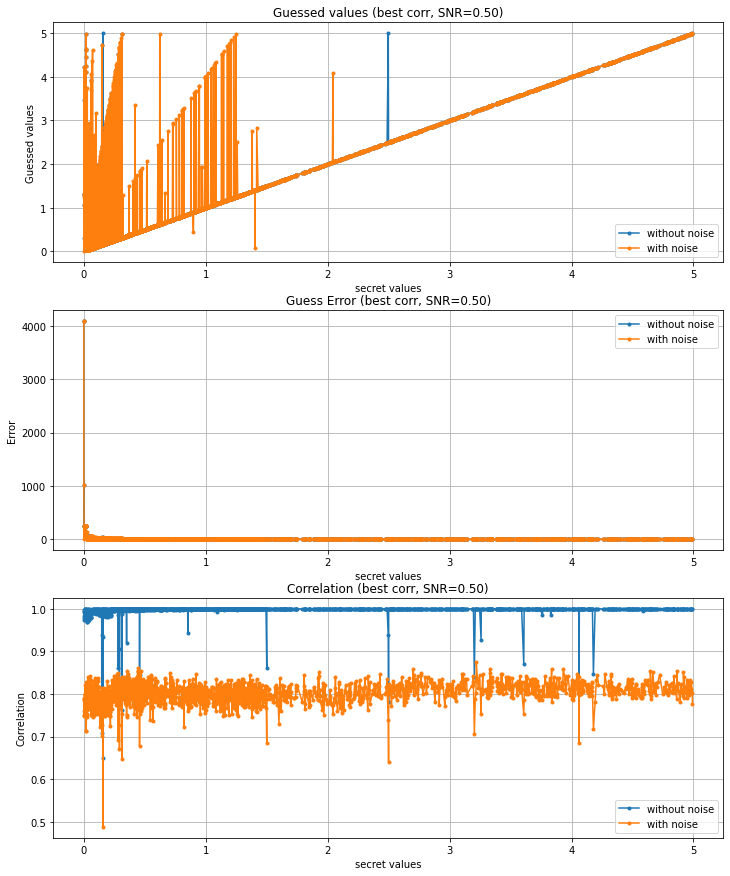

In [132]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

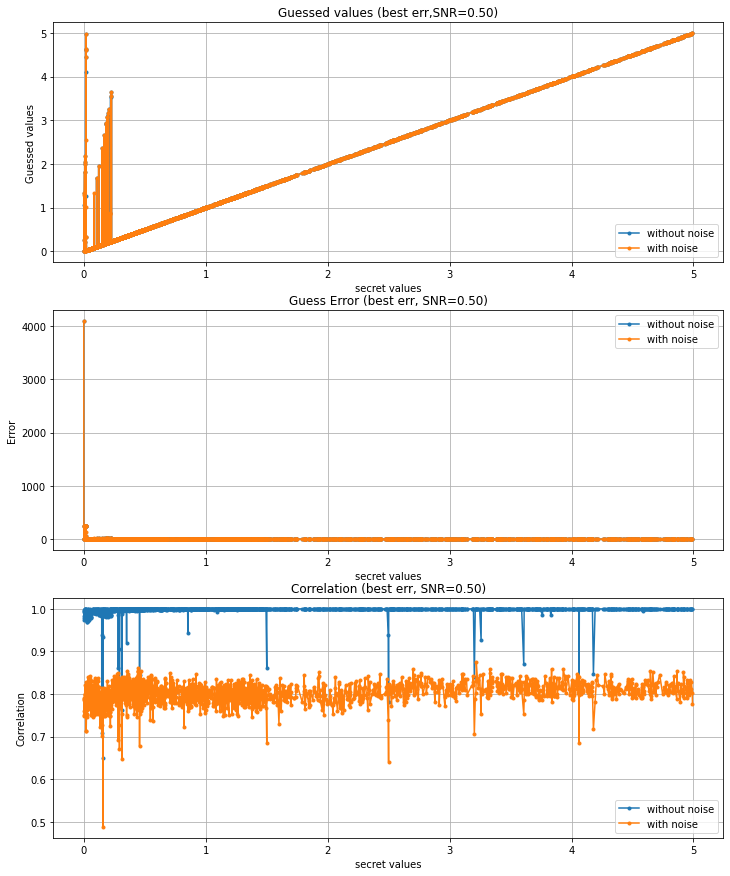

In [133]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best err,SNR=%0.2f)' % signal_to_noise_ratio)


df = best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best err, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best err, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

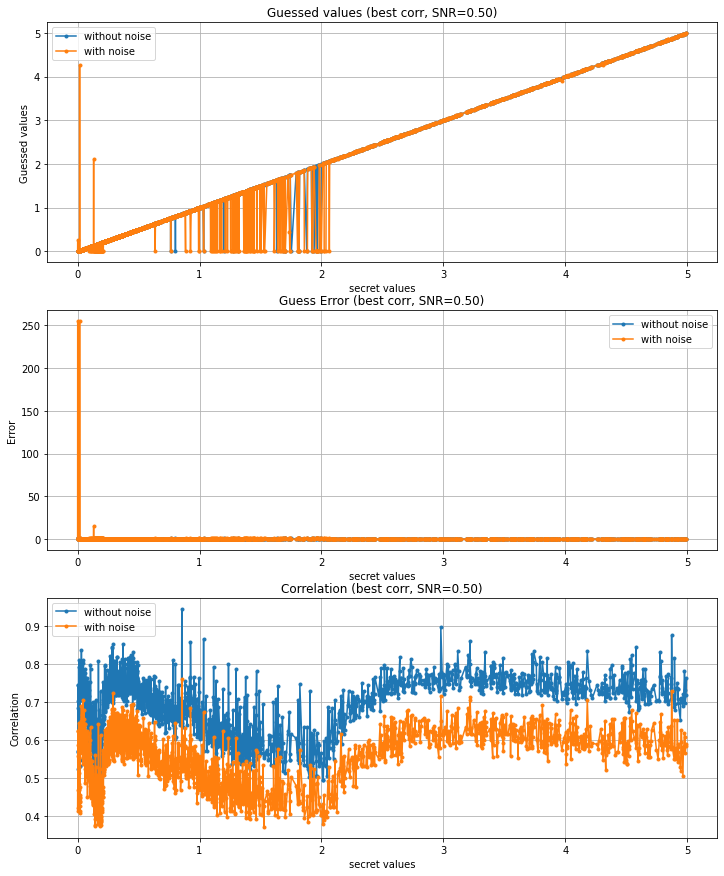

In [134]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()